In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
import numpy as np
import scipy as sp
import nilearn as nl
from nilearn.surface import load_surf_data
import os, shutil, urllib.request
import cortex as cx
from matplotlib import rc
# import pybest
import nibabel as nb
from nibabel import cifti2
import h5py
import matplotlib.pyplot as plt
import matplotlib

import prfpy
from scipy.io import loadmat
from prfpy.rf import *
from prfpy.timecourse import *
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, CSS_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, CSS_Iso2DGaussianFitter

import cortex
from prfpy.utils import subsurface
from prfpy.stimulus import CFStimulus
from prfpy.model import CFGaussianModel
from prfpy.fit import CFFitter
from prfpy.model import Norm_CFGaussianModel
from prfpy.fit import Norm_CFGaussianFitter
from scipy.optimize import LinearConstraint, NonlinearConstraint
import nibabel as nb
from scipy.optimize import curve_fit
from joblib import Parallel, delayed

In [3]:
from nilearn.surface import load_surf_data
import os

roi_index_dict = {
    # somatosensory:
    'CS1_4': 8, 'CS2_3a': 53, 'CS3_3b': 9, 'CS4_1': 51, 'CS5_2': 52,
    # auditory:
    'A1': 24, 'PBelt': 124, 'MBelt': 173, 'LBelt': 174, '52': 103, 'RI': 104,
    # low-level visual:
    'V1': 1, 'V2': 4, 'V3': 5,
    # mid-level and high-level visual:
    'V3A': 13, 'V3B': 19, 'IPS1': 17, 'LIPv': 48, 'LIPd': 95, 
    'VIP': 49, 'FEF': 10, 'MST': 2, 'MT': 23, 'LO1': 20, 'LO2': 21, 'LO3': 159
    }

atlas_data = np.concatenate([load_surf_data(
        os.path.join('/tank/klundert/content/data/atlas', f'Q1-Q6_RelatedParcellation210.CorticalAreas_dil_Colors.59k_fs_LR.dlabel.{hemi}.gii'))
         for hemi in ['L', 'R']])
atlas_data_both_hemis = np.mod(atlas_data, 180)


boolmaskV1 = atlas_data_both_hemis == roi_index_dict['V1']

def psc(data):
  
  # crudely checking whether psc hasn't already happened, in which case do nothing
    if np.mean(data) < 0.5:
        return data
    return ((data.T/np.median(data, 1)).T - 1) * 100

import h5py
idxs = h5py.File('/tank/shared/timeless/atlases/cifti_indices.hdf5', "r")
lidxs = np.array(idxs['Left_indices'])
ridxs = np.array(idxs['Right_indices'])
allidxs = np.concatenate([lidxs, ridxs])

def get_cortex(dat):
    l, r, = dat[lidxs], dat[ridxs]

    # Replace the minus 1
    l[lidxs == -1] = np.zeros_like(l[lidxs == -1])
    r[ridxs == -1] = np.zeros_like(r[ridxs == -1])

    # Last dimension time.
    # l, r = l.T, r.T

    data = np.concatenate([l, r])
    return data

def split_cortex(dat):
    l, r, = dat[lidxs], dat[ridxs]

    # Replace the minus 1
    l[lidxs == -1] = np.zeros_like(l[lidxs == -1])
    r[ridxs == -1] = np.zeros_like(r[ridxs == -1])

    # Last dimension time.
    # l, r = l.T, r.T

#     data = np.concatenate([l, r])
    return l, r

In [7]:
corvol_s2 = nb.load('/tank/shared/2021/visual/TC-COR/sub-02/sub-02_tc-cor_pearson.nii')
corvals_s2 = np.asanyarray(corvol_s2.dataobj).T

corvol_s1 = nb.load('/tank/shared/2021/visual/TC-COR/sub-01/sub-01_tc-cor_pearson.nii')
corvals_s1 = np.asanyarray(corvol_s1.dataobj).T

In [9]:
corvals_s2.shape

(170494, 23)

# practice curve fit

(0.1, 1000)

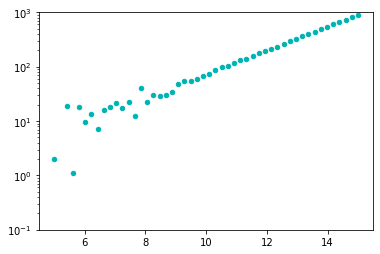

In [789]:
# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)

# Generate dummy dataset
x_dummy = np.linspace(start=5, stop=15, num=50)

# Calculate y-values based on dummy x-values
y_dummy = exponential(x_dummy, 0.5, 0.5)

# Add noise from a Gaussian distribution
noise = 5*np.random.normal(size=y_dummy.size)
y_dummy = y_dummy + noise

# Plot the noisy exponential data
fig, ax = plt.subplots()
ax.scatter(x_dummy, y_dummy, s=20, color='#00b3b3', label='Data')

# Set the y-axis scaling to logarithmic
ax.set_yscale('log')

# Set the y-ticks
ax.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0))
# Set the y-axis limits
ax.set_ylim(0.1, 1000)




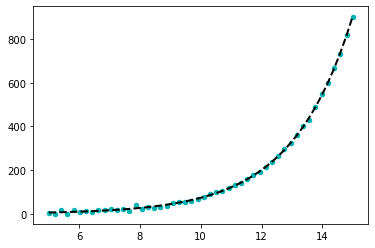

In [790]:
# fit the data

# f — function used for fitting (in this case exponential)
# xdata — array of x-data for fitting
# ydata — array of y-data for fitting
# p0 — array of initial guesses for the fitting parameters (both a and b as 0)
# bounds — bounds for the parameters (-∞ to ∞)
# Outputs
# pars — array of parameters from fit (in this case [a, b])
# cov — the estimated covariance of pars which can be used to 
#     determine the standard deviations of the fitting parameters (square roots of the diagonals)

pars, cov = curve_fit(f=exponential, xdata=x_dummy, 
                      ydata=y_dummy, p0=[0, 0], bounds=(-np.inf, np.inf))

fig, ax = plt.subplots()
ax.scatter(x_dummy, y_dummy, s=20, color='#00b3b3', label='Data')
ax.plot(x_dummy, exponential(x_dummy, *pars), linestyle='--', linewidth=2, color='black')

# practice with single voxel

In [672]:
# assign what to fit to tofit
tofit_y = get_cortex(corvals_s2)[boolmaskV1][100,:]
tofit_x = np.linspace(start=1, stop=len(tofit_y),num=23)
ax.scatter(tofit_x, tofit_y)

# define the function
def exponential(x, a, b):
    return a*np.exp(b*x)

In [677]:
np.insert(tofit_y, 0, 0)

array([ 0.        , -0.00183173,  0.07113183,  0.09352271,  0.08763538,
        0.11727736,  0.15180498,  0.1493161 ,  0.14585392,  0.1684375 ,
        0.21253286,  0.21784653,  0.2054257 ,  0.1885112 ,  0.2802423 ,
        0.2783443 ,  0.33762804,  0.33131224,  0.31862453,  0.3541328 ,
        0.34066218,  0.39062002,  0.374537  ,  0.39399162], dtype=float32)

[0.137613   0.09452698]


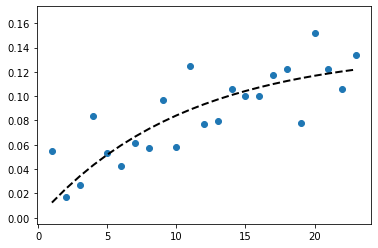

In [787]:
# assign what to fit
boolmaskV1 = atlas_data_both_hemis == roi_index_dict['V1']
boolmaskLO1 = atlas_data_both_hemis == roi_index_dict['LO1']
tofit_y = get_cortex(corvals_s2)[boolmaskV1][1500,:] # 50
tofit_x = np.linspace(start=1, stop=len(tofit_y),num=23)
ax.scatter(tofit_x, tofit_y)


# define the function
def exponential(x, a, b):
    return a-a*np.exp(-b*x)


pars, cov = curve_fit(f=exponential, xdata=tofit_x, 
                      ydata=tofit_y, p0=[1, 0], bounds=[(0, -np.inf), (1, np.inf)])

fig, ax = plt.subplots()
ax.scatter(tofit_x, tofit_y)
ax.plot(tofit_x, exponential(tofit_x, *pars), linestyle='--', linewidth=2, color='black')
print(pars)

In [ ]:
# if a is higher the correlation between timecourses is lower to start with
# if b is lower the correlation increases more nonlinear as you average more runs

# fit all vertices

In [770]:
## parallel fit all vertices and store paramaters

exp_bounds = [(0, -np.inf), 
              (1, np.inf)]


def exponential(x, a, b):
    return a-a*np.exp(-b*x)

params = Parallel(10, verbose=True)(
    delayed(curve_fit)(
        f=exponential,
        xdata=tofit_x,
        ydata=tofit_y,
        p0=[1, 0],
        bounds=exp_bounds)
    for tofit_y in np.nan_to_num(get_cortex(corvals_s2)))

unzipped_object = zip(*params)
unzipped_list = list(unzipped_object)
a_b_params = np.array(unzipped_list[0])

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  45 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 7660 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done 16780 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done 37180 tasks      | elapsed:   20.9s
[Parallel(n_jobs=10)]: Done 76500 tasks      | elapsed:   39.4s
[Parallel(n_jobs=10)]: Done 117660 tasks      | elapsed:   58.7s
[Parallel(n_jobs=10)]: Done 118584 out of 118584 | elapsed:   59.3s finished


In [754]:
# ## parallel fit all vertices and store paramaters
# exp_bounds = [(0, -np.inf), 
#               (1, np.inf)]


# def exponential_as(x, a, b):
#     return a-a*np.exp(b*x)

# params = Parallel(10, verbose=True)(
#     delayed(curve_fit)(
#         f=exponential_as,
#         xdata=tofit_x,
#         ydata=tofit_y,
#         p0=[a, b],
#         bounds=exp_bounds)
#     for tofit_y, a, b in zip(np.nan_to_num(get_cortex(corvals_s2)), a_b_params[:,0], a_b_params[:,1]))

# unzipped_object = zip(*params)
# unzipped_list = list(unzipped_object)
# a_b_params_as = np.array(unzipped_list[0])

### plot a & b params and paramater curves

In [683]:
np.nanmax(a_b_params[:,1])

0.0

Text(0.5, 0.98, 'a param')

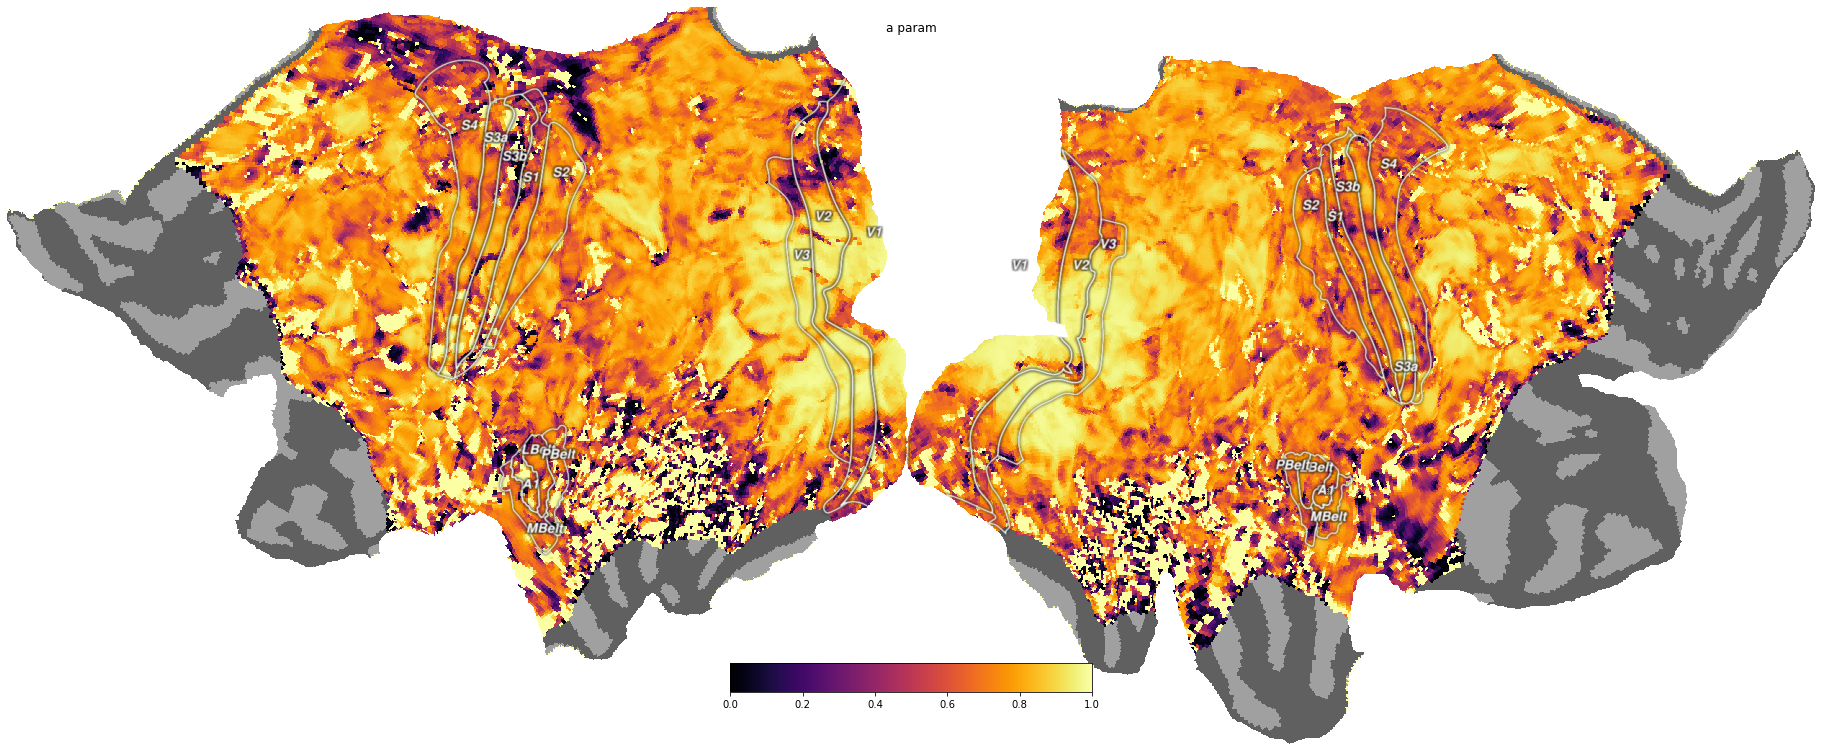

In [771]:
nanmask = np.isnan(get_cortex(corvals_s2[:,0]))
toplot = a_b_params[:,0]
toplot[nanmask] = np.nan
f = cortex.quickshow(cortex.Vertex(toplot, subject='hcp_999999', cmap='inferno'), with_curvature=True);
f.suptitle('Asymptote param')

Text(0.5, 0.98, 'Tau param')

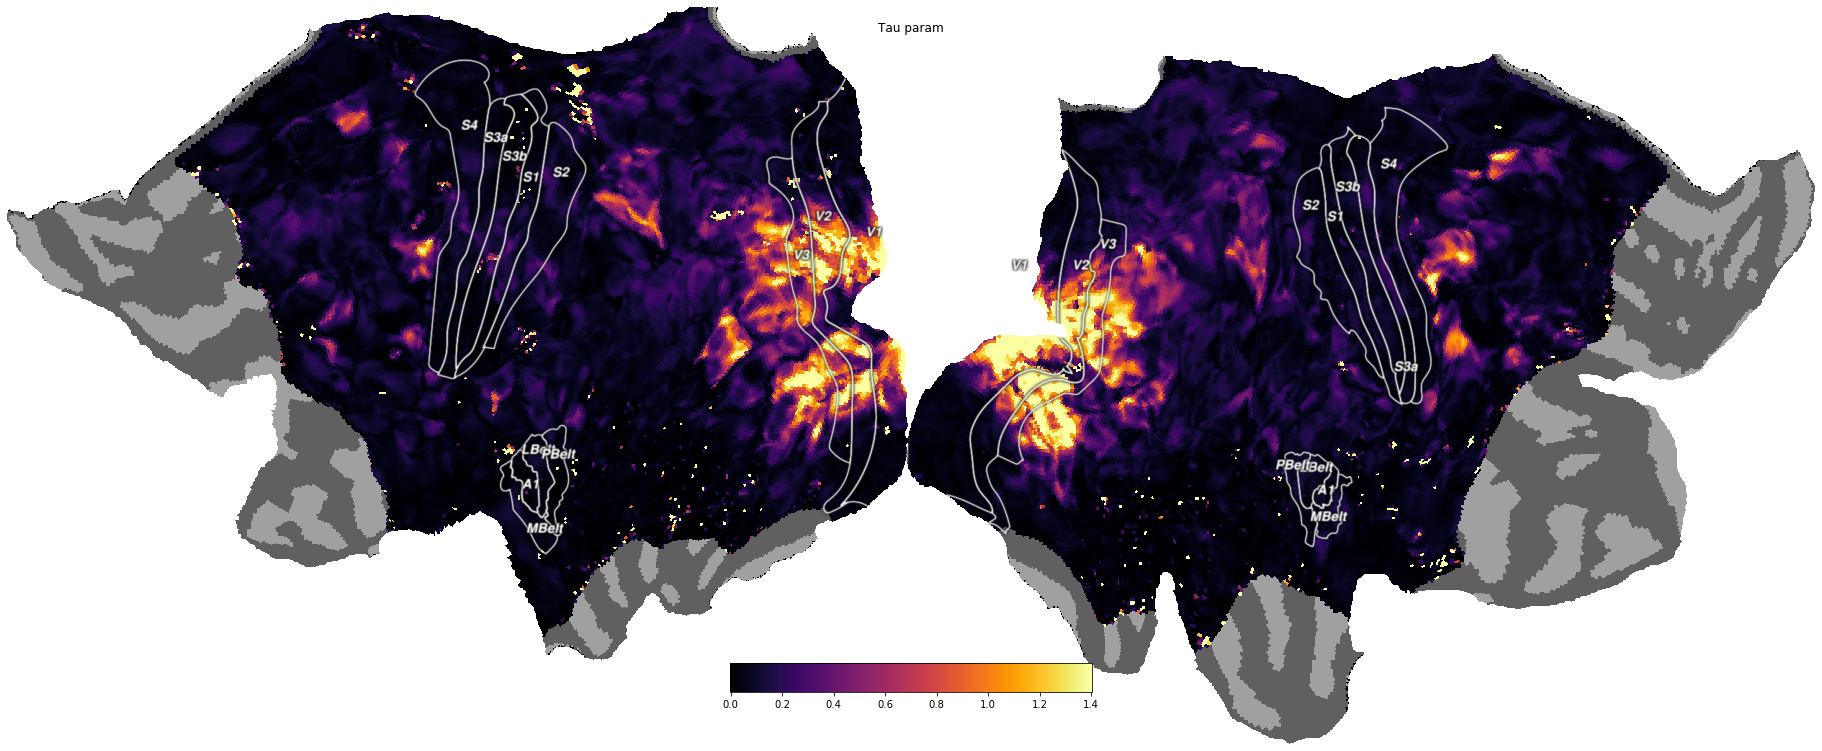

In [772]:
nanmask = np.isnan(get_cortex(corvals_s2[:,0]))
toplot = a_b_params[:,1]
toplot[nanmask] = np.nan
f = cortex.quickshow(cortex.Vertex(toplot, subject='hcp_999999', cmap='inferno'), with_curvature=True);
f.suptitle('Tau param')

Text(0.5, 0.98, 'covar map of asymptote and tau params')

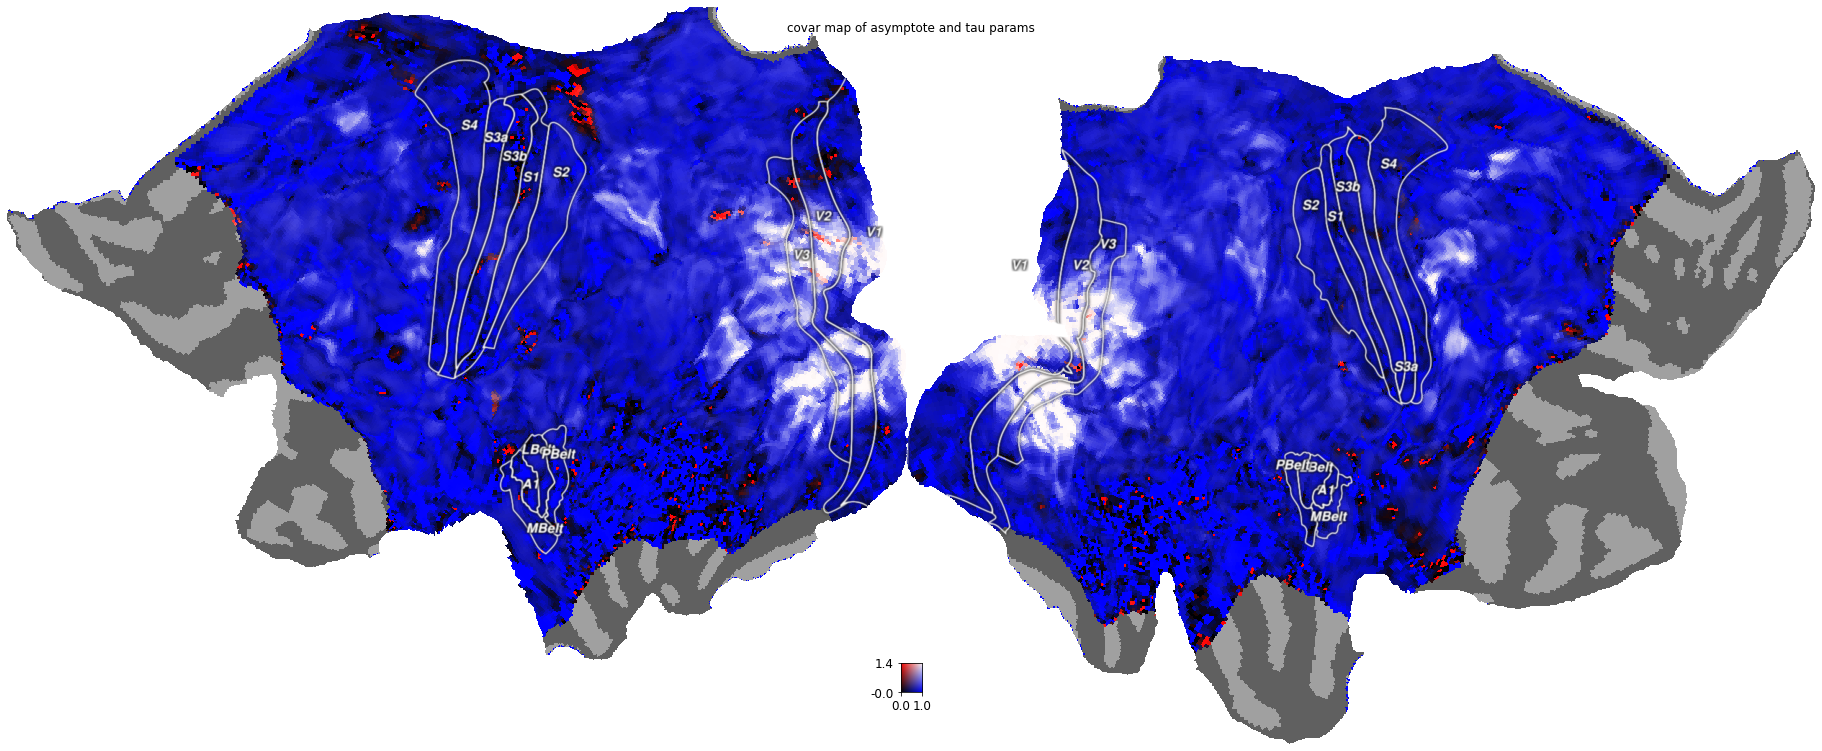

In [773]:
toplot1 = a_b_params[:,0]
toplot2 = a_b_params[:,1]
toplot1[nanmask] = np.nan
toplot2[nanmask] = np.nan

vertex_data = cortex.Vertex2D(a_b_params[:,0], a_b_params[:,1], subject='hcp_999999')
f = cortex.quickshow(vertex_data, with_colorbar=True, with_curvature=True);
f.suptitle('covar map of asymptote and tau params')

In [763]:
toplot_x = np.linspace(start=0, stop=200,num=100)

# toplot_x = np.linspace(start=1, stop=len(tofit_y),num=23)

Text(0, 0.5, 'pearson r')

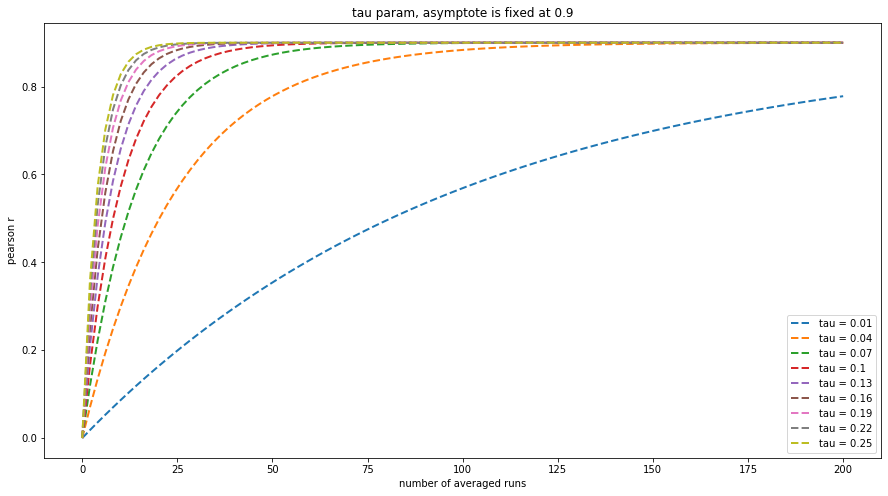

In [783]:
plt.figure(figsize=[15,8])
for b in np.array([0.01, 0.04, 0.07, 0.1 , 0.13, 0.16, 0.19, 0.22, 0.25]):
    plt.plot(toplot_x, exponential(toplot_x, 0.9, b), linestyle='--', linewidth=2, label=f'tau = {b}')
plt.legend()
plt.title('tau param, asymptote is fixed at 0.9')
plt.xlabel('number of averaged runs')
plt.ylabel('pearson r')

In [349]:
# plt.figure(figsize=[15,8])
# for b in np.array([-0.01, -0.04, -0.07, -0.1 , -0.13, -0.16, -0.19, -0.22, -0.25]):
#     plt.plot(tofit_x, exponential(tofit_x, 0.5, b), linestyle='--', linewidth=2, label=f'b = {b}')
# plt.legend()

Text(0, 0.5, 'pearson r')

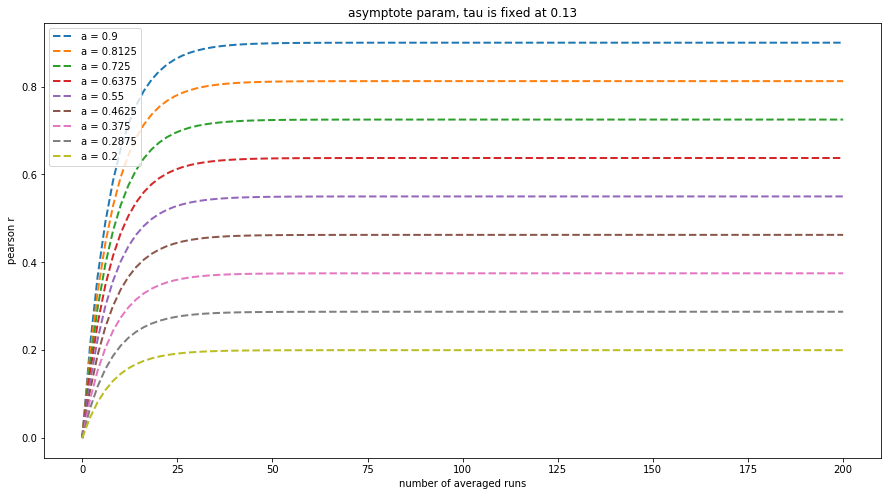

In [784]:
plt.figure(figsize=[15,8])
for a in np.array([0.9, 0.8125, 0.725 , 0.6375, 0.55, 0.4625, 0.375, 0.2875, 0.2]):
    plt.plot(toplot_x, exponential(toplot_x, a, 0.13), linestyle='--', linewidth=2, label=f'a = {a}')
plt.legend()
plt.title('asymptote param, tau is fixed at 0.13')
plt.xlabel('number of averaged runs')
plt.ylabel('pearson r')

In [343]:
np.linspace(start=0.9, stop=0.2, num=9)

array([0.9   , 0.8125, 0.725 , 0.6375, 0.55  , 0.4625, 0.375 , 0.2875,
       0.2   ])

In [ ]:
# assign what to fit
boolmaskV1 = atlas_data_both_hemis == roi_index_dict['V1']
boolmaskLO1 = atlas_data_both_hemis == roi_index_dict['LO1']
tofit_y = get_cortex(corvals_s2)[boolmaskV1][2000,:]
tofit_x = np.linspace(start=1, stop=len(tofit_y),num=23)
ax.scatter(tofit_x, tofit_y)


# define the function
def exponential(x, a, b):
    return 1-a*np.exp(b*x)


pars, cov = curve_fit(f=exponential, xdata=tofit_x, 
                      ydata=tofit_y, p0=[0, 0], bounds=(-np.inf, np.inf))

fig, ax = plt.subplots()
ax.scatter(tofit_x, tofit_y)
ax.plot(tofit_x, exponential(tofit_x, *pars), linestyle='--', linewidth=2, color='black')
print(pars)

In [ ]:
def exponential(x, a, b, c):
    return a * np.exp(-b * x) + c

### check some cases

[4.34301080e-08 5.71269716e-01]


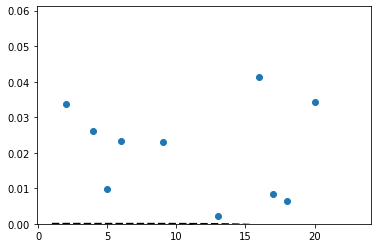

In [753]:
vox = np.where(a_b_params[:,0] == np.nanmin(a_b_params[:,0]))[0][0]
# vox = 2000

# assign what to fit
boolmaskV1 = atlas_data_both_hemis == roi_index_dict['V1']
boolmaskLO1 = atlas_data_both_hemis == roi_index_dict['LO1']
tofit_y = get_cortex(corvals_s2)[vox,:] # 50
tofit_x = np.linspace(start=1, stop=len(tofit_y),num=23)
ax.scatter(tofit_x, tofit_y)


# define the function
def exponential(x, a, b):
    return a-a*np.exp(b*x)


pars, cov = curve_fit(f=exponential, xdata=tofit_x, 
                      ydata=tofit_y, p0=[1, 0], bounds=[(0, -np.inf), (1, np.inf)])

fig, ax = plt.subplots()
ax.scatter(tofit_x, tofit_y)
ax.plot(tofit_x, exponential(tofit_x, *pars), linestyle='--', linewidth=2, color='black')
ax.set_ylim(ymin=0)


print(pars)

(0, 0.9983725997062181)

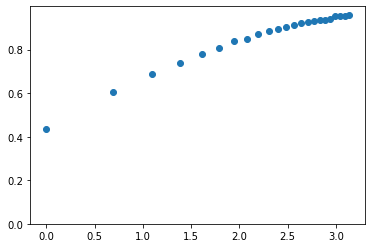

In [644]:
fig, ax = plt.subplots()
ax.scatter(np.log(tofit_x), tofit_y)
ax.set_ylim(ymin=0)


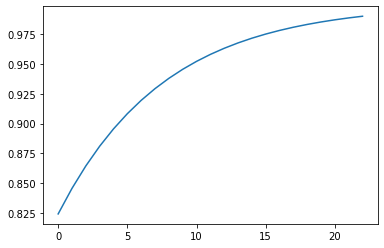

In [643]:
plt.plot(1-0.2*np.exp(-0.13*tofit_x))

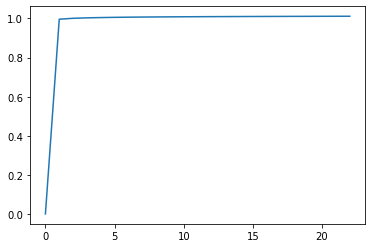

In [637]:
plt.plot(np.log(tofit_x)**0.01)

In [642]:
np.log(1)

0.0

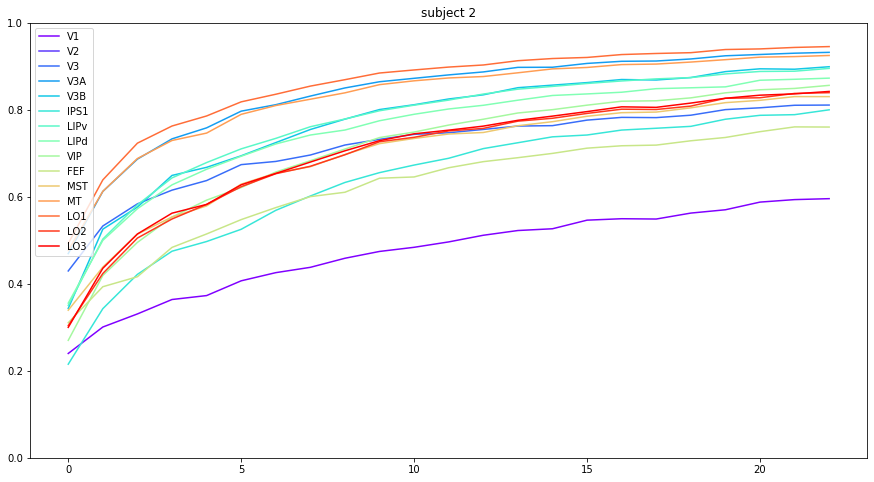

In [785]:
from matplotlib.pyplot import cm
import numpy as np

color = iter(cm.rainbow(np.linspace(0, 1, len(list(roi_index_dict.keys())[11:]))))

f = plt.figure(figsize=[15,8])
for keys in list(roi_index_dict.keys())[11:]:
    c = next(color)
    roi_mask = atlas_data_both_hemis == roi_index_dict[keys]
    plt.plot(get_cortex(corvals_s2)[roi_mask].mean(axis=0), label = str(keys), c=c)
    plt.ylim(0, 1)
    plt.legend(loc='upper left')
    plt.title('subject 2')
    


/tank/klundert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


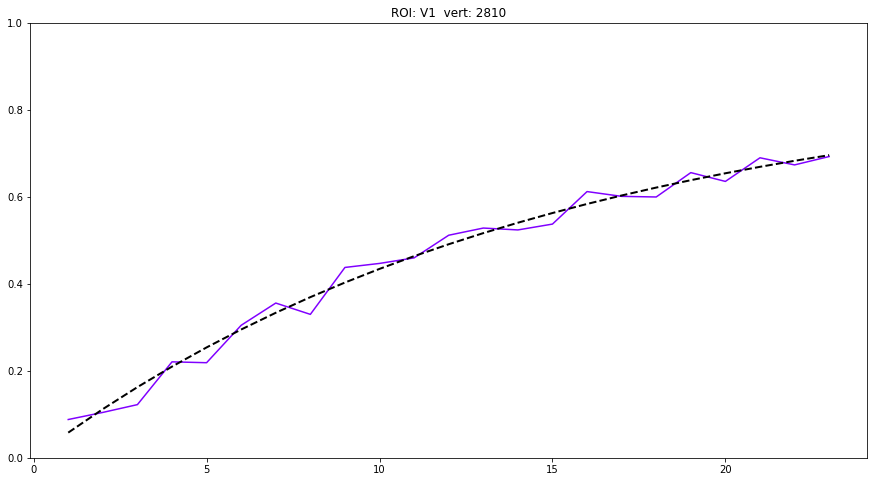

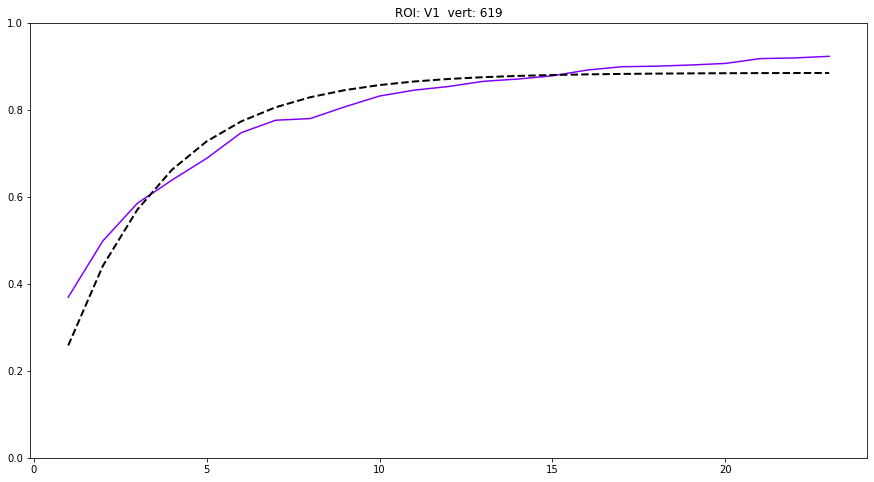

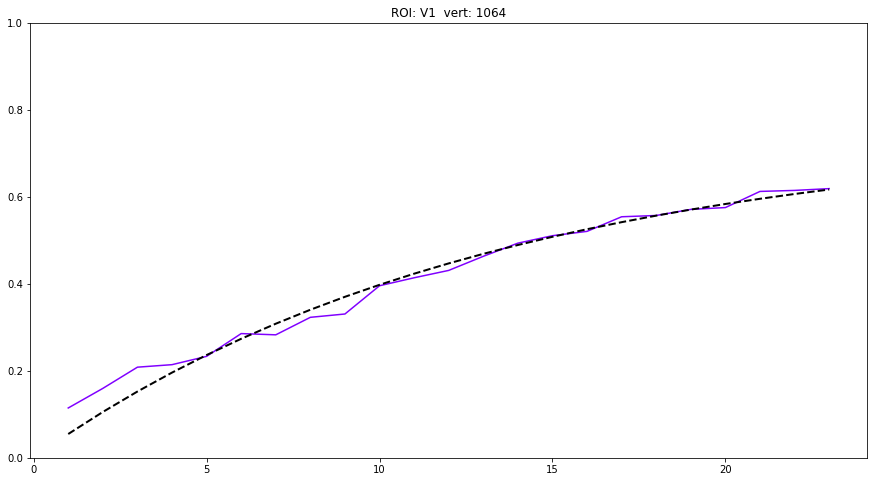

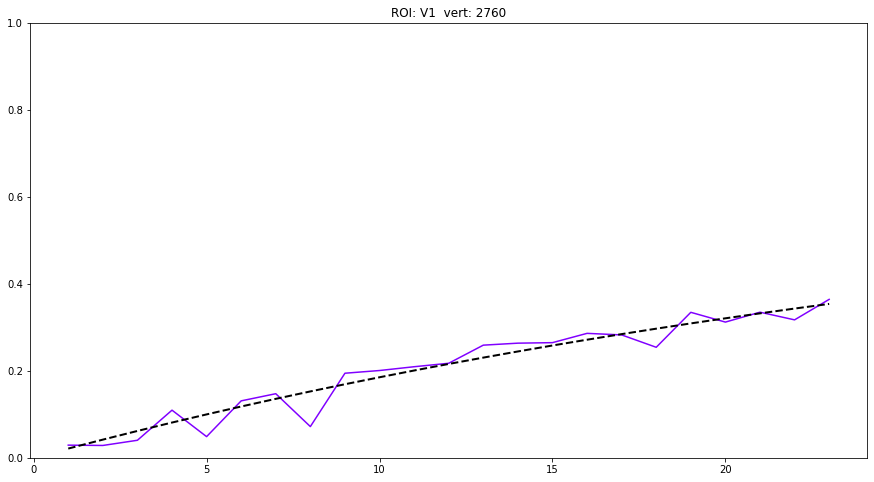

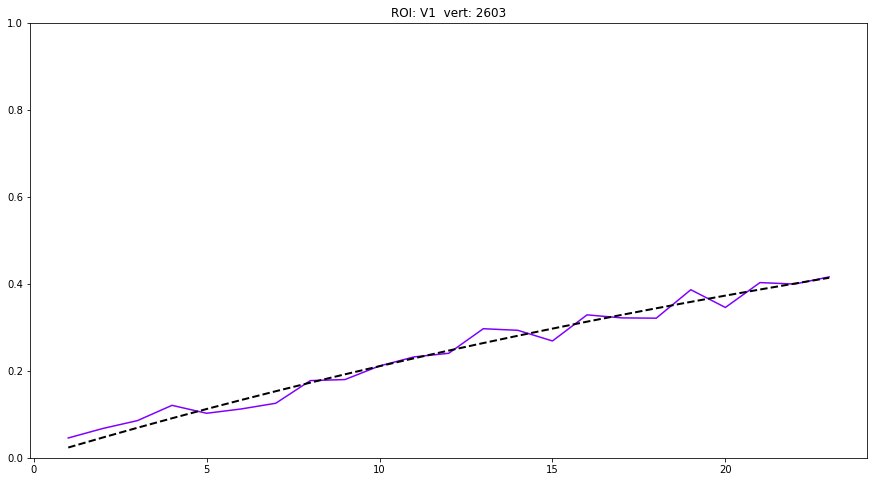

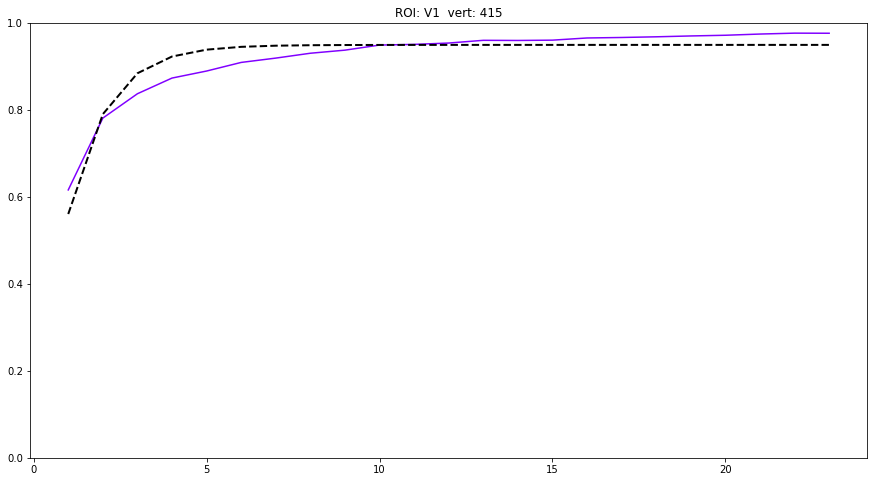

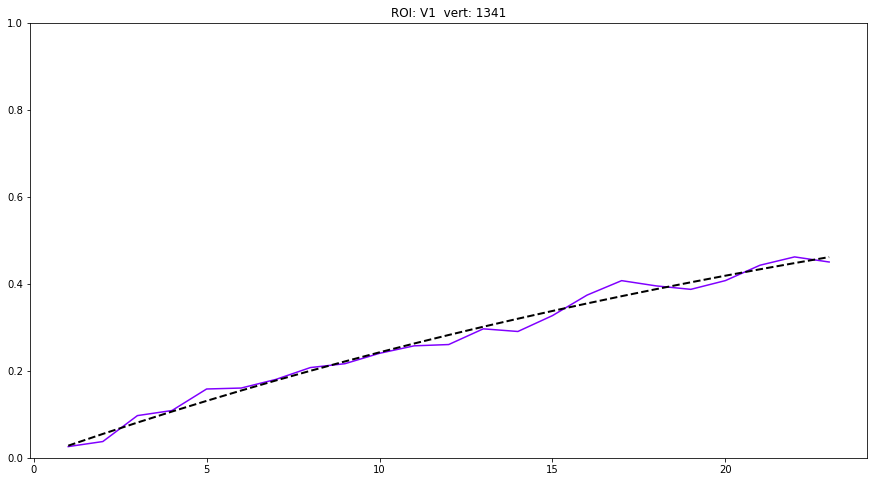

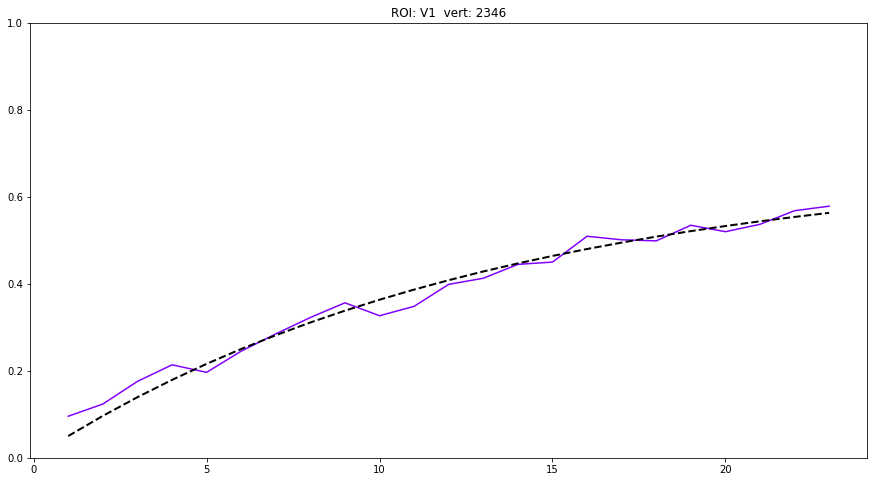

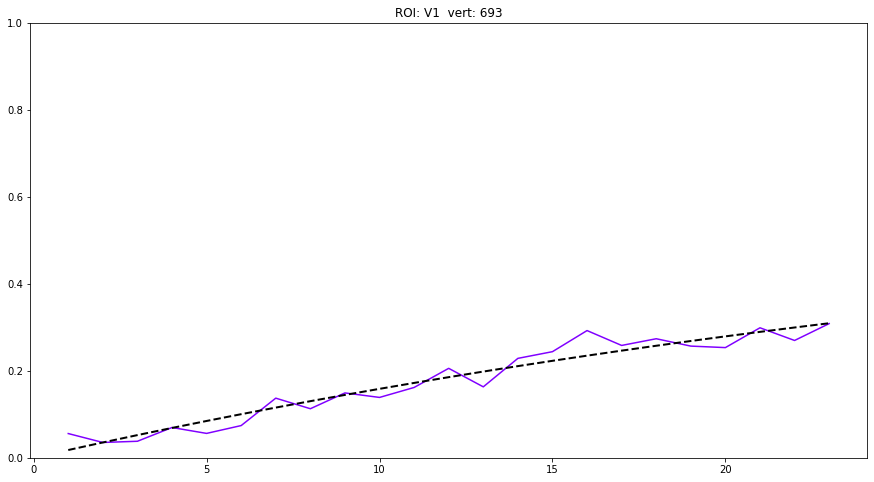

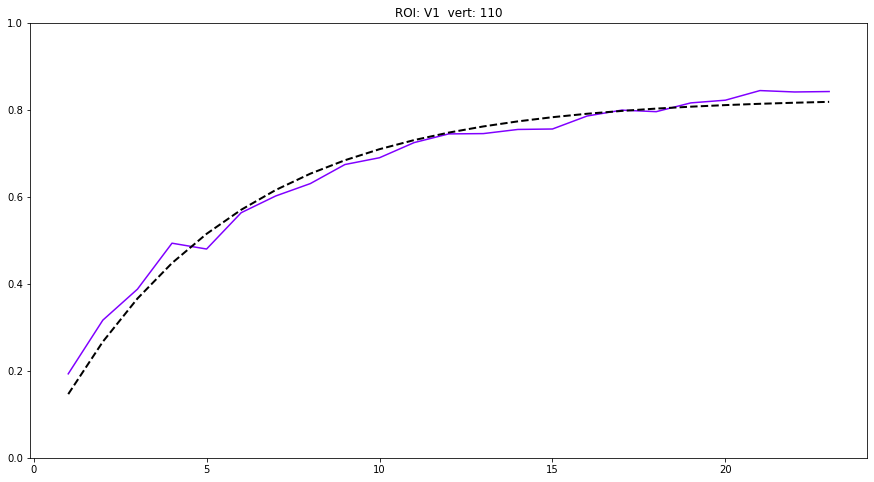

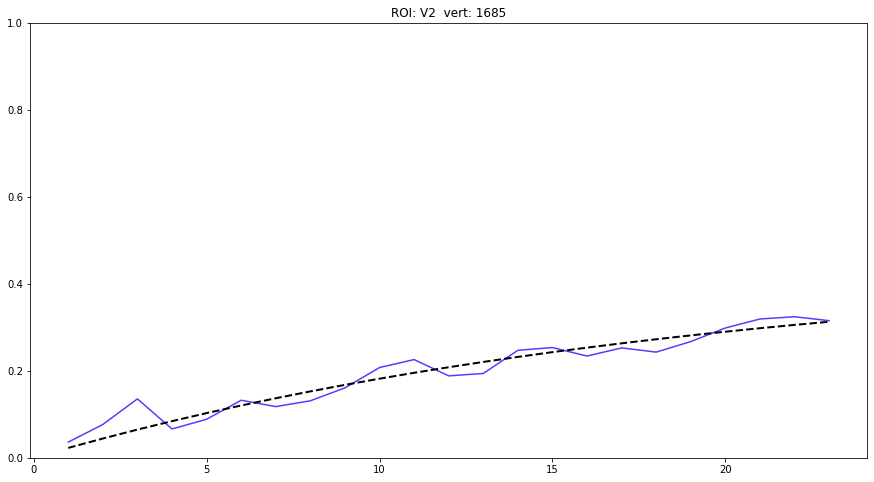

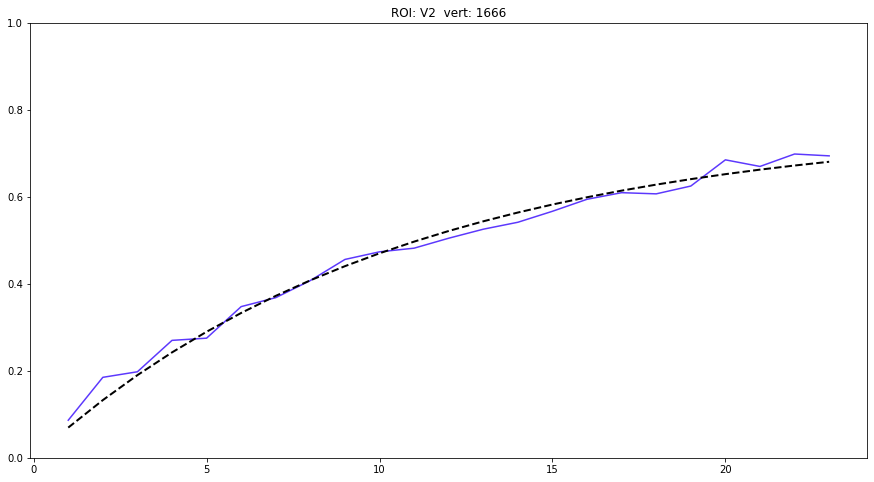

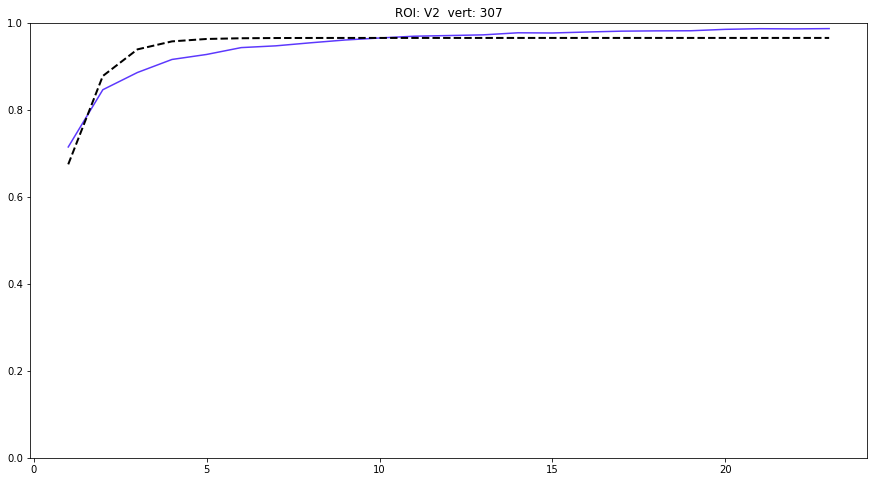

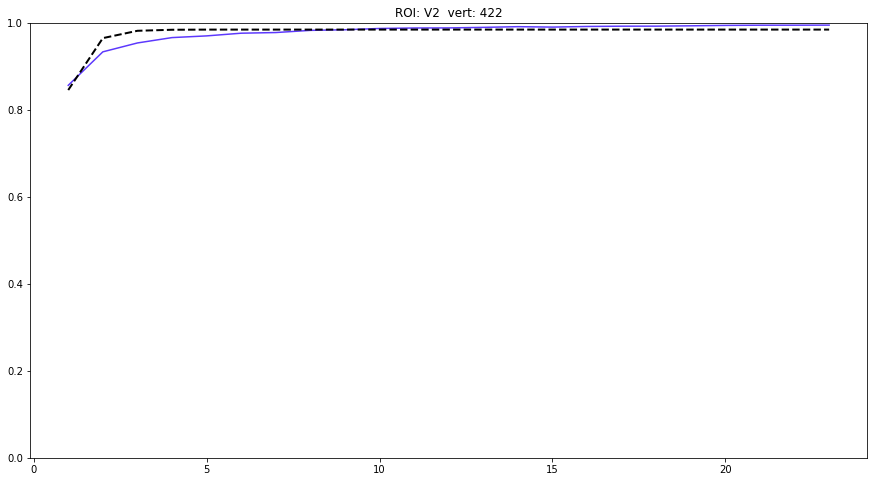

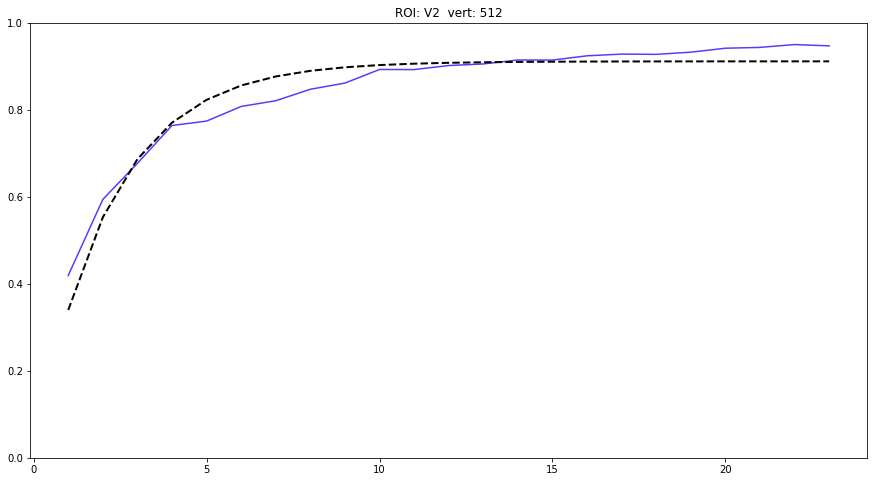

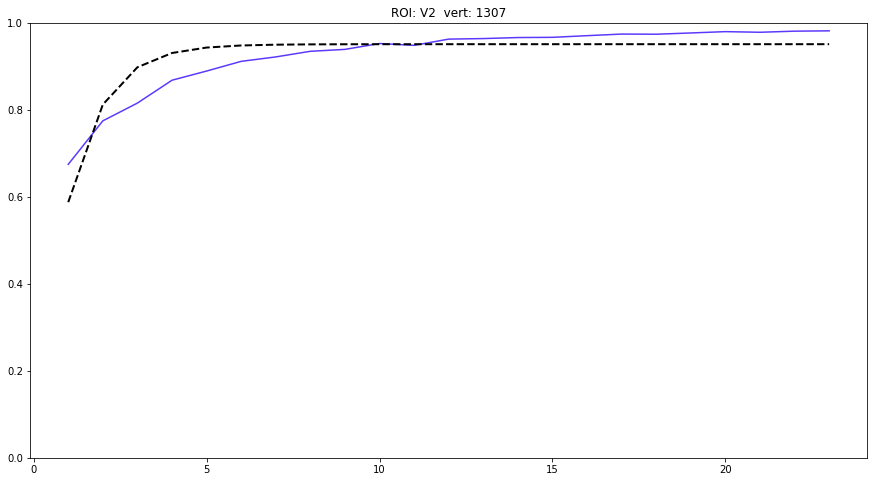

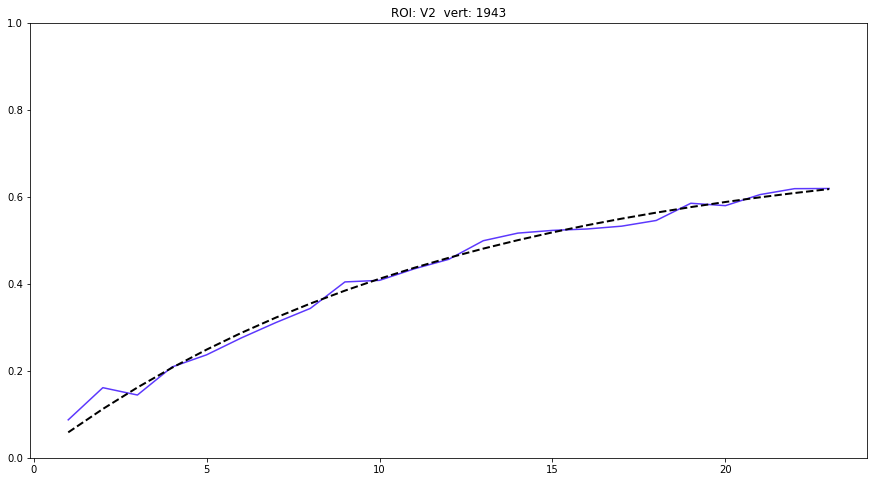

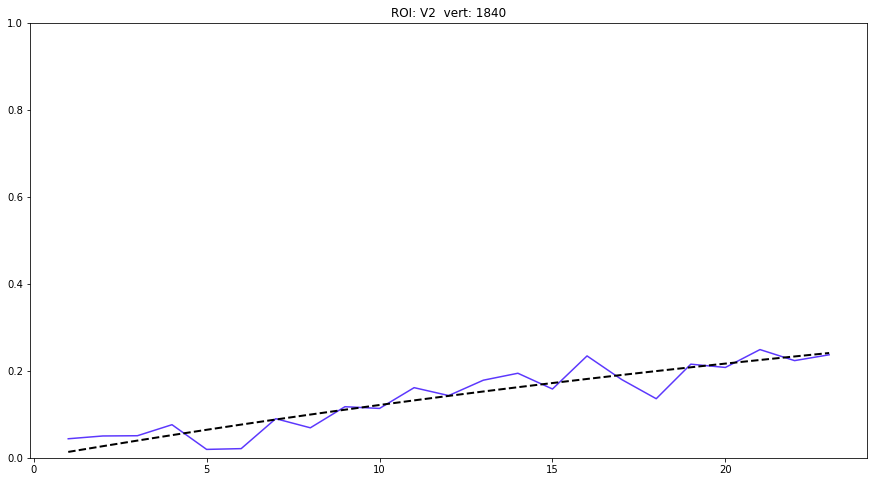

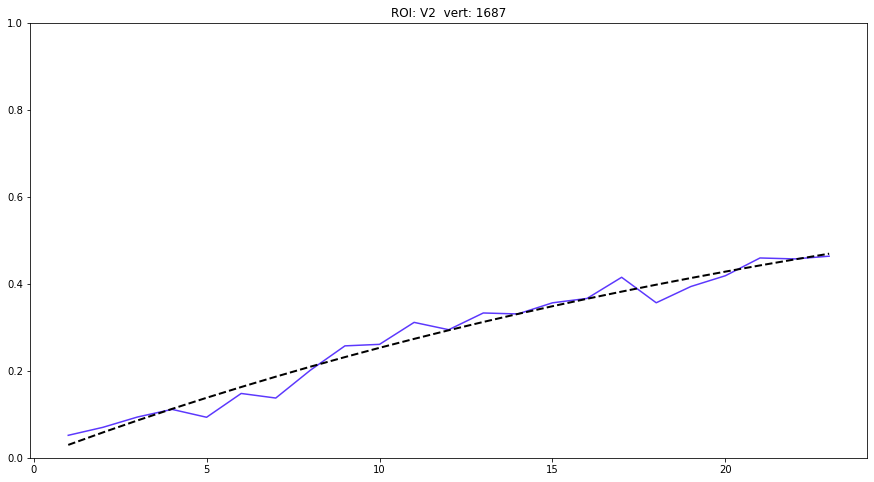

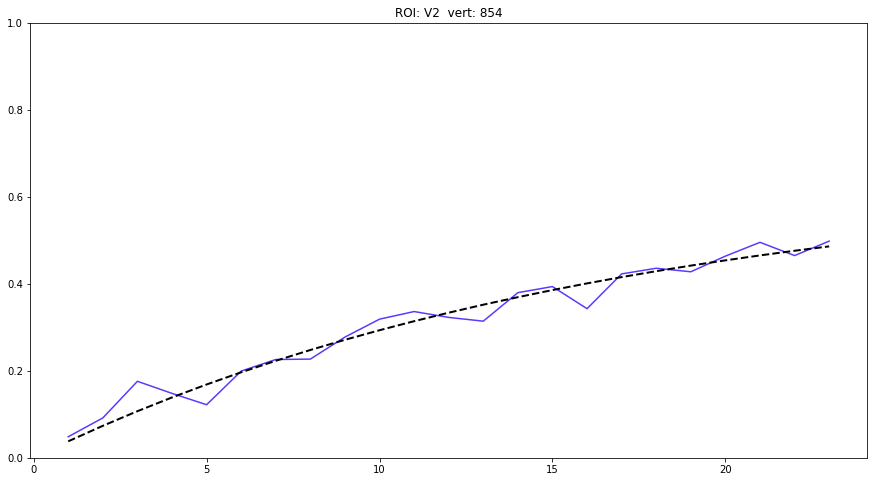

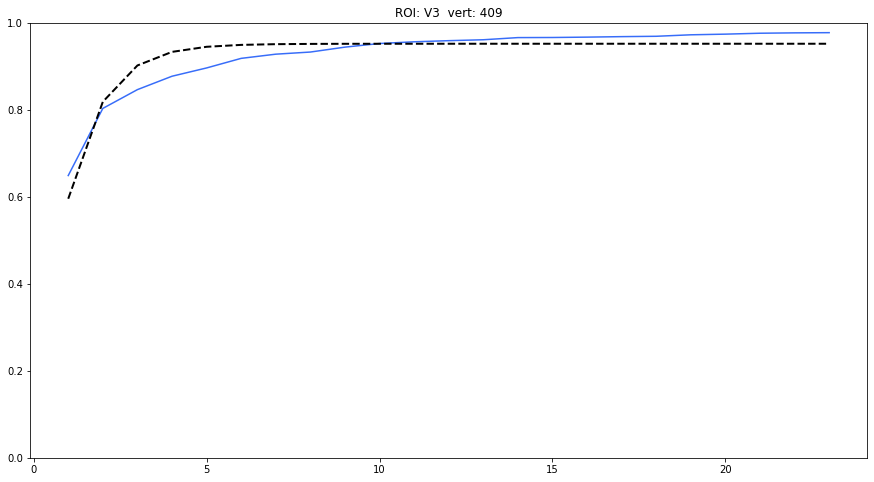

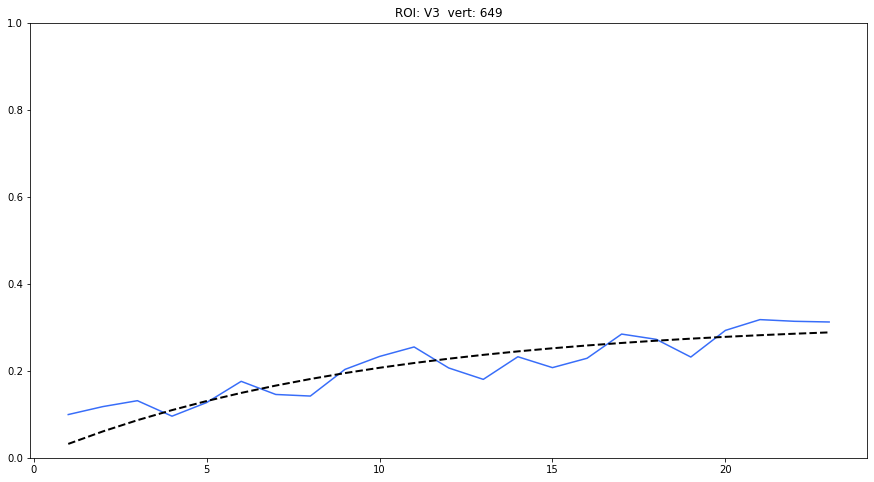

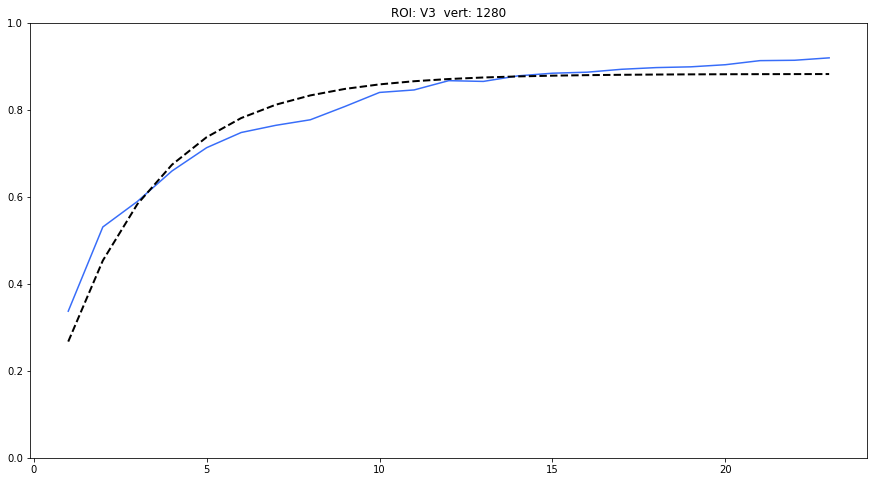

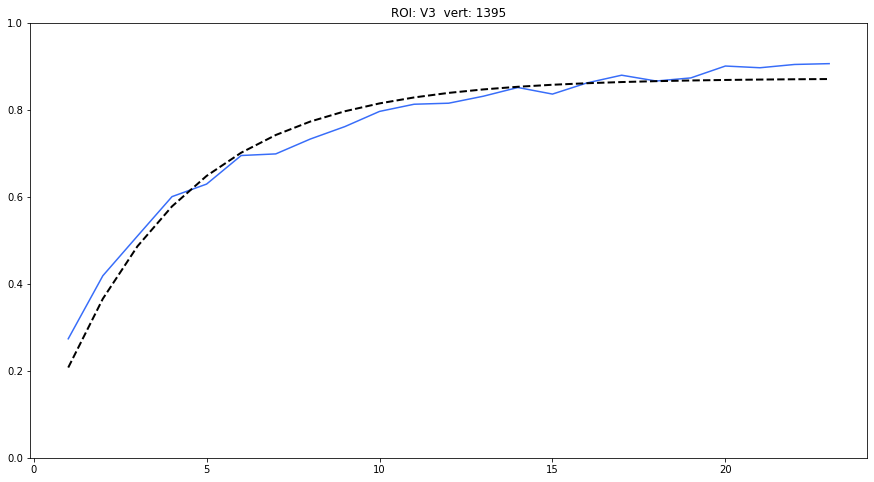

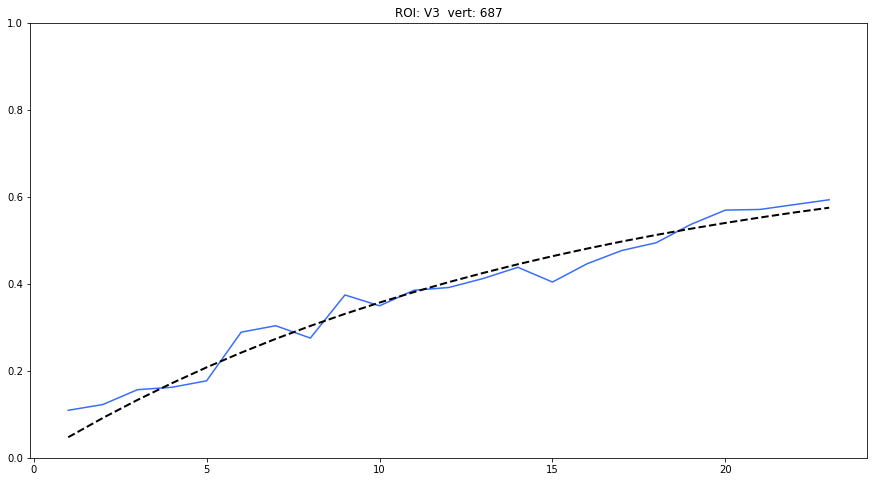

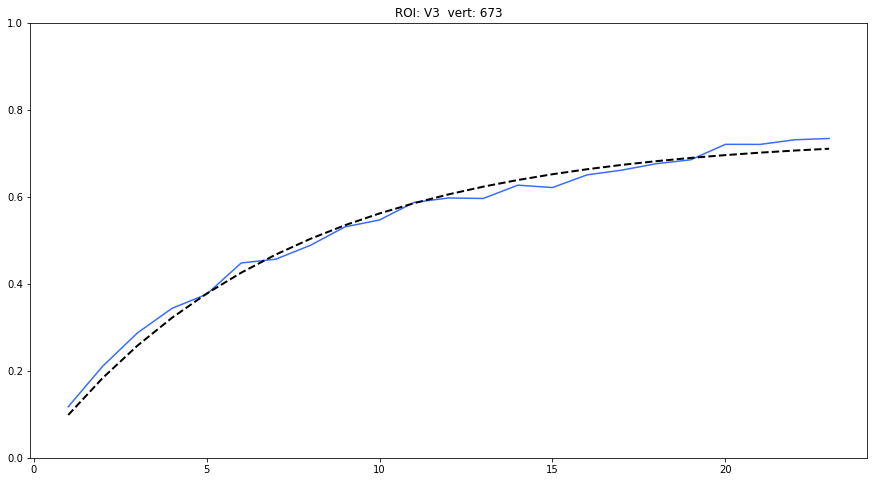

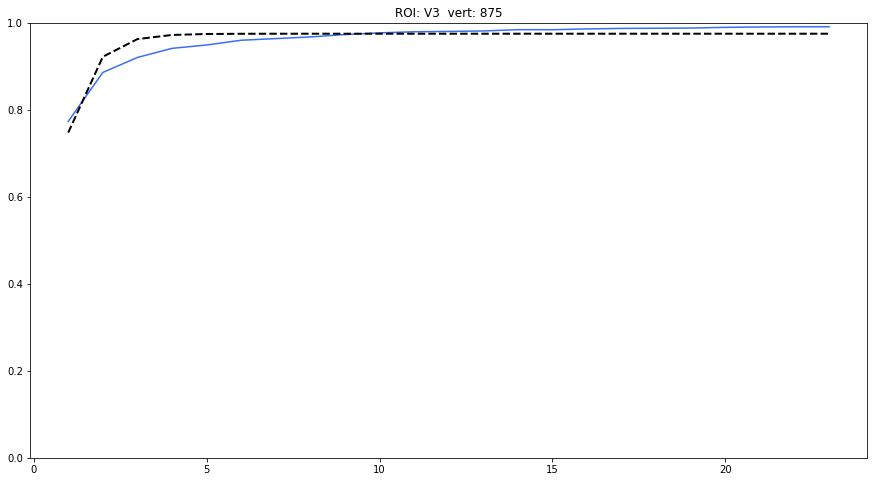

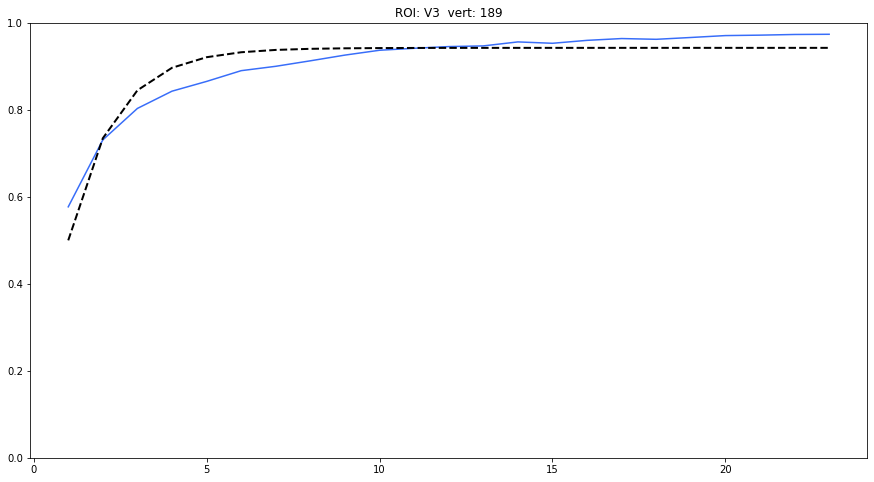

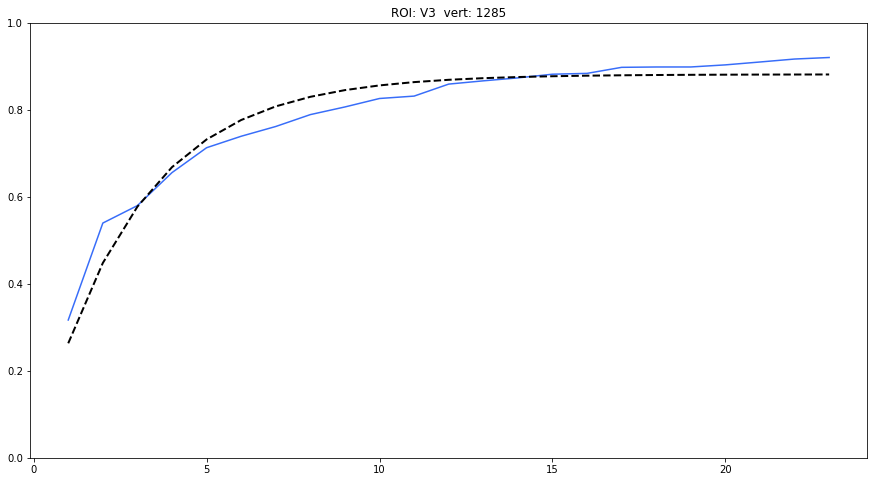

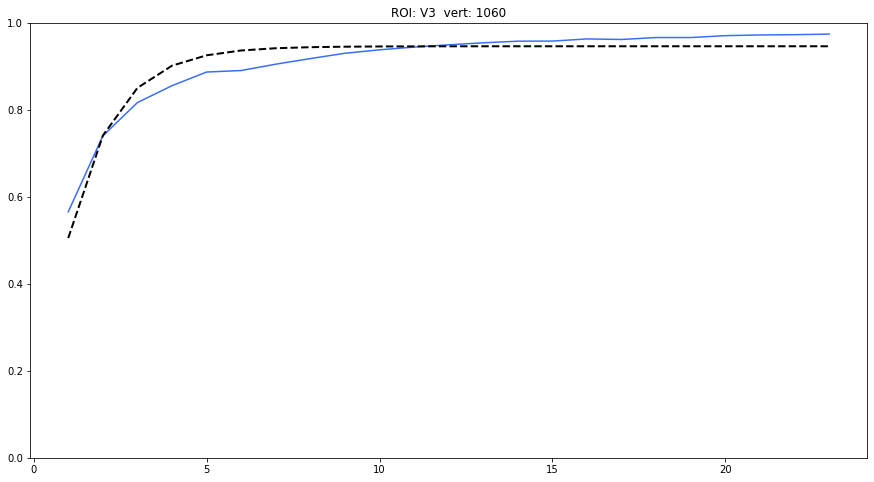

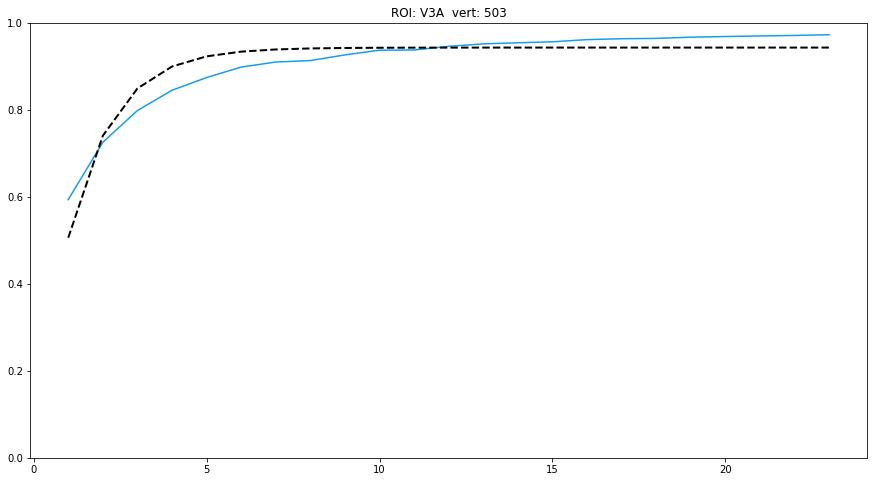

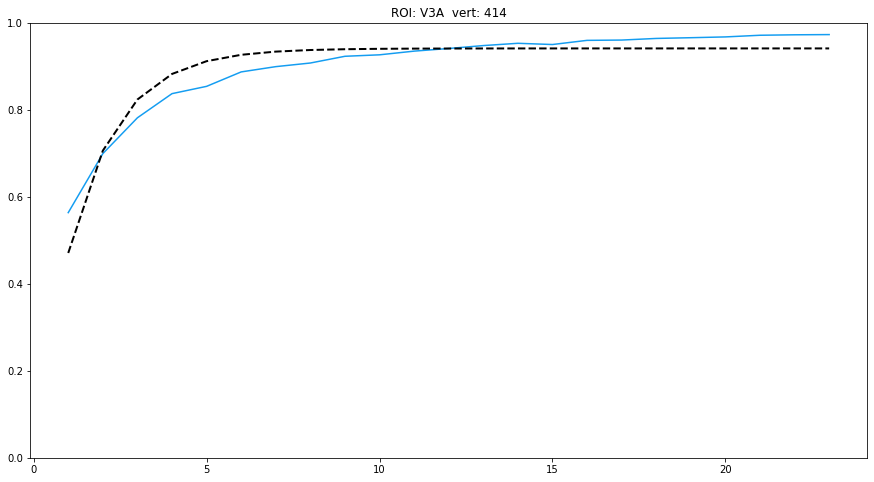

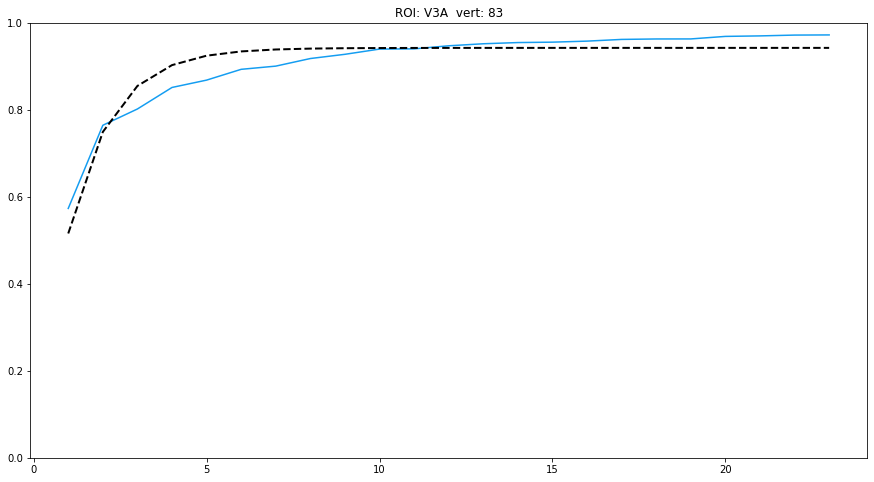

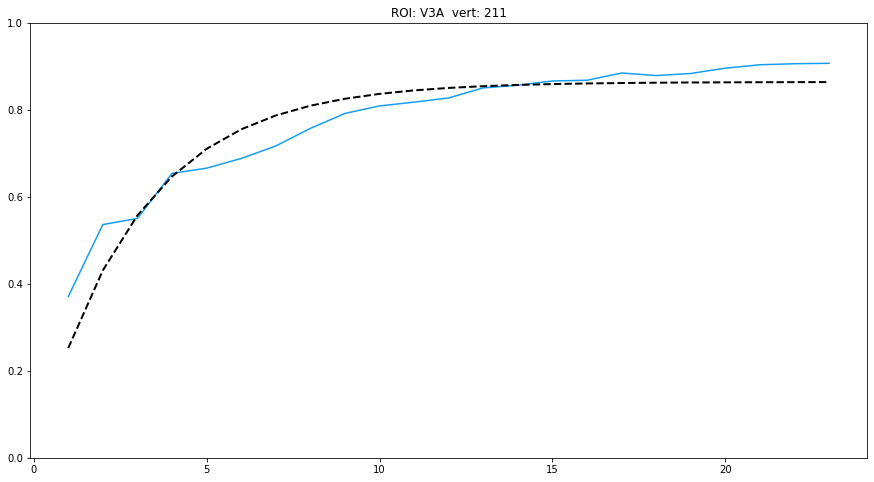

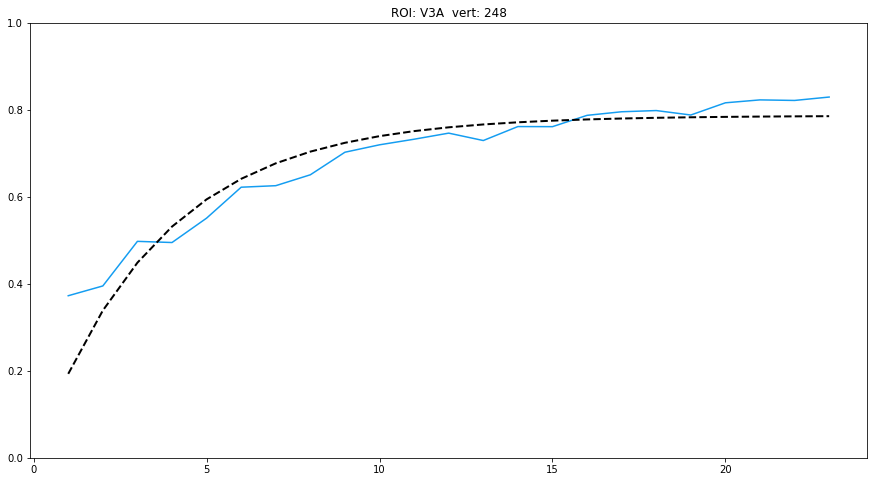

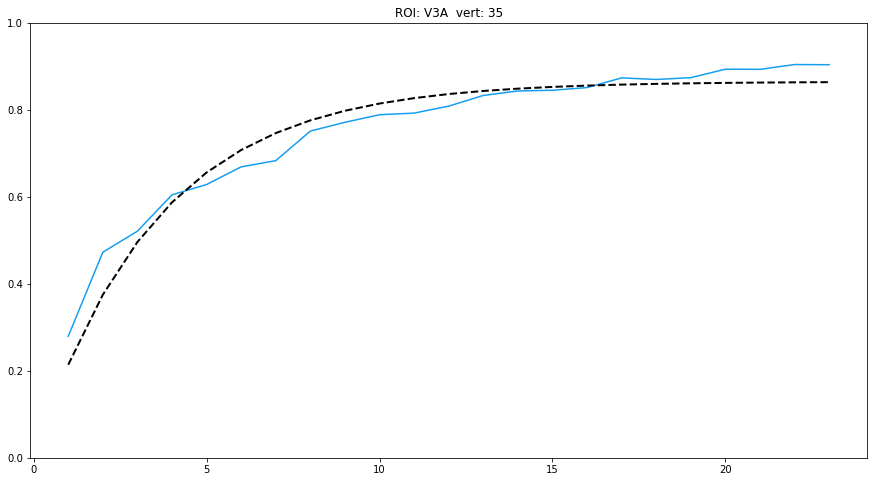

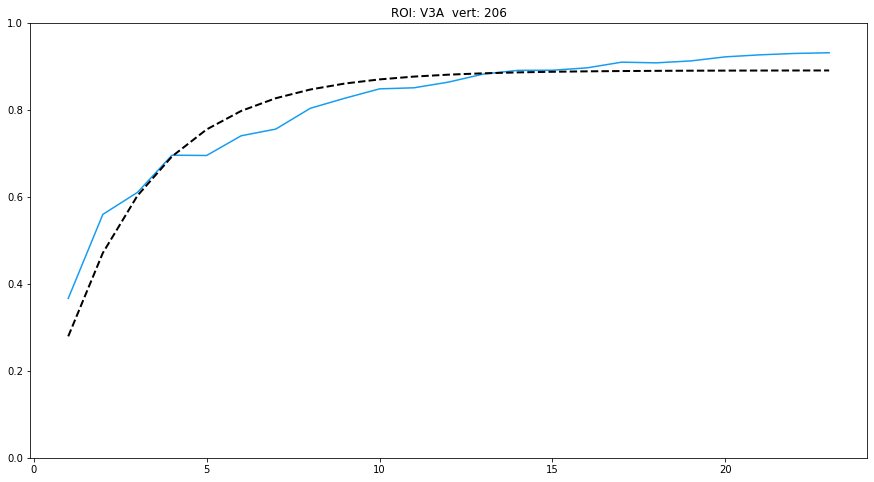

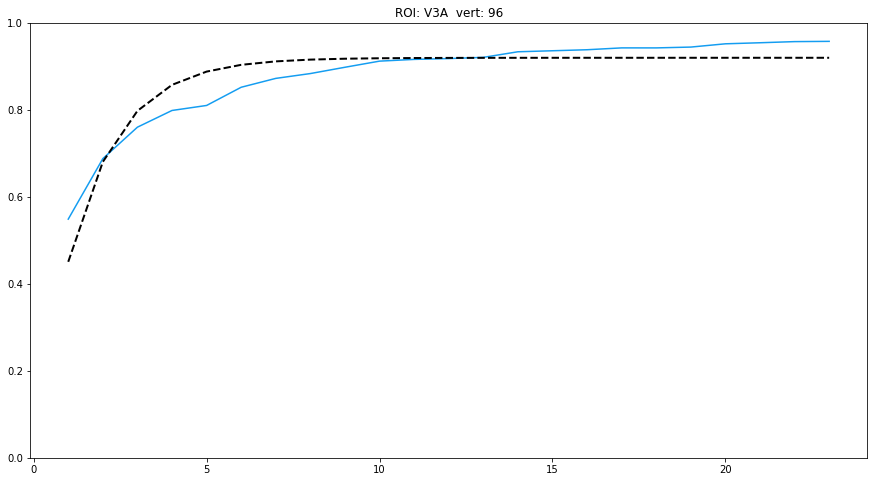

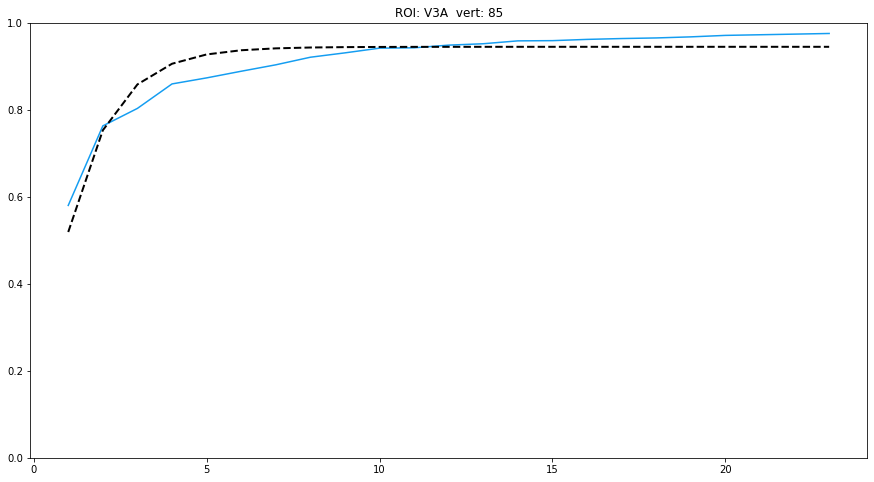

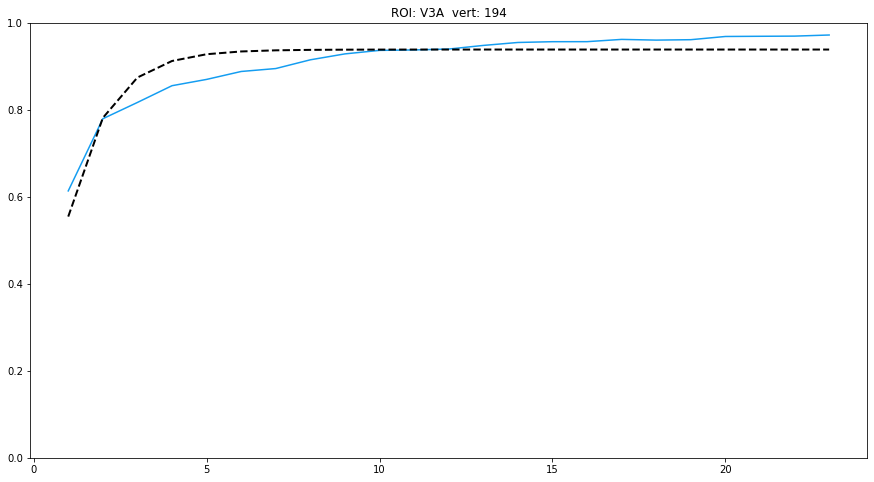

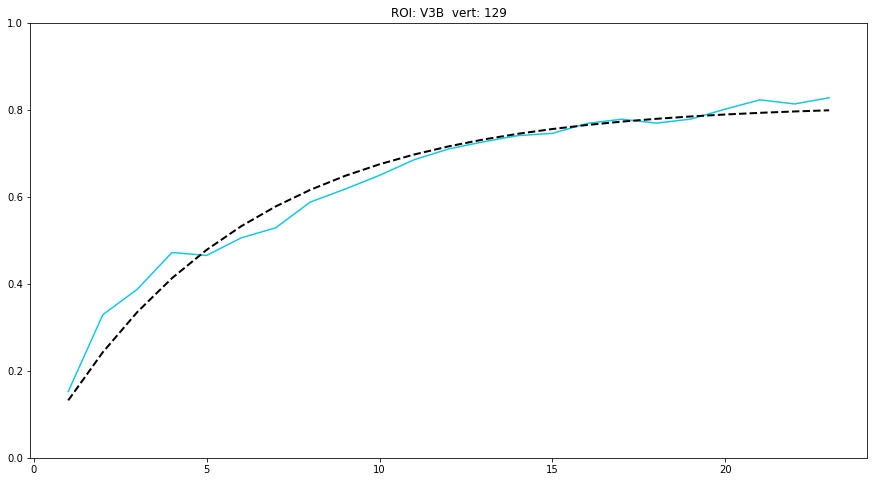

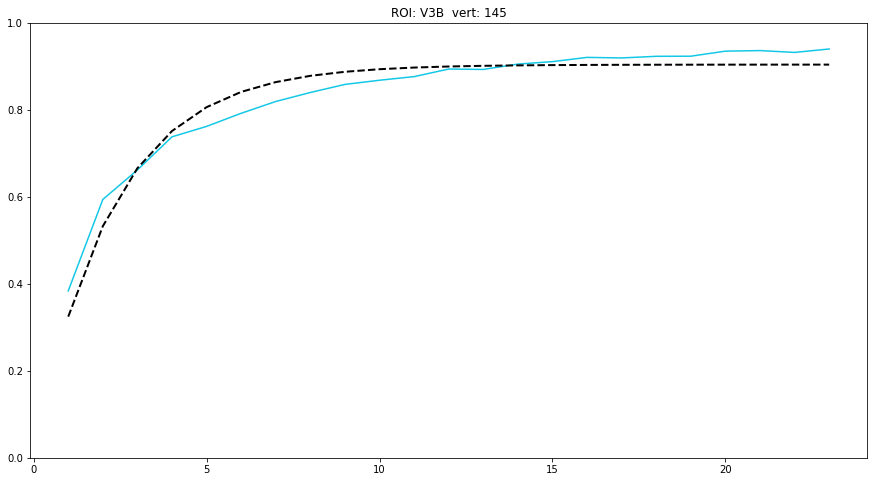

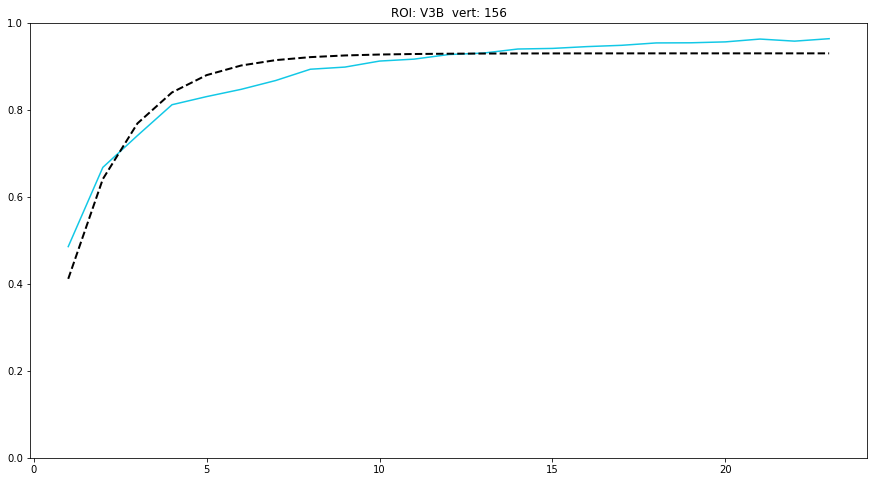

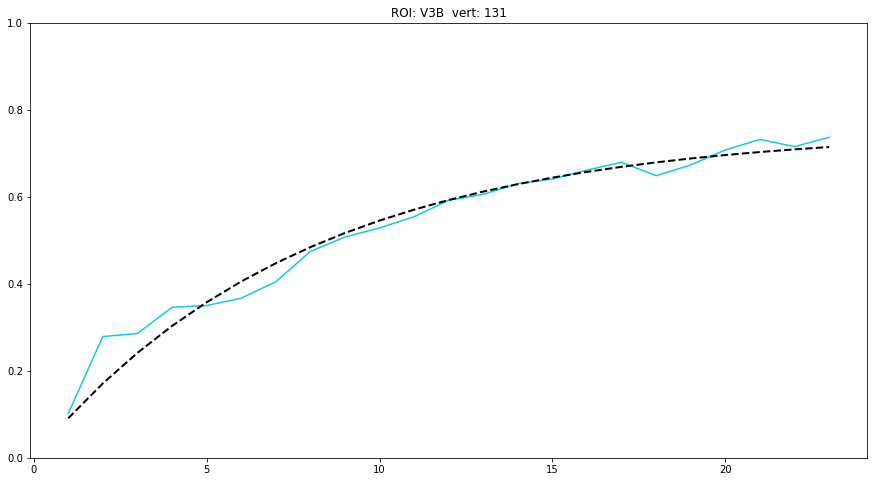

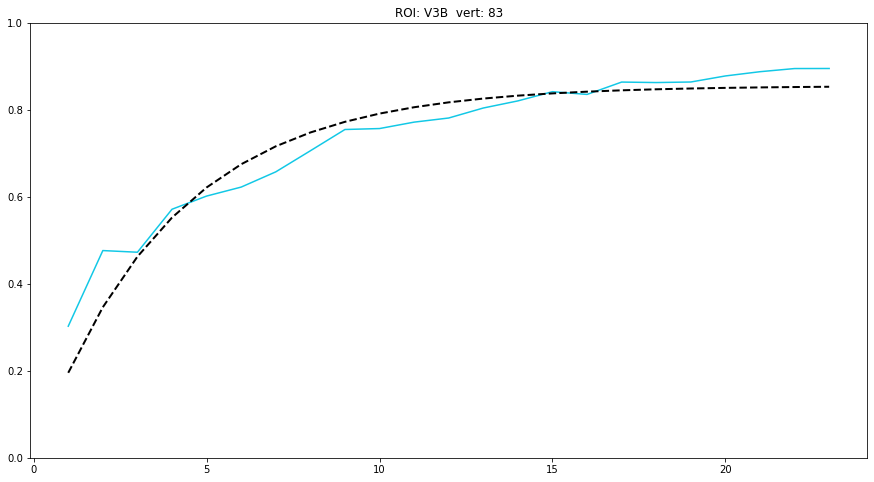

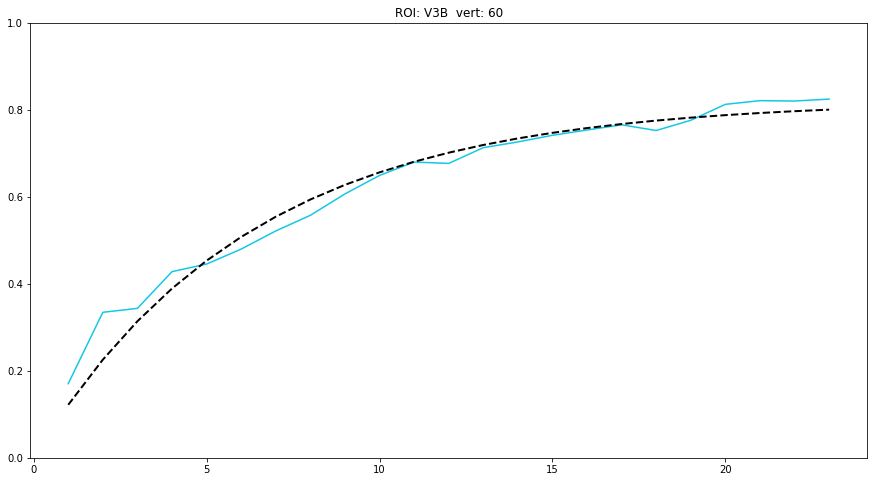

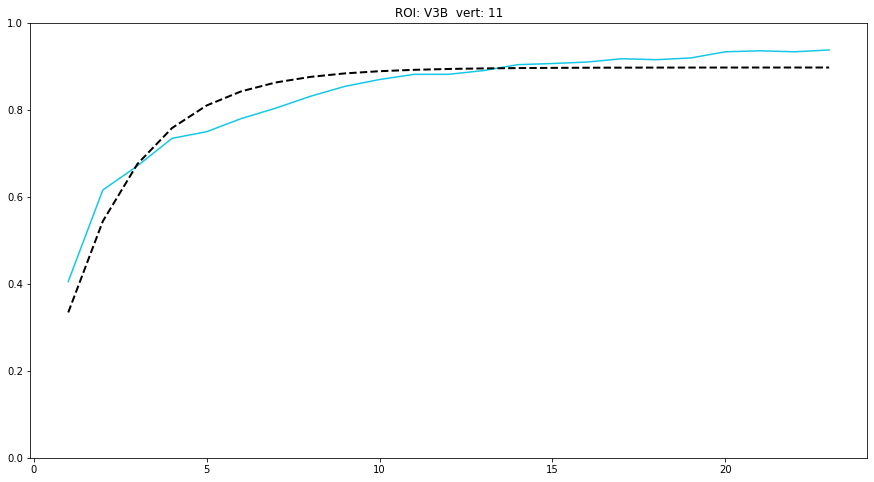

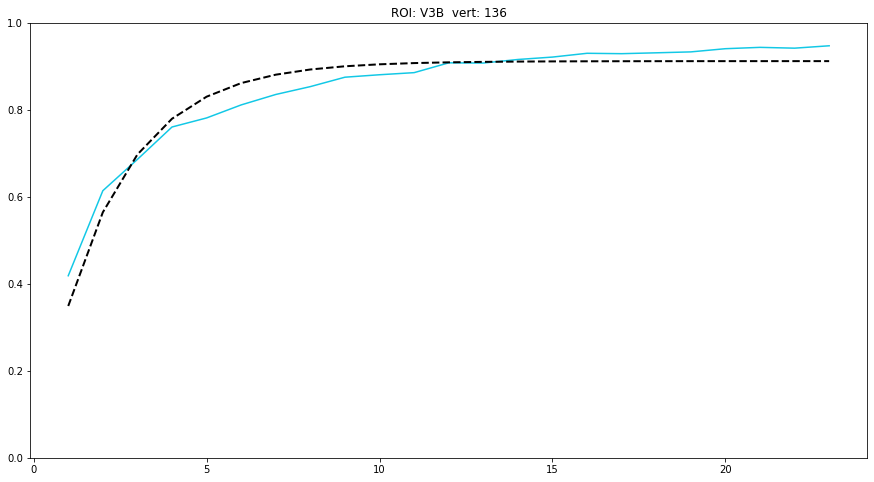

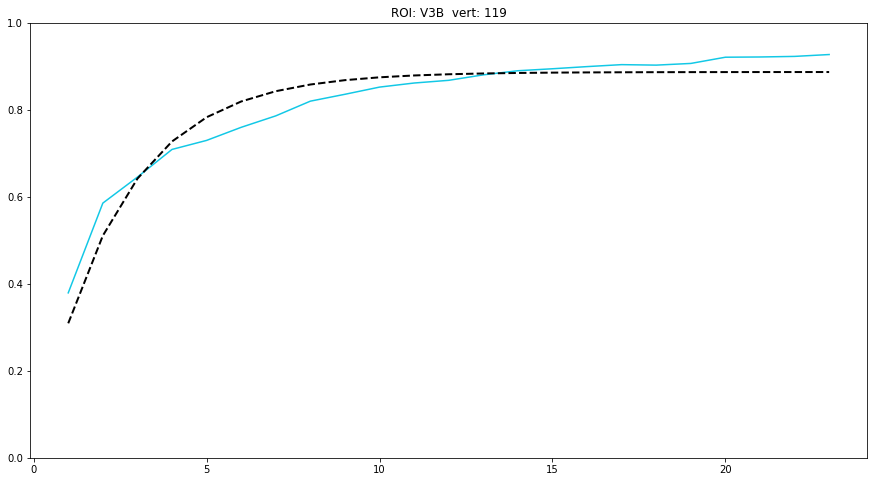

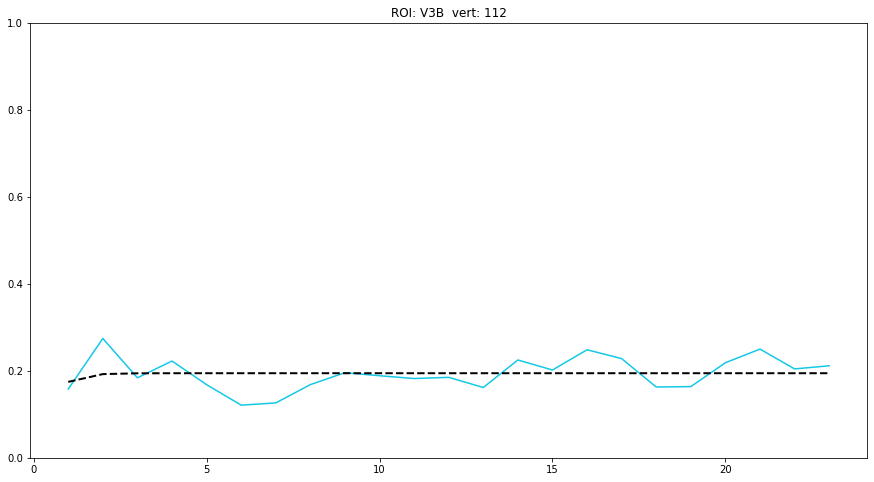

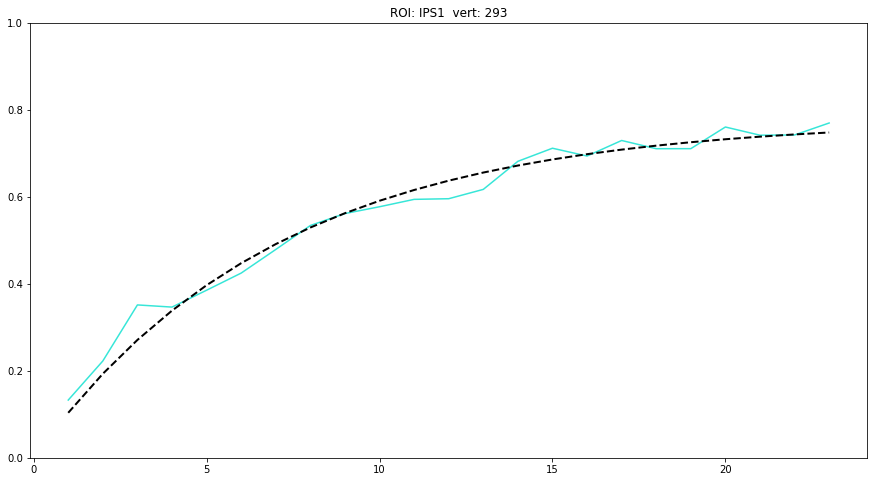

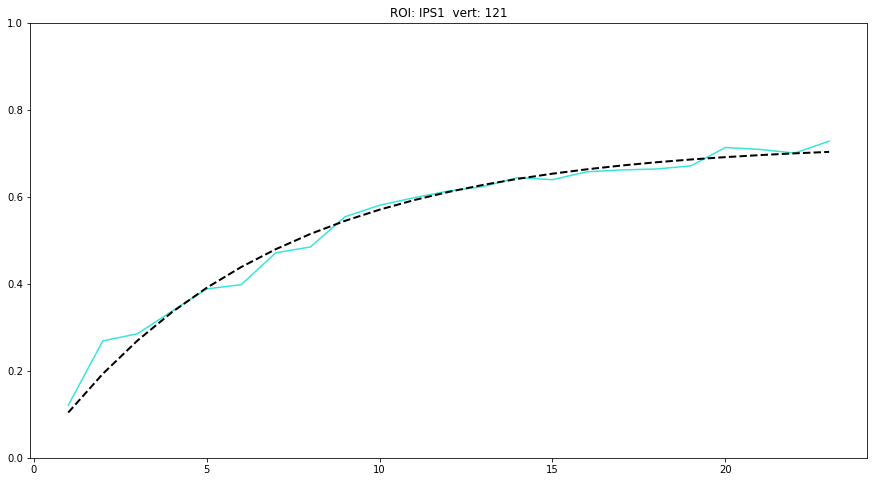

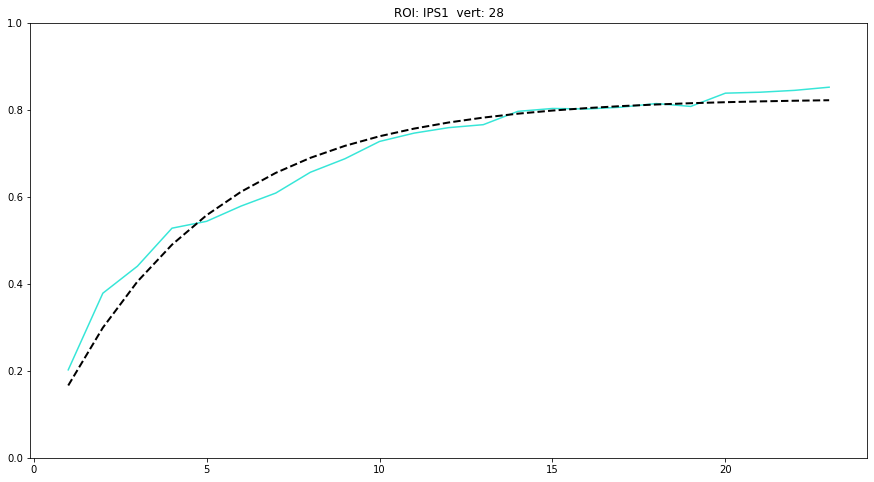

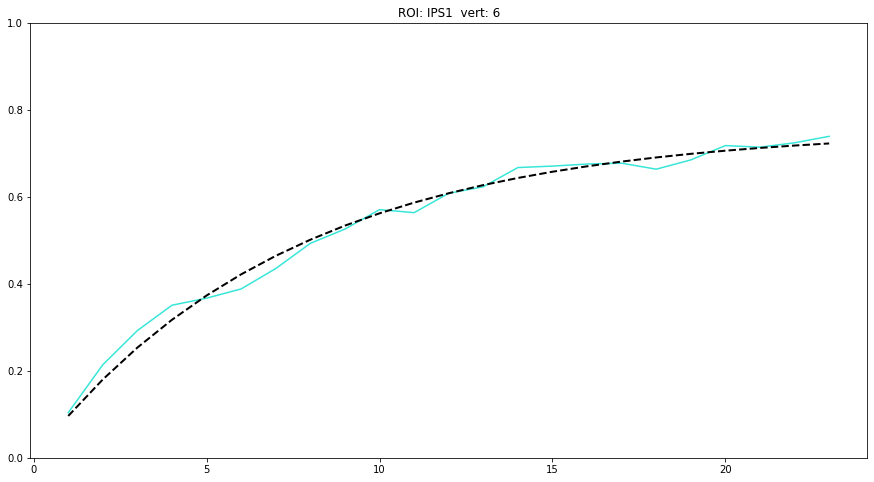

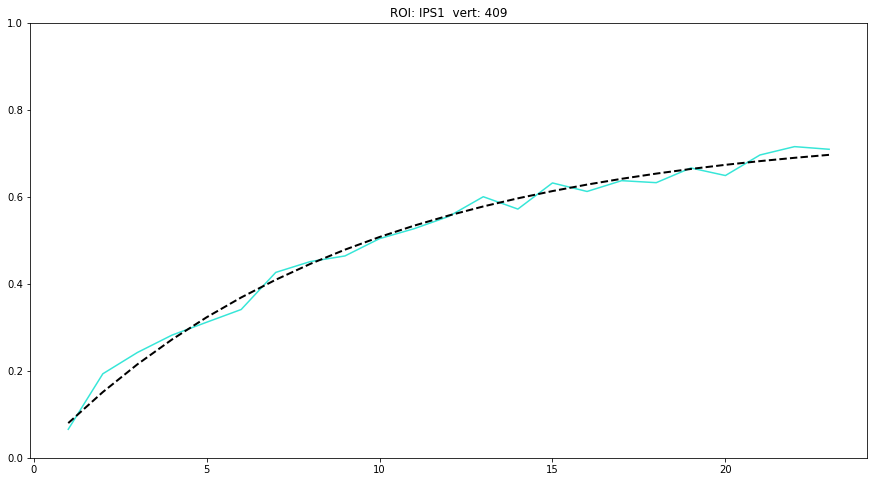

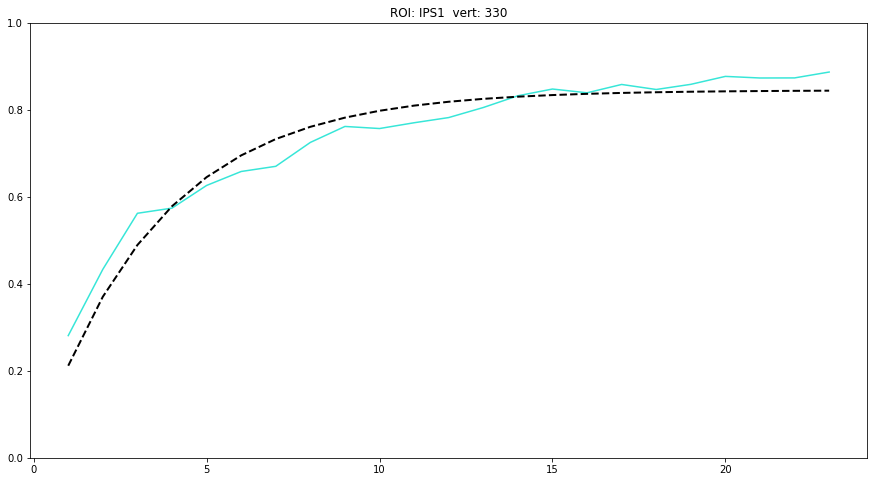

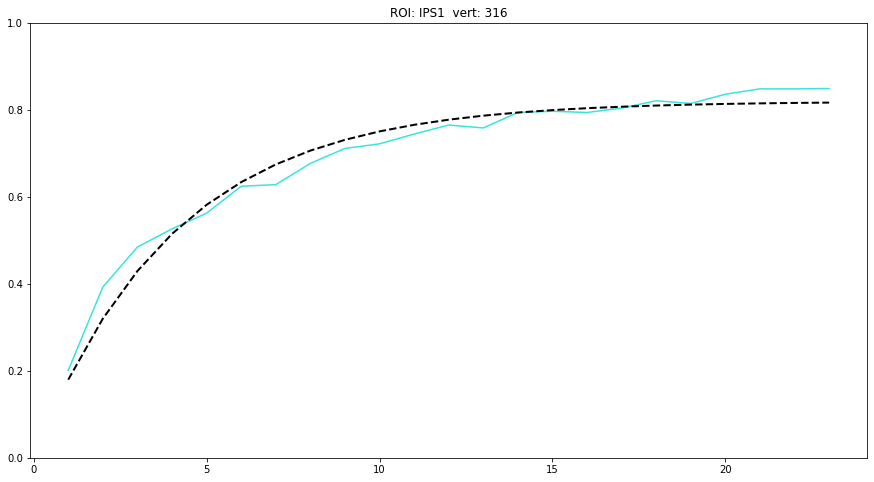

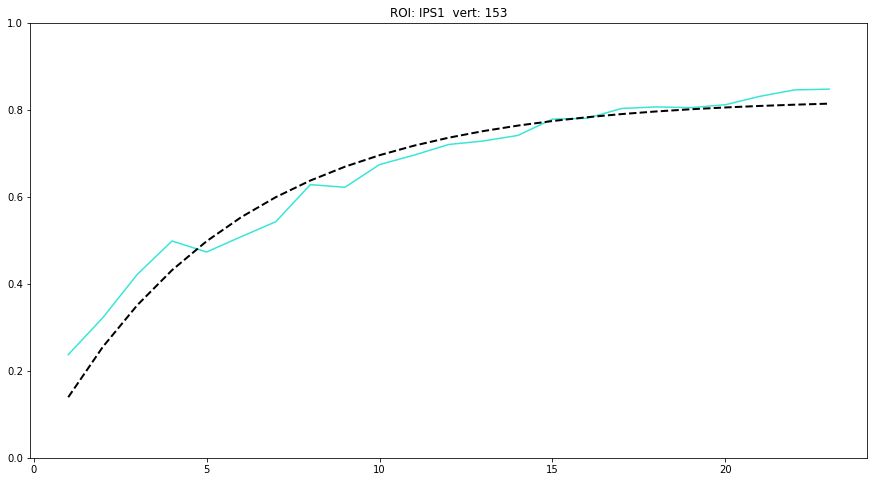

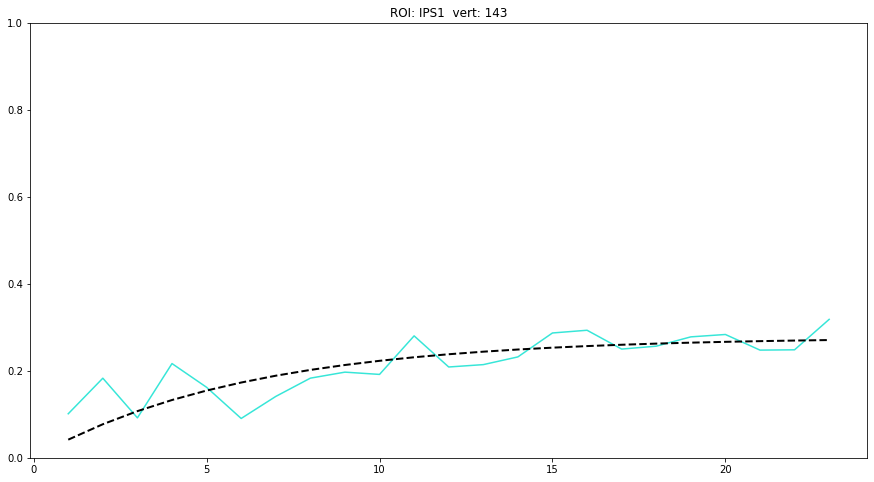

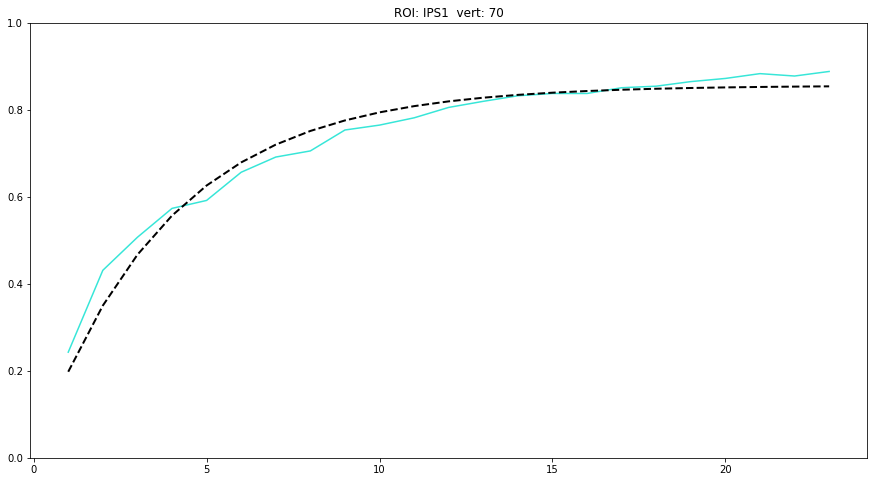

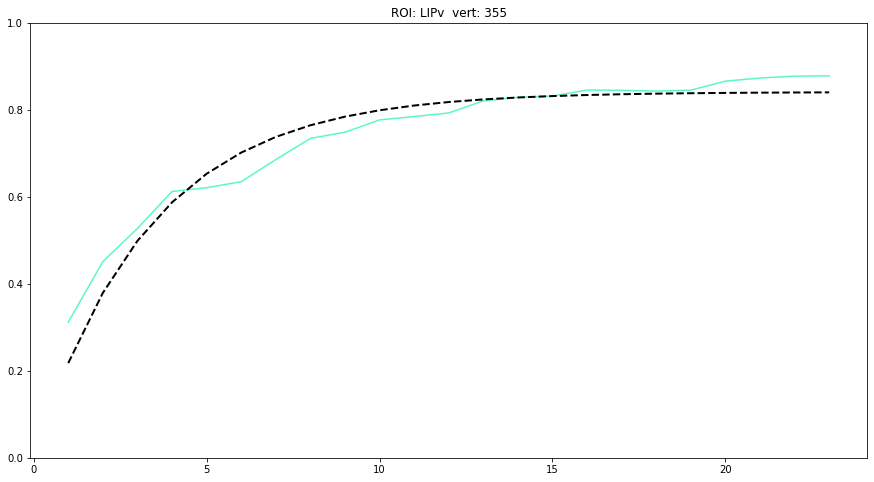

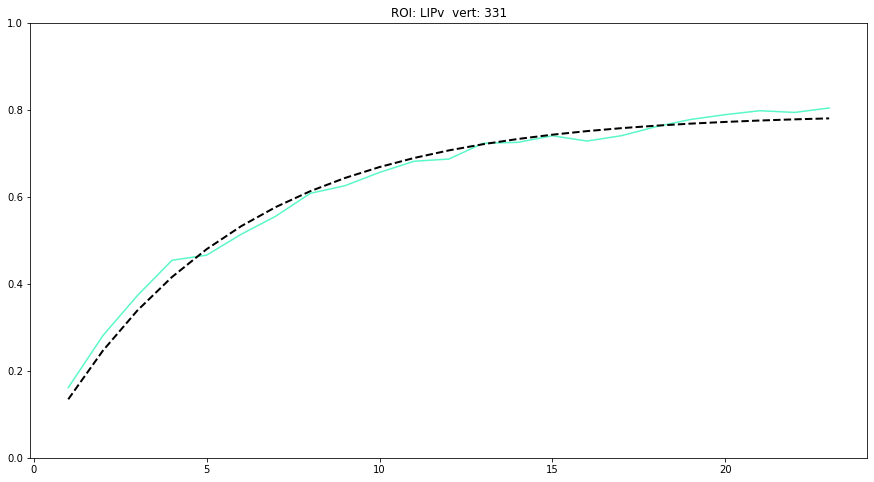

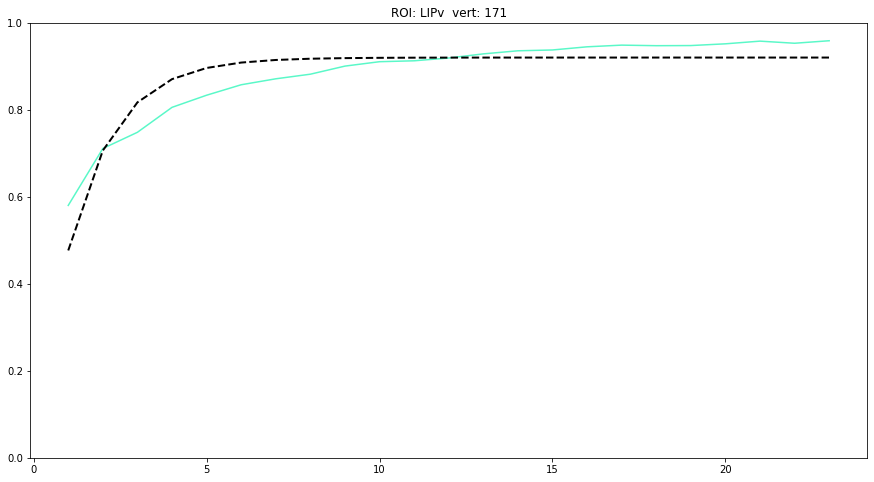

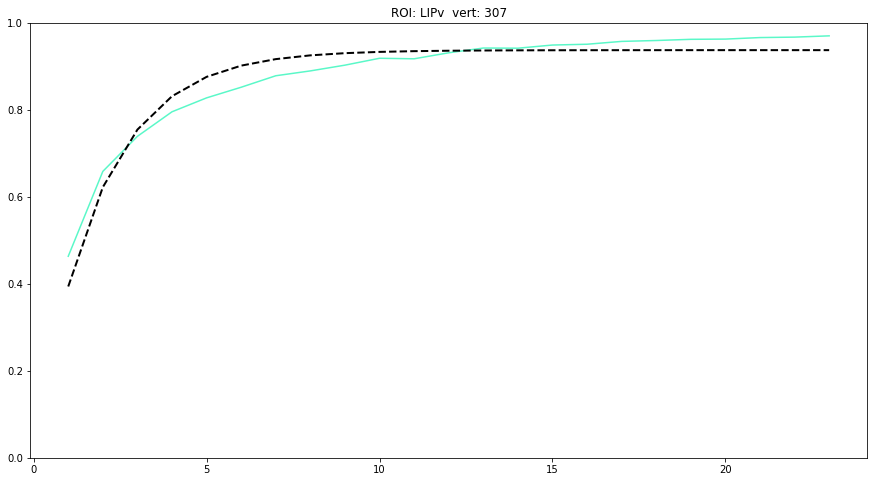

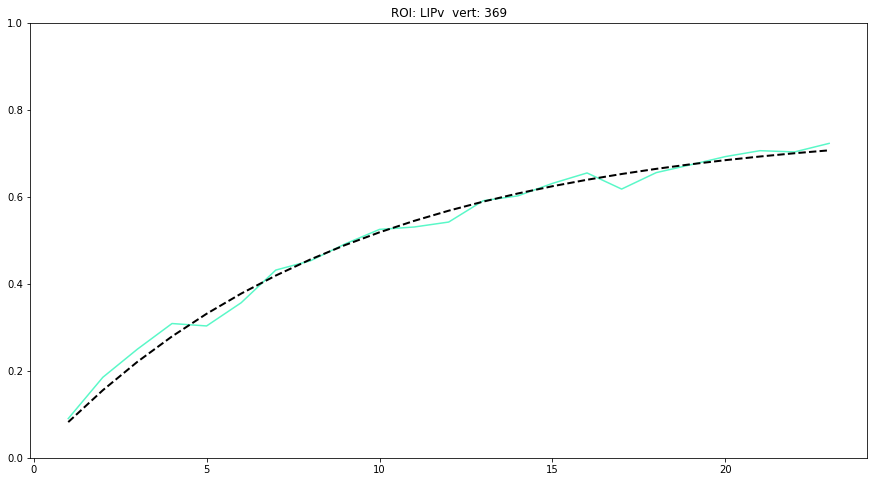

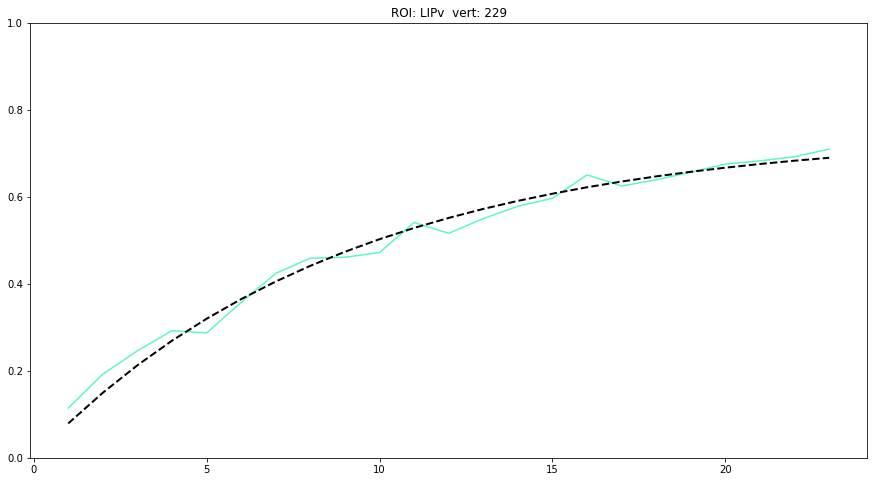

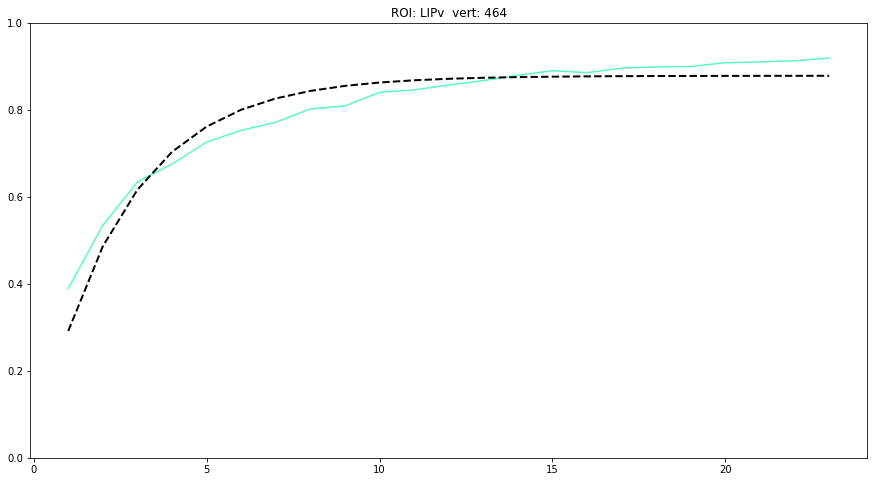

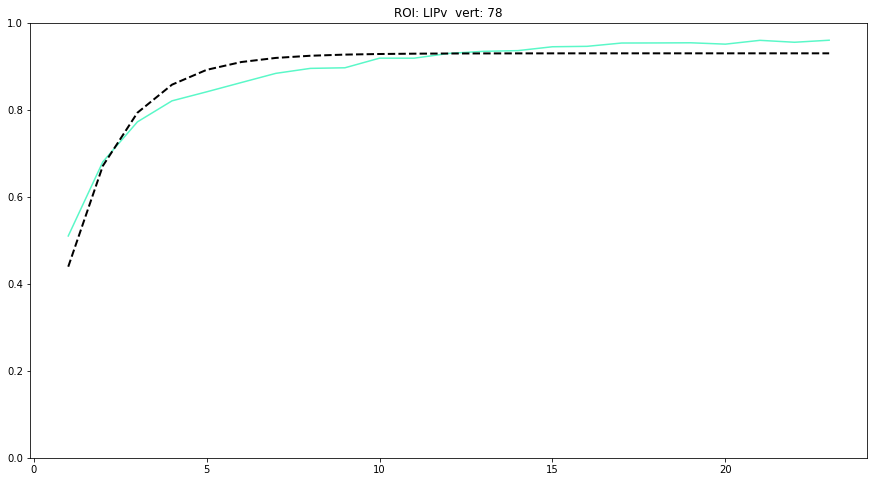

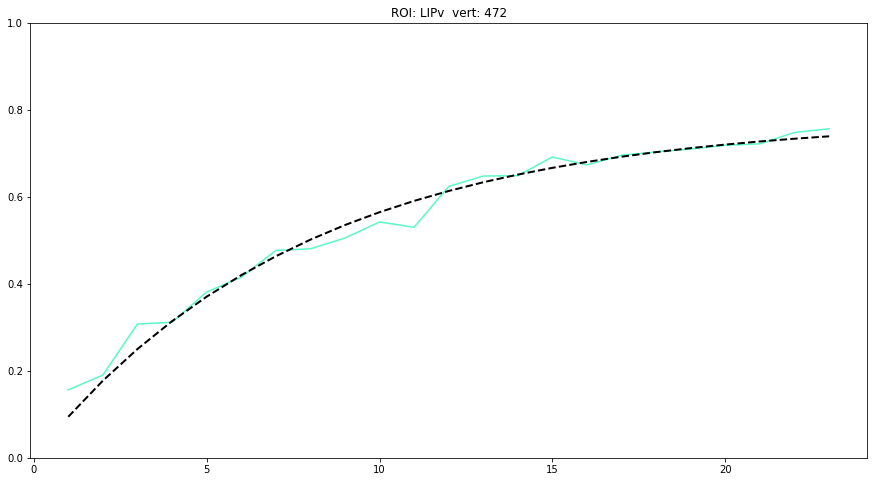

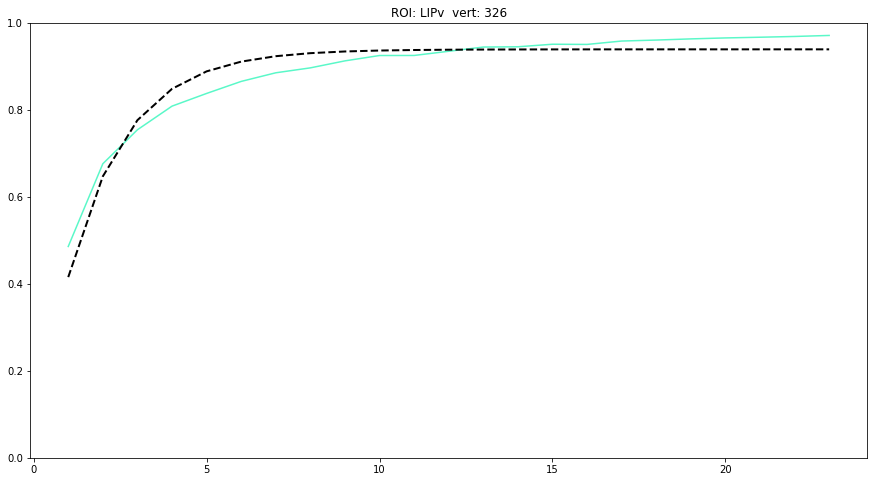

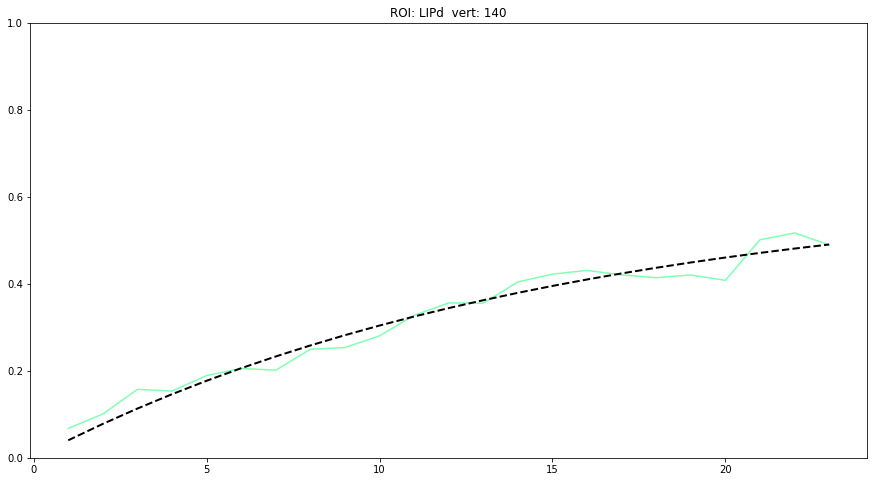

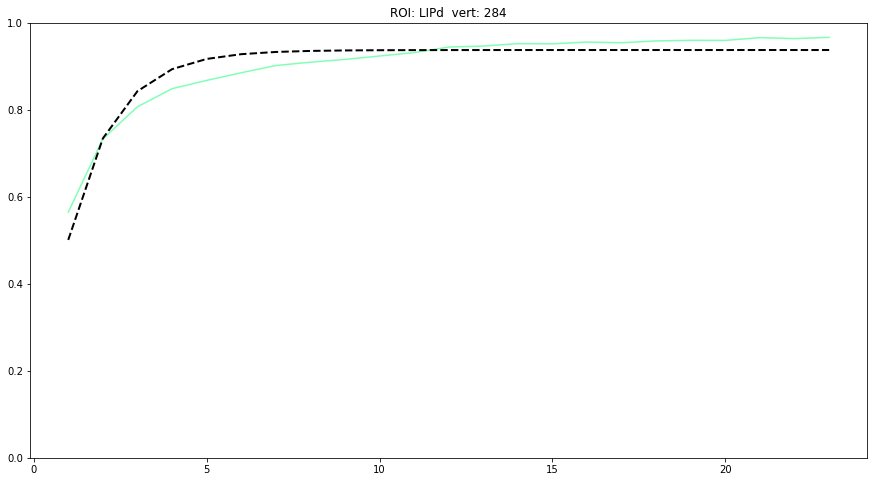

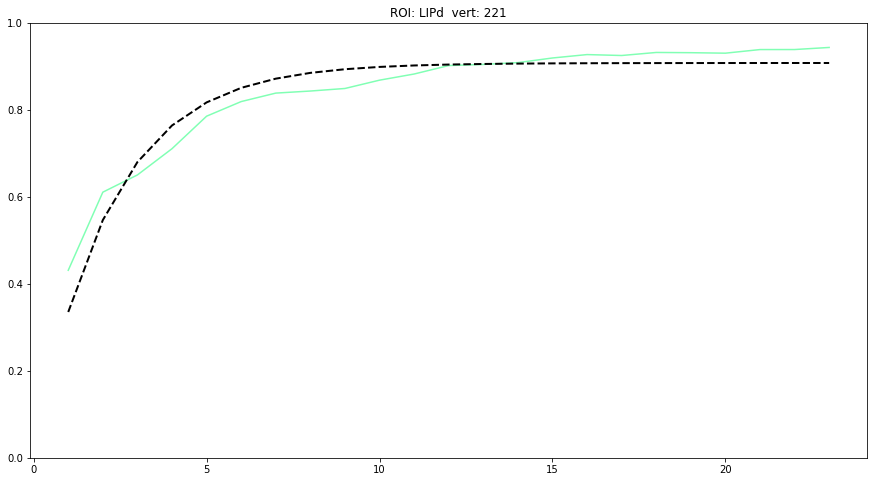

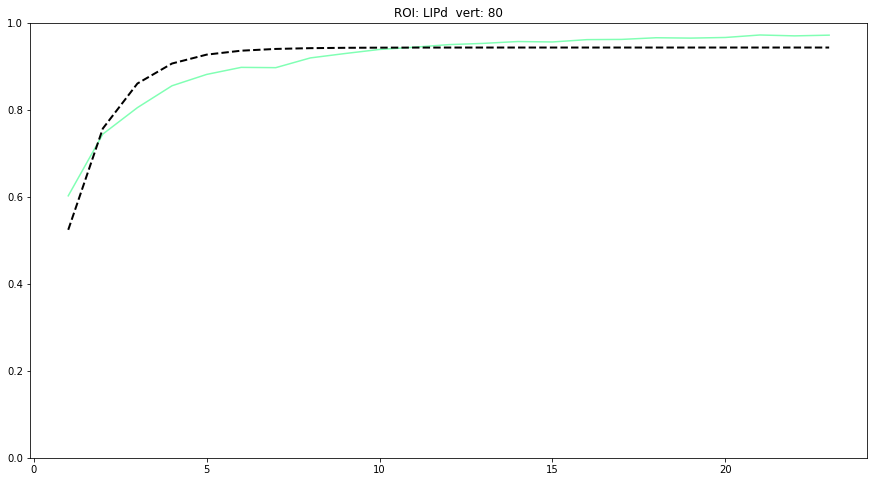

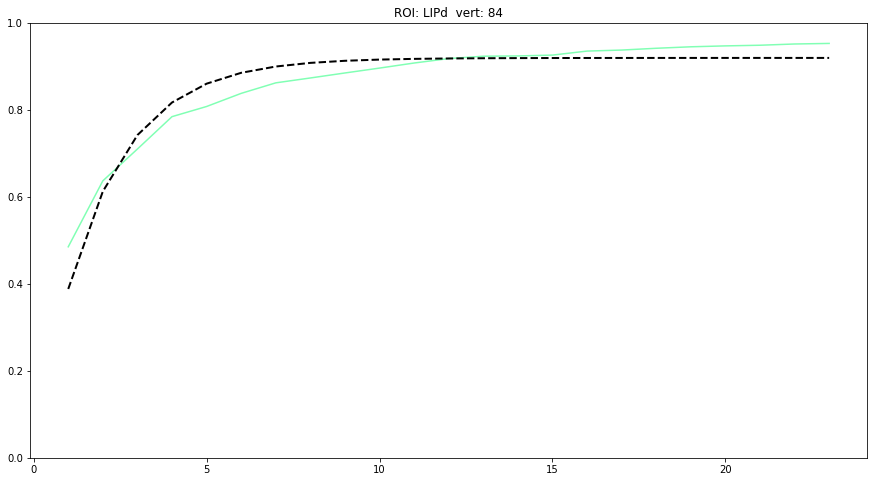

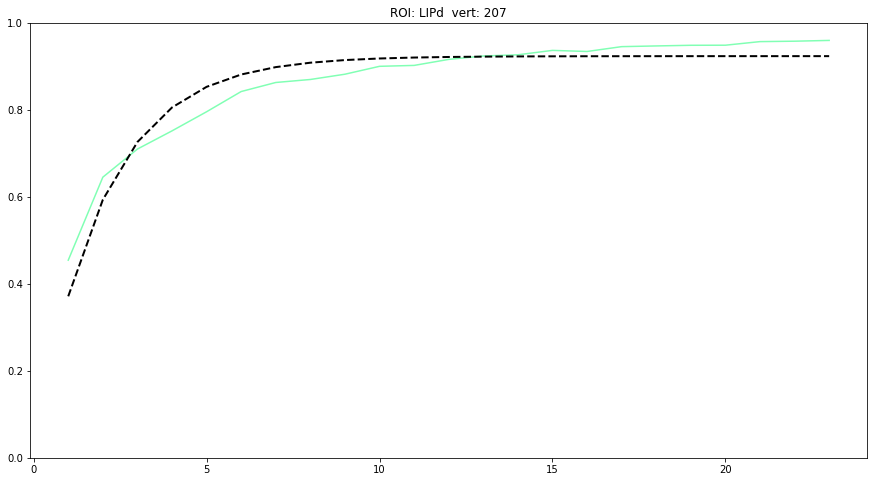

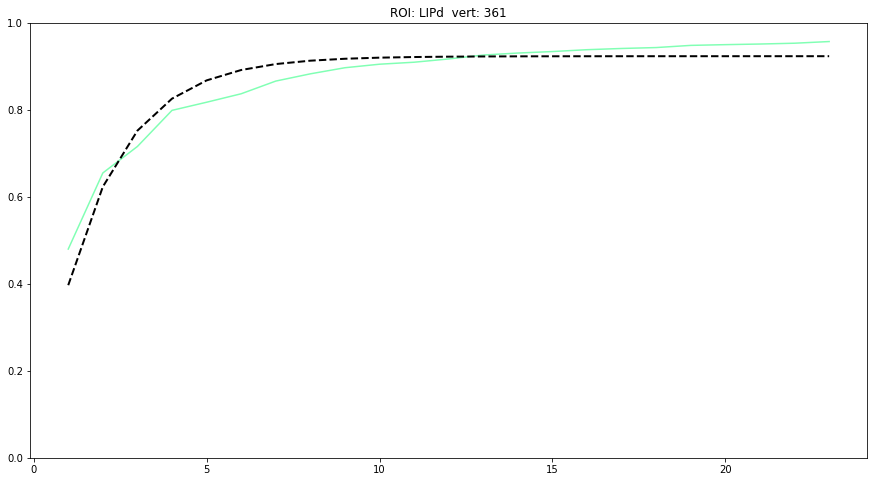

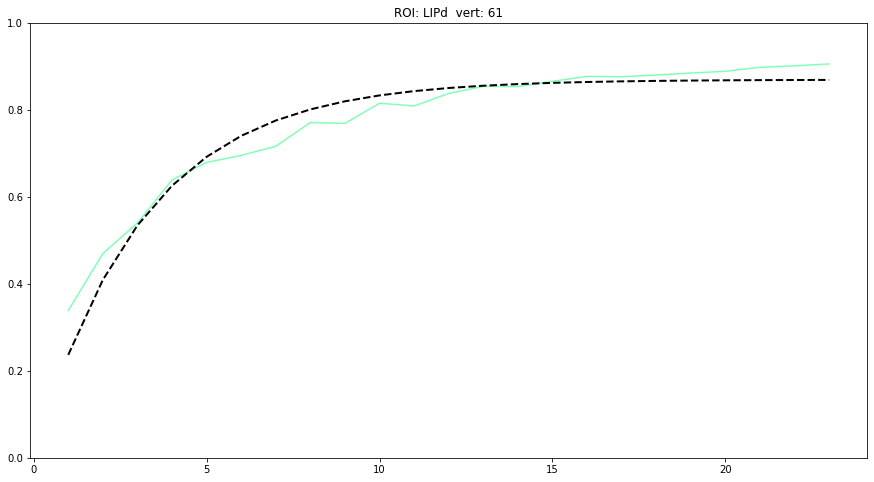

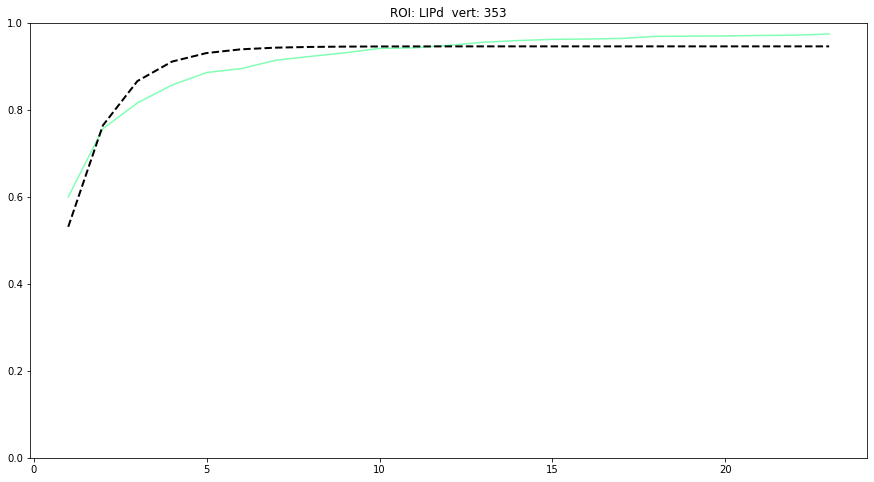

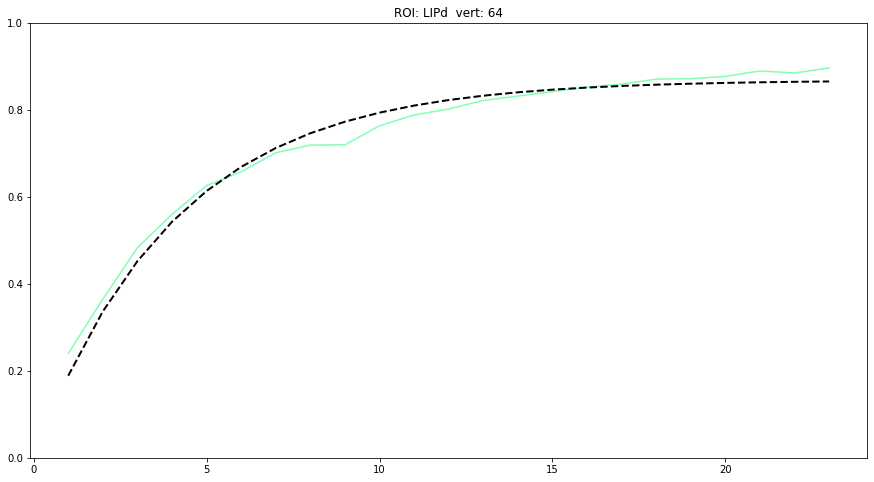

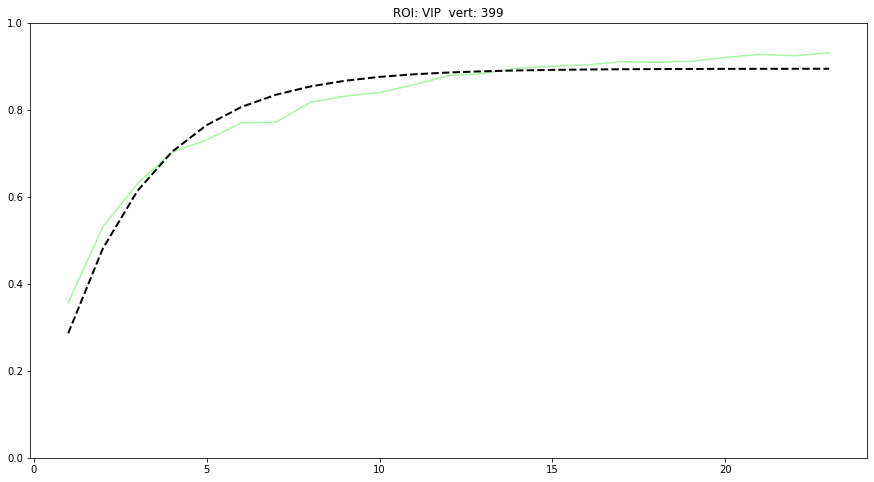

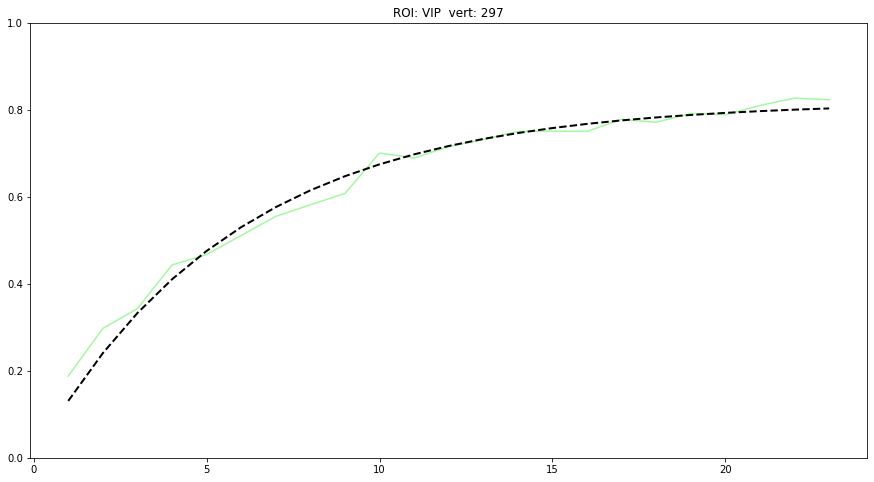

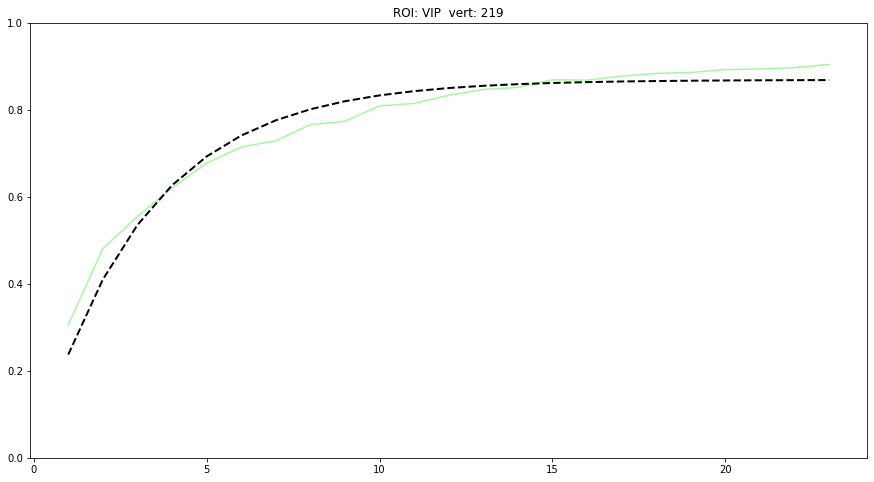

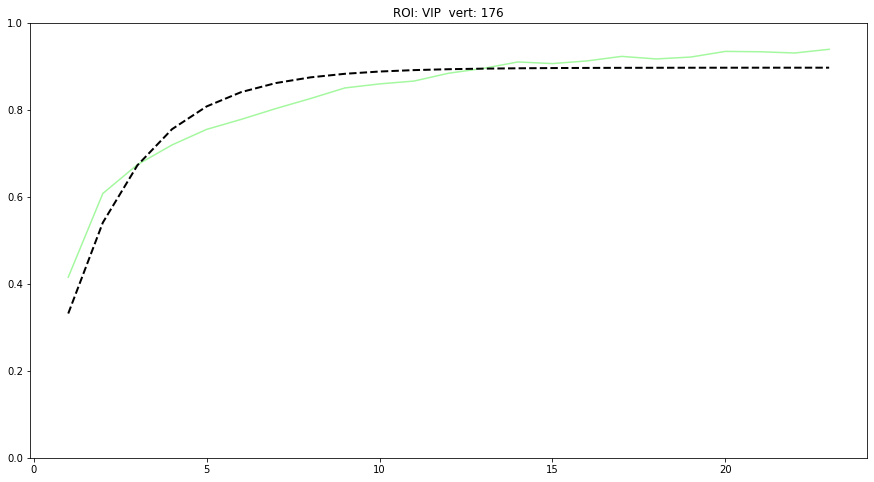

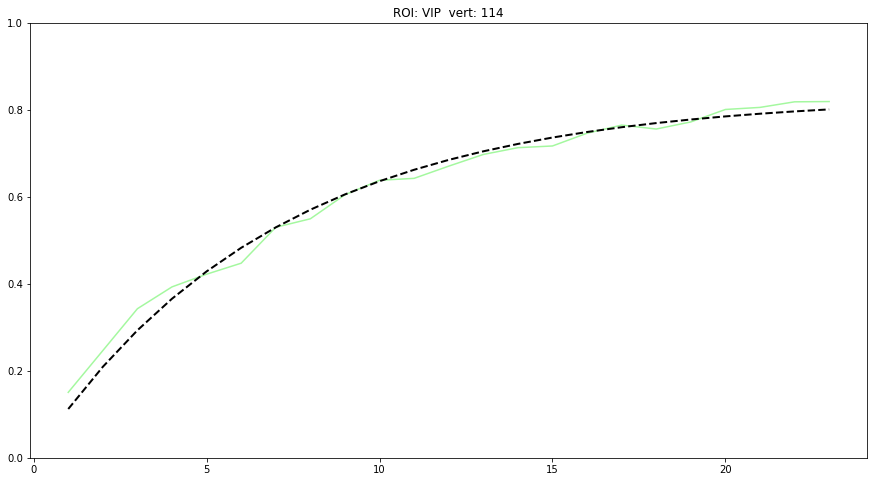

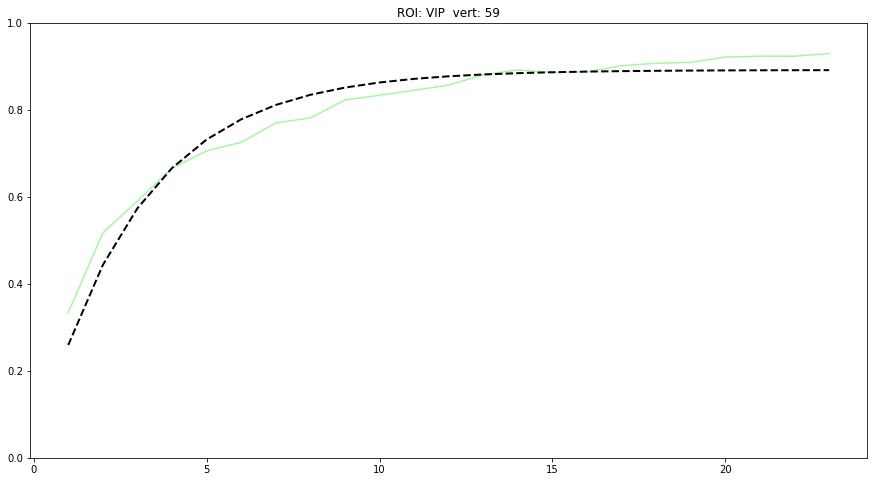

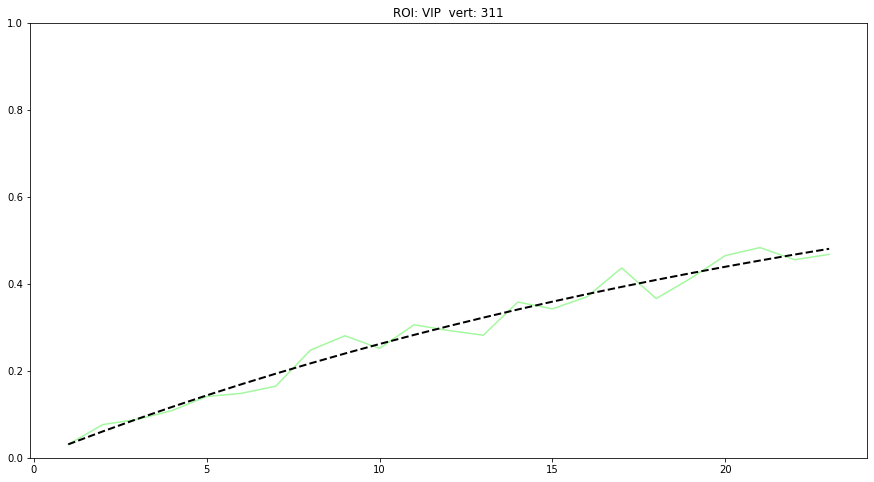

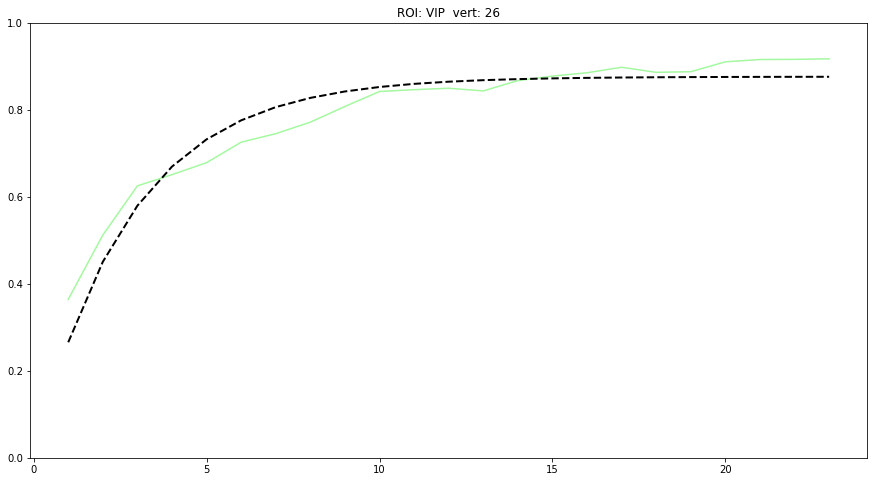

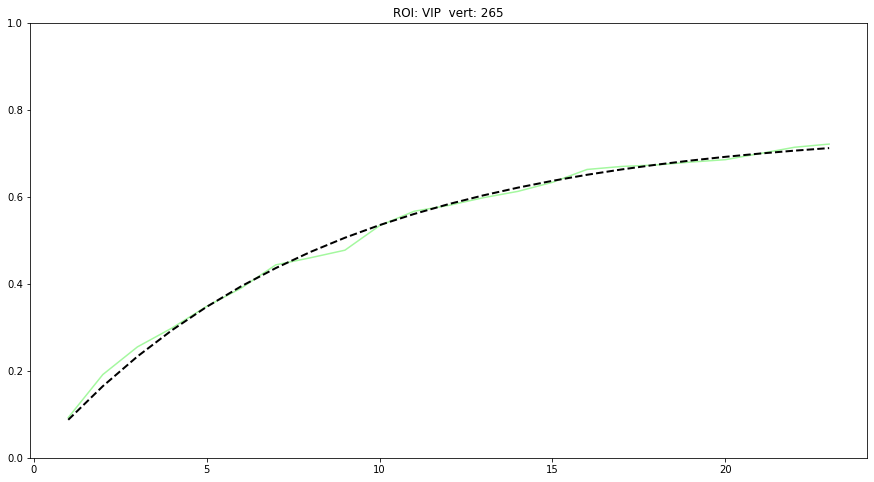

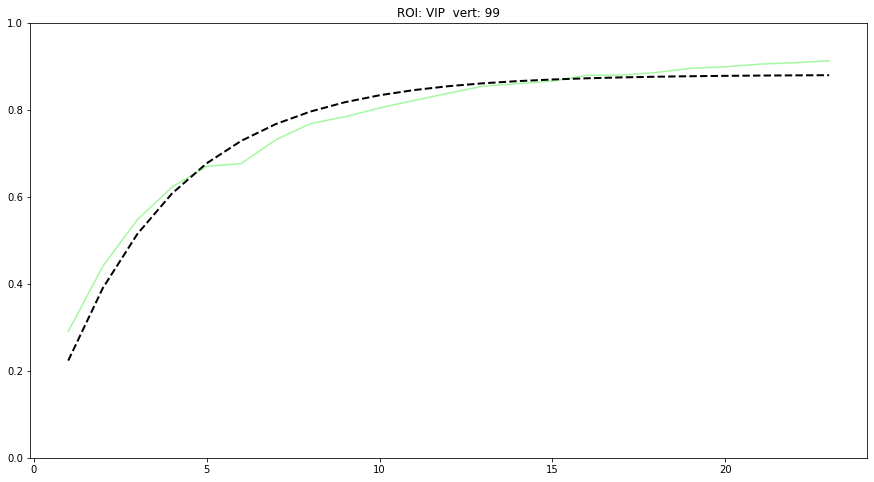

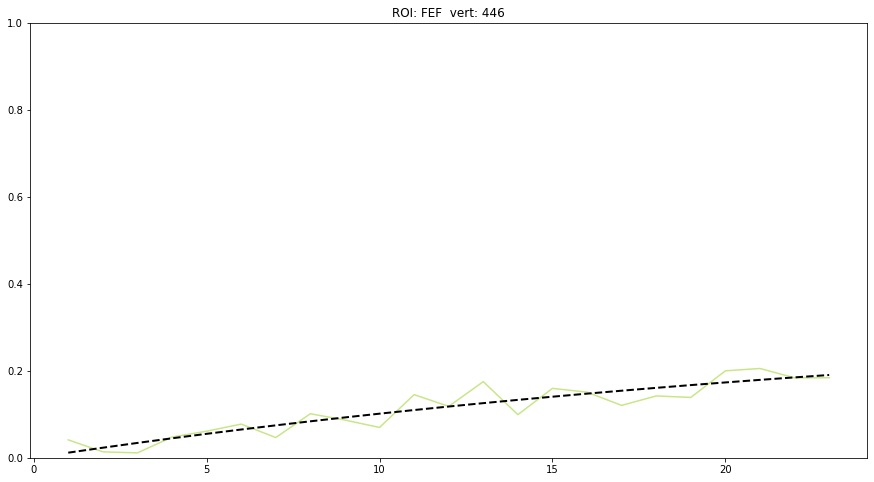

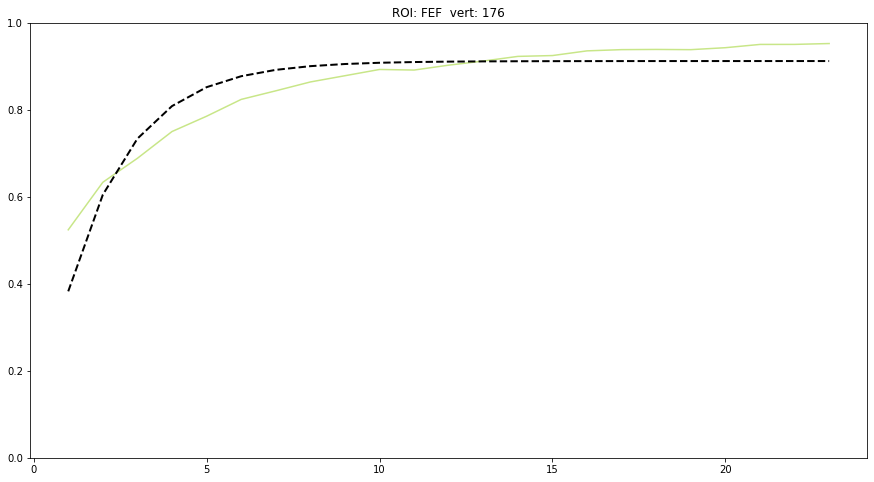

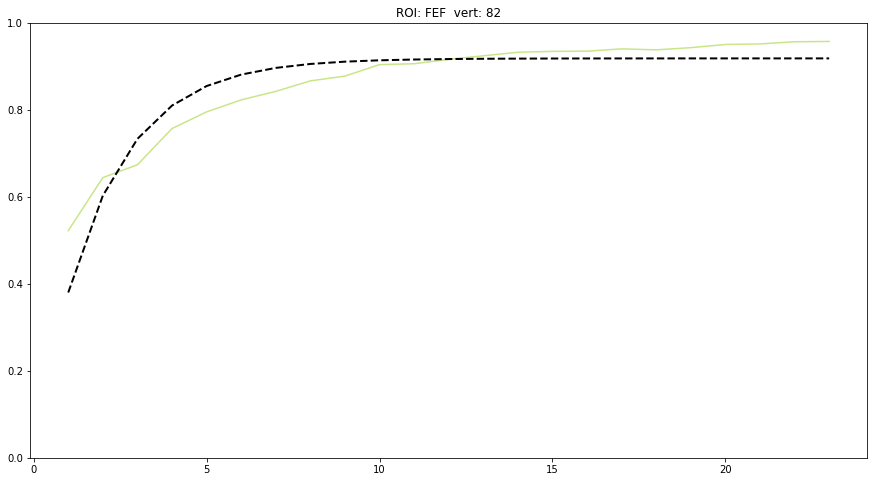

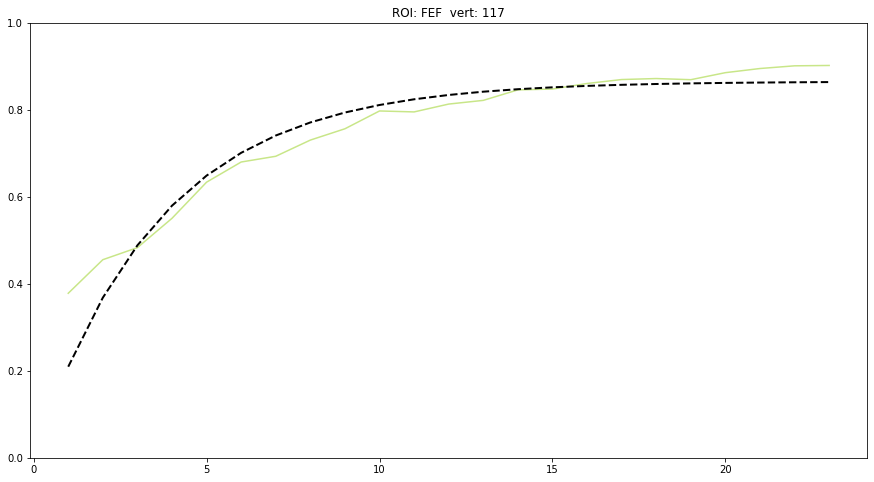

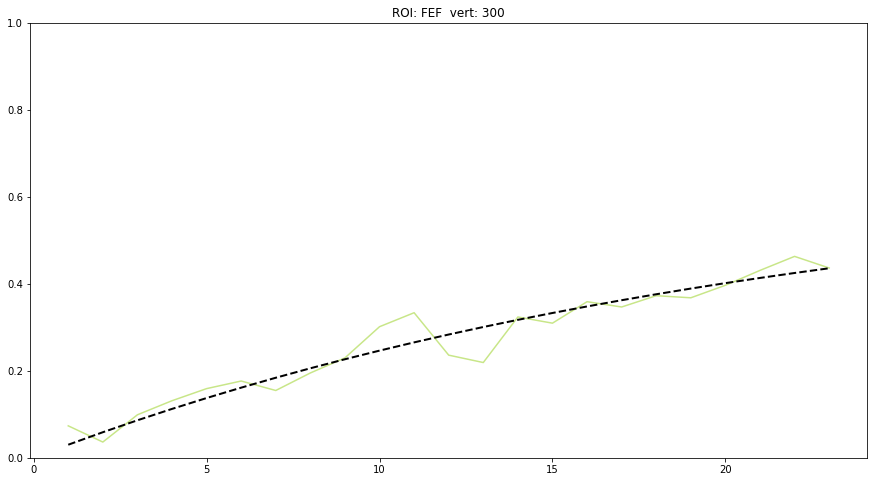

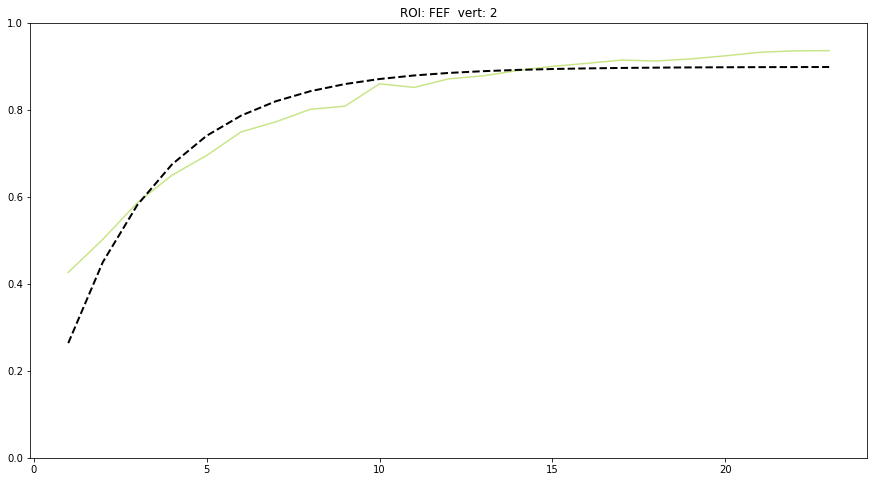

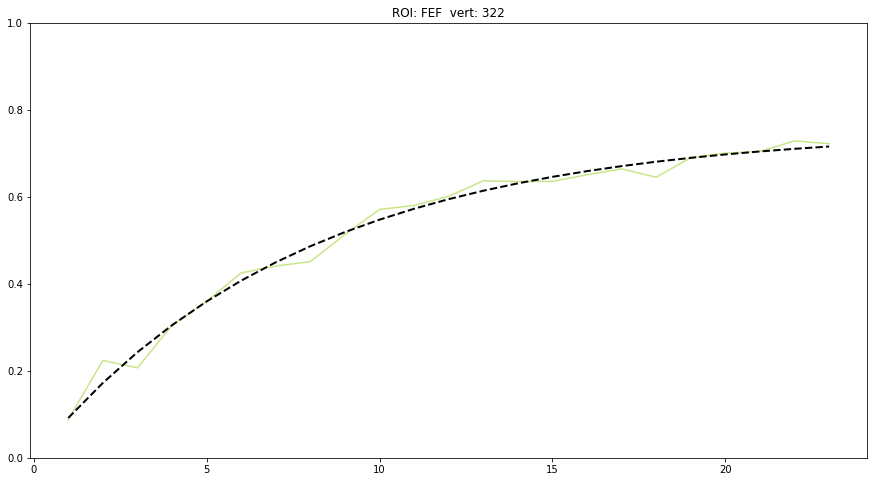

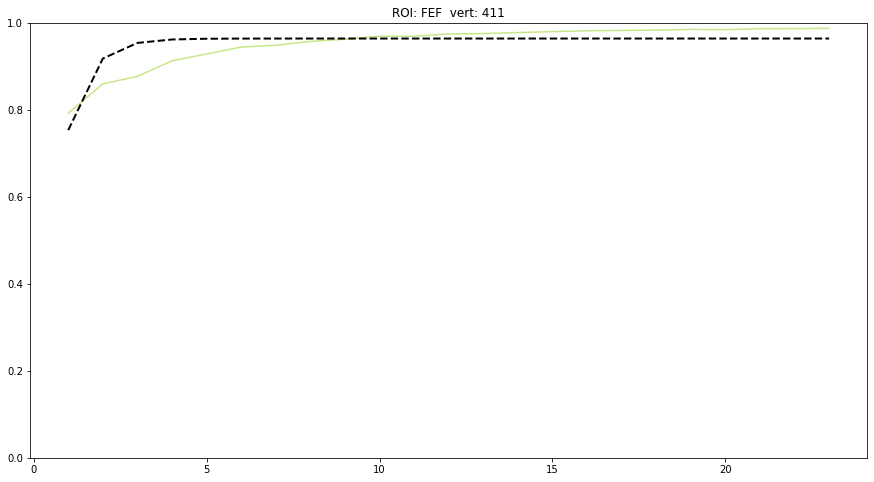

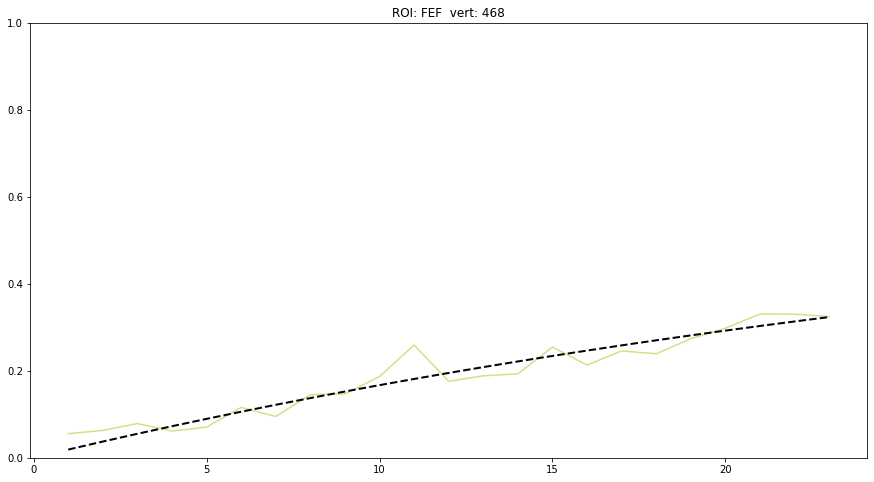

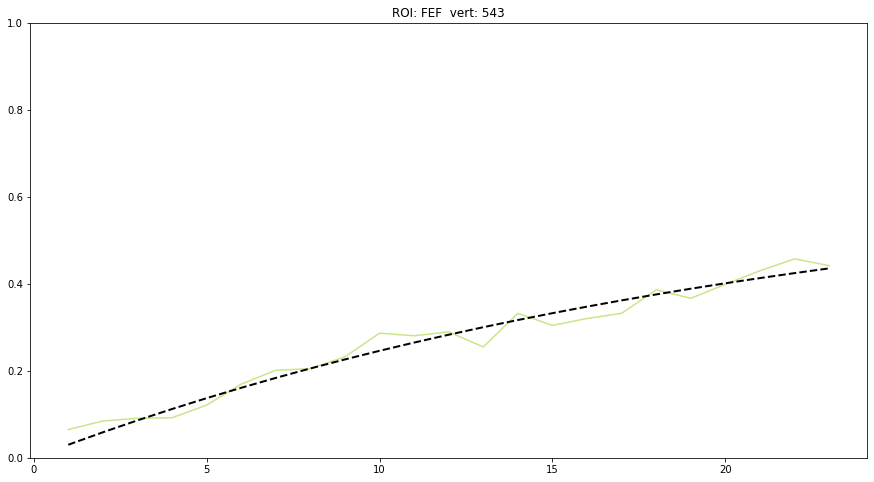

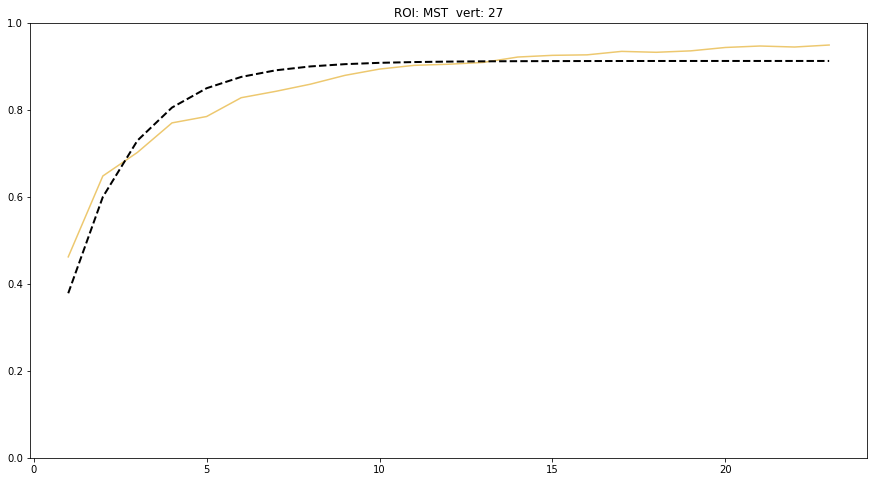

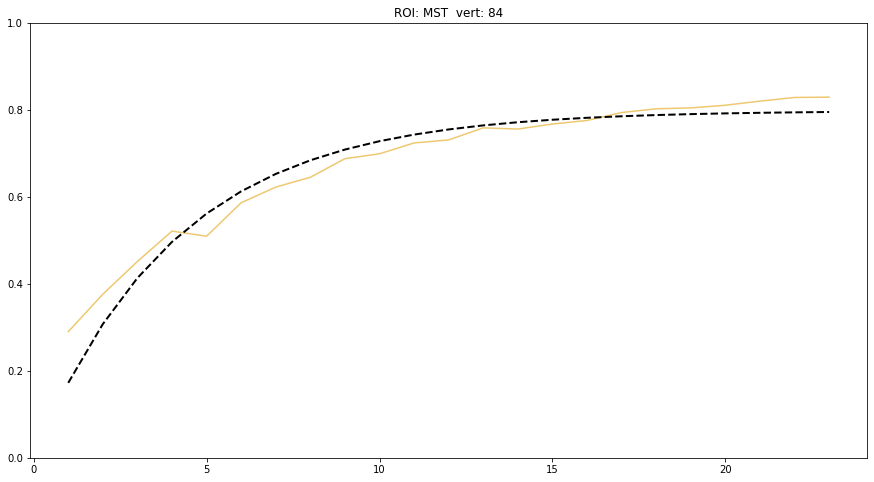

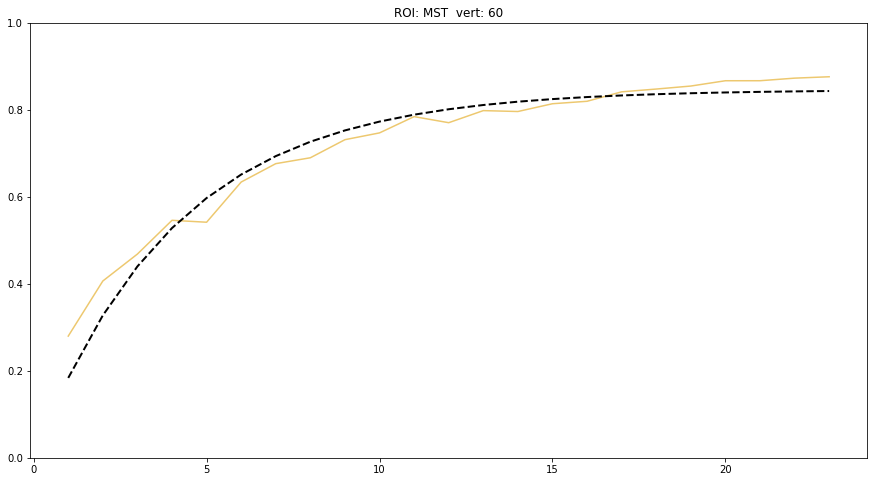

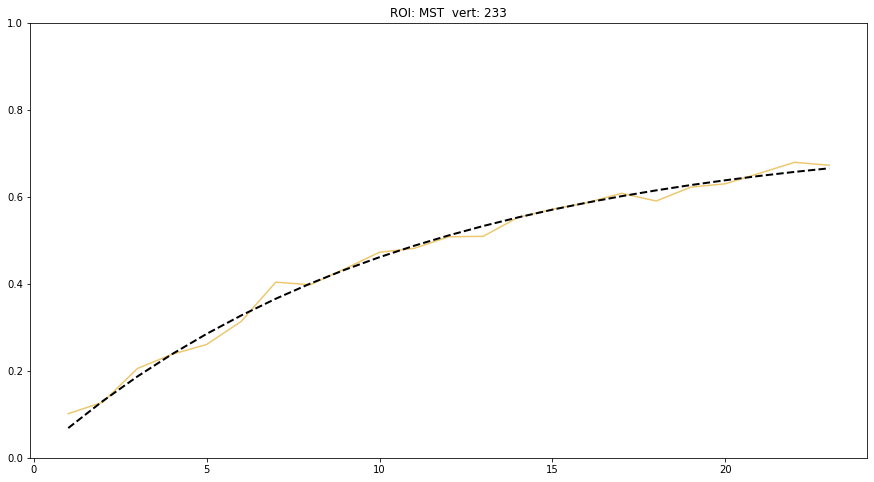

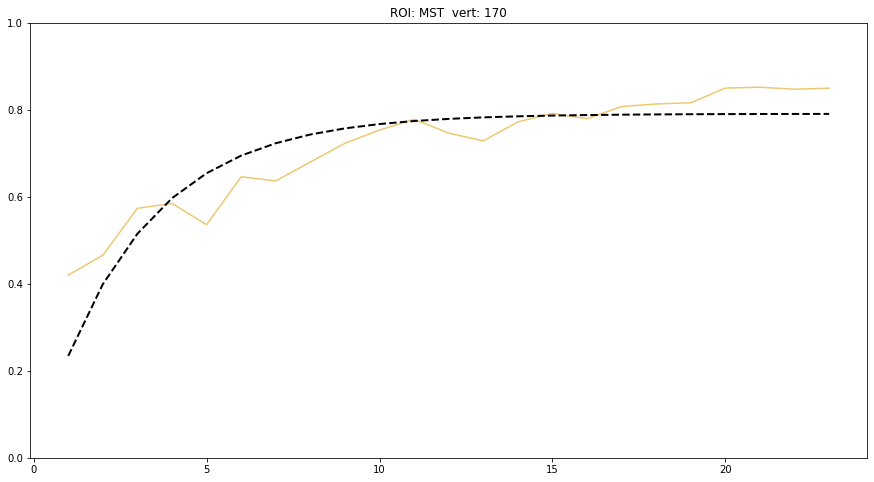

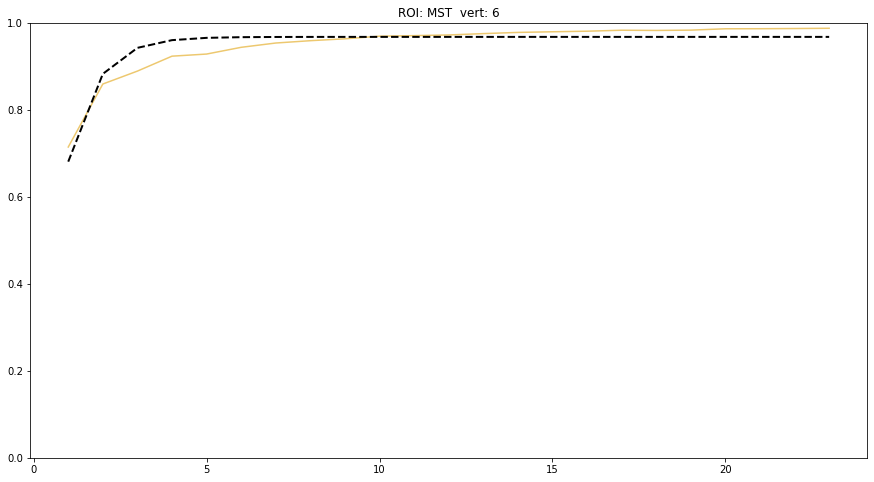

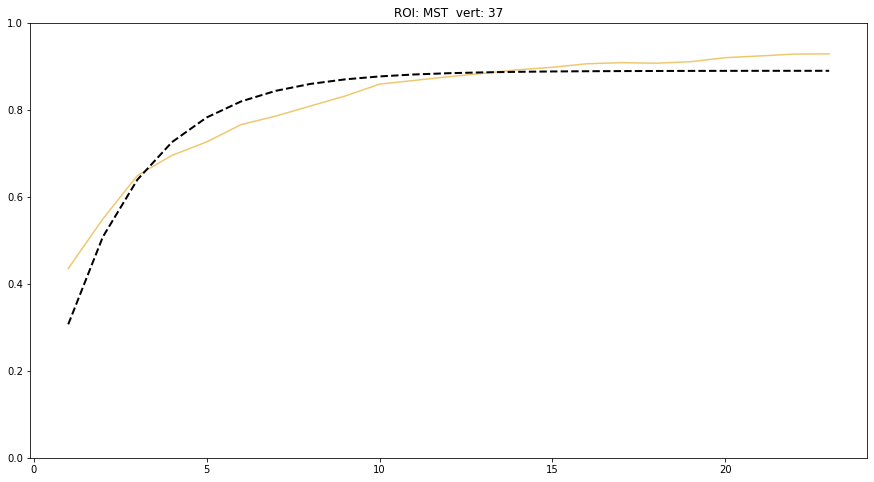

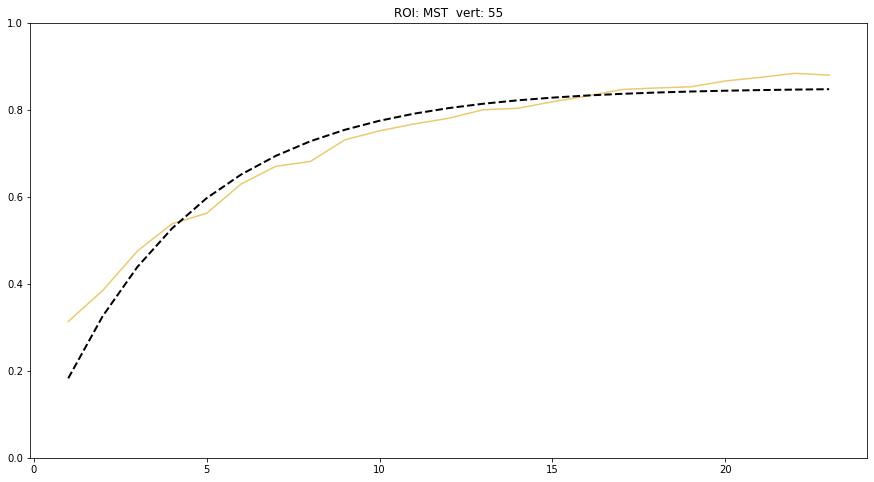

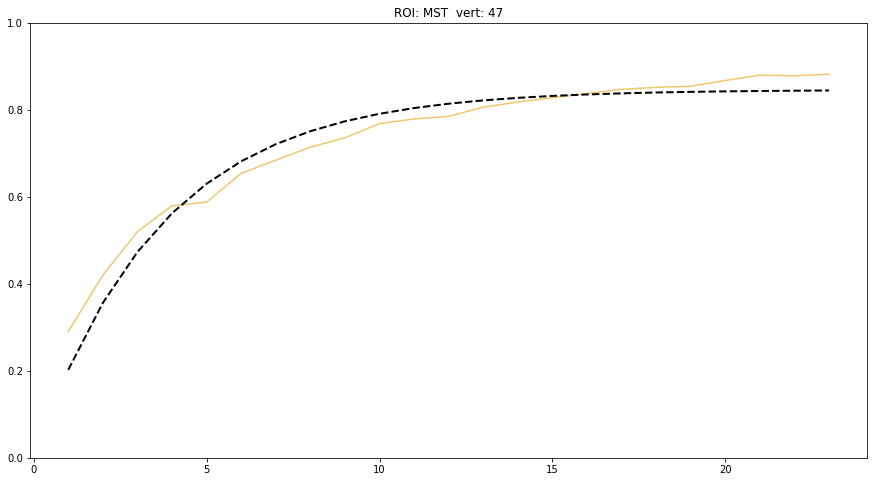

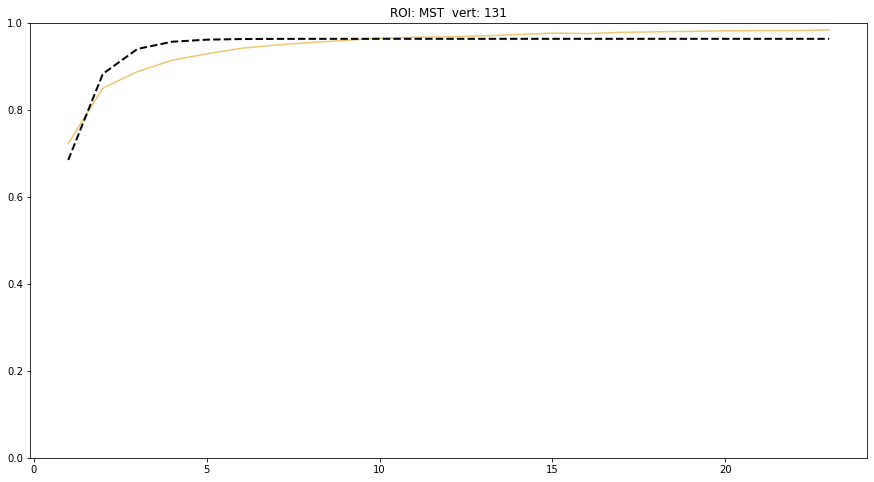

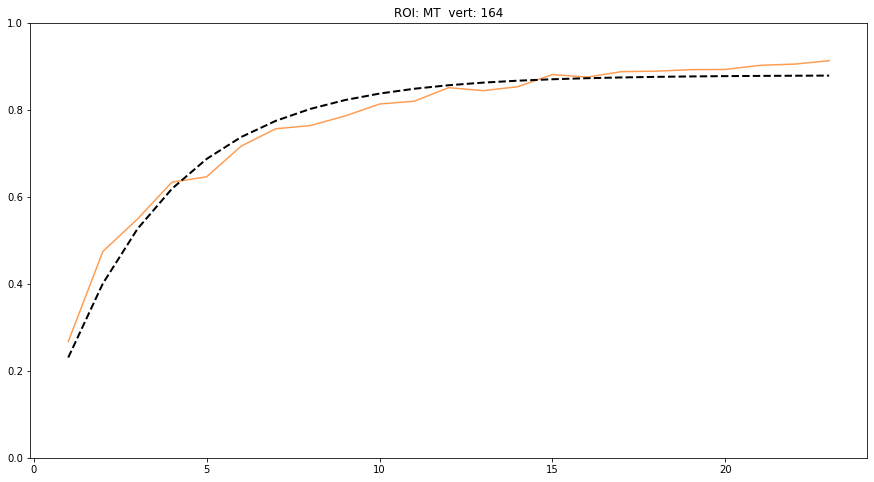

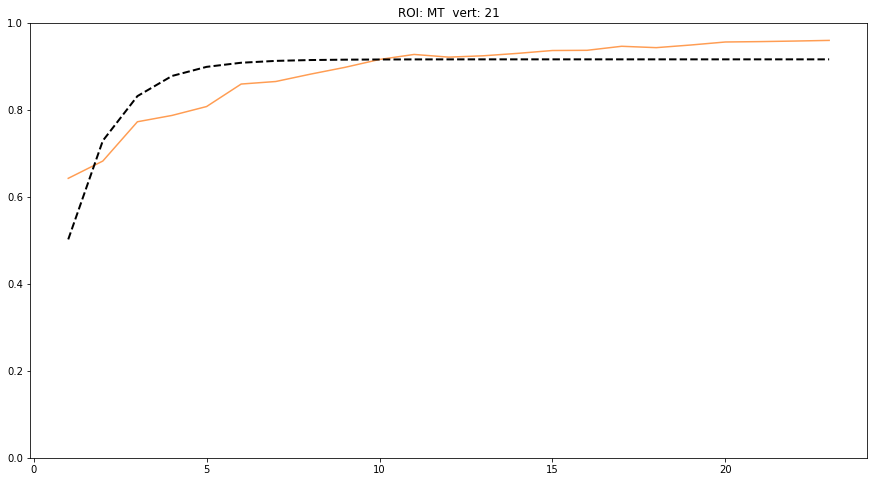

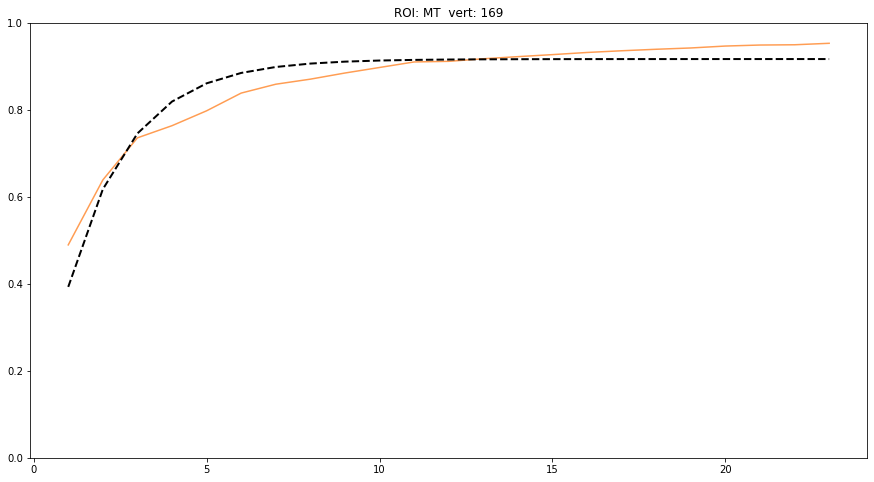

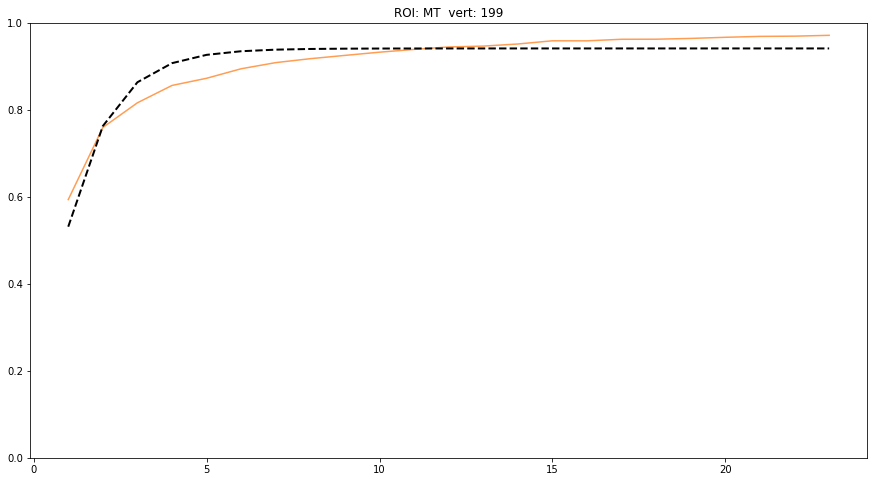

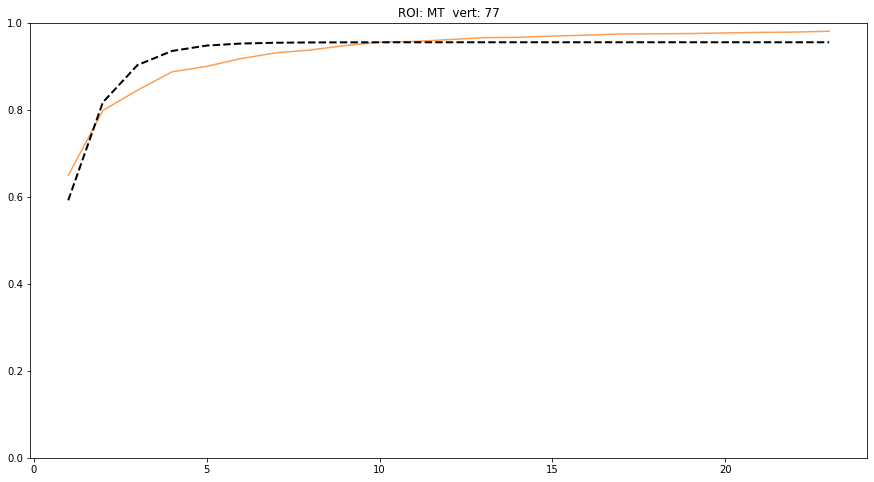

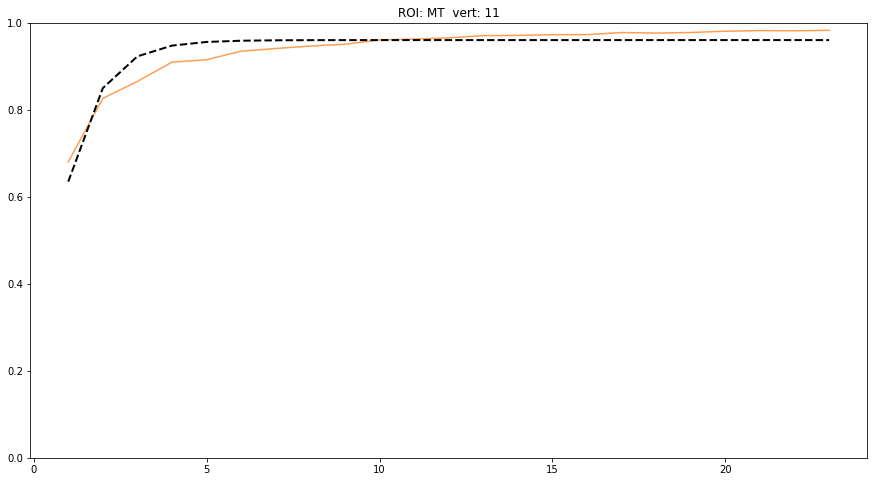

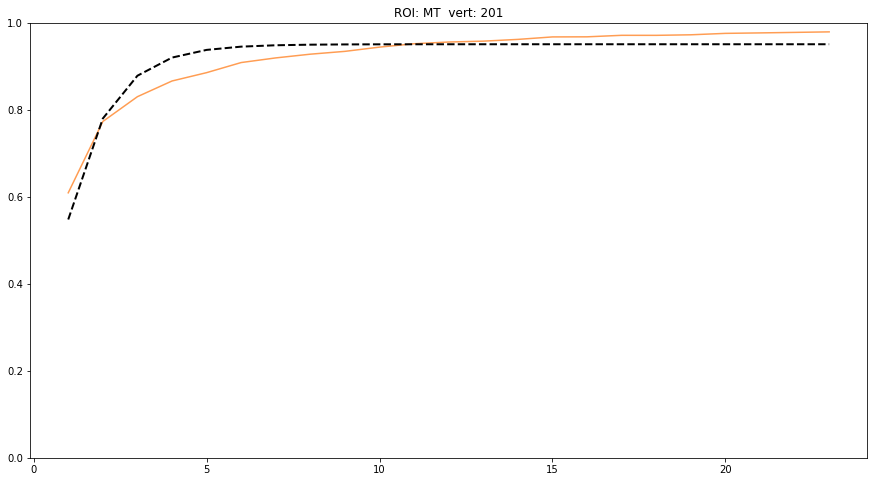

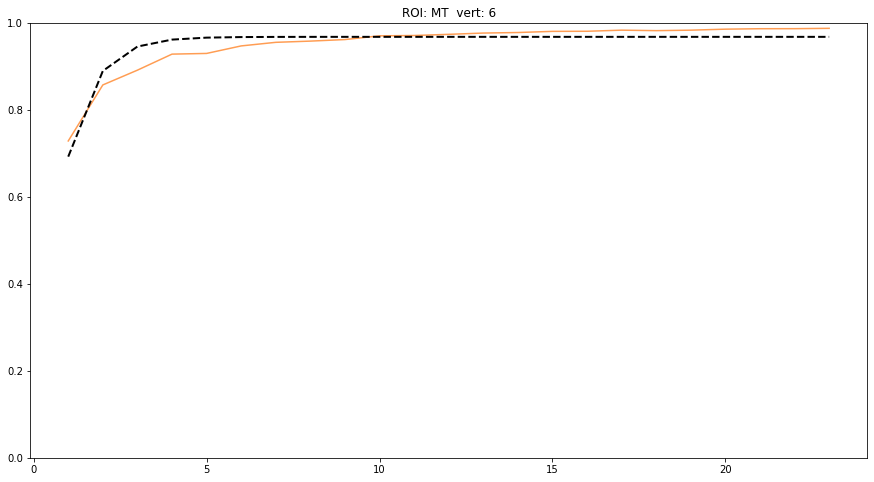

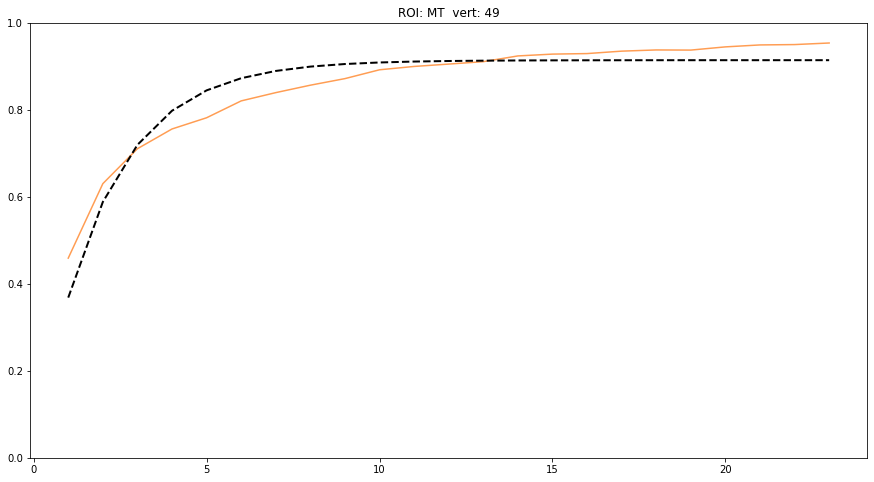

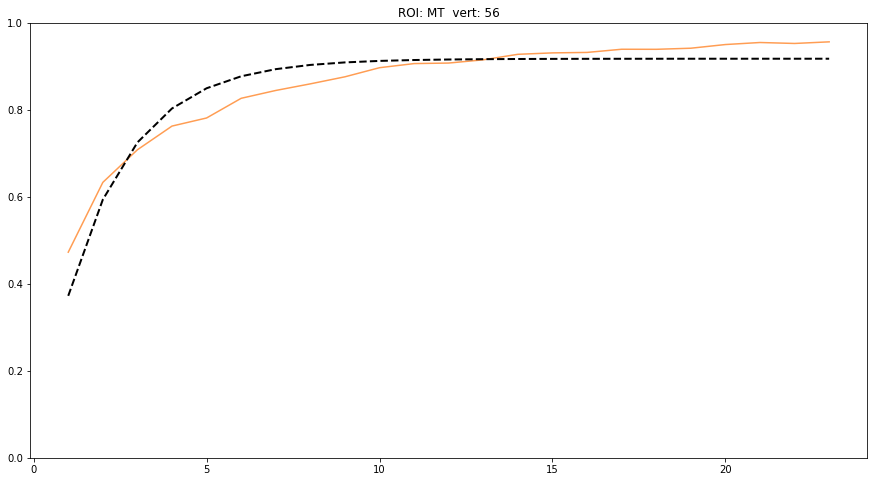

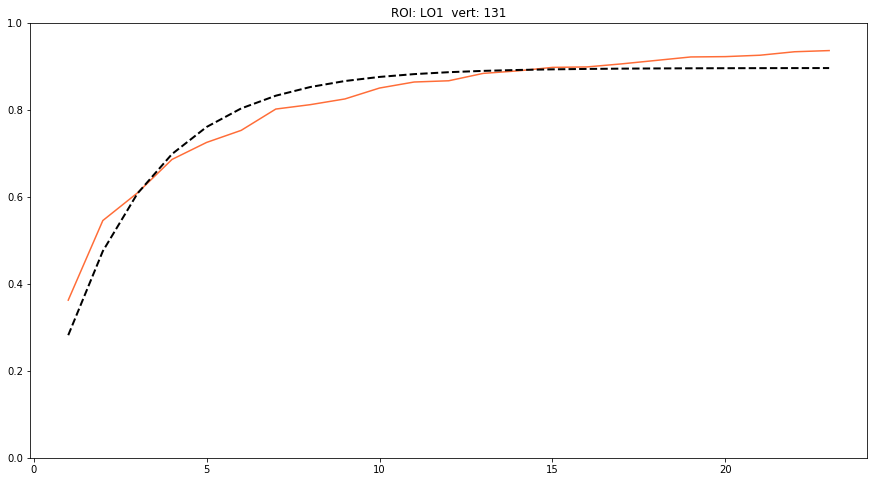

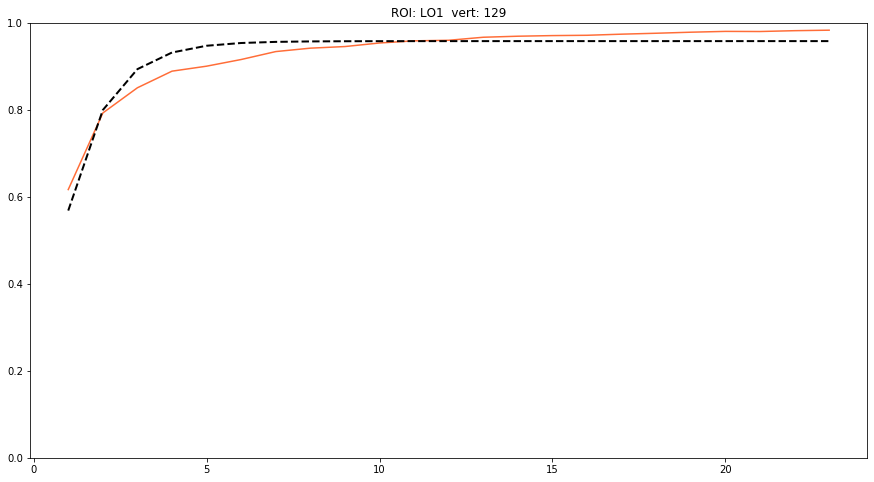

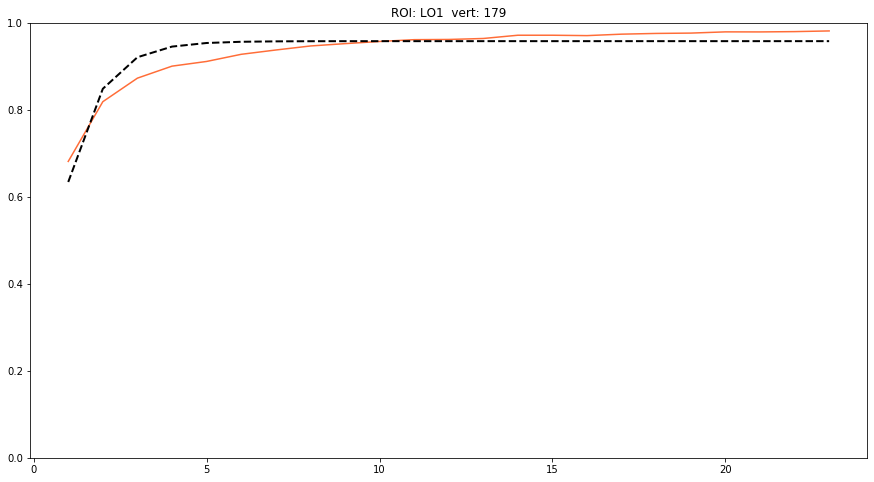

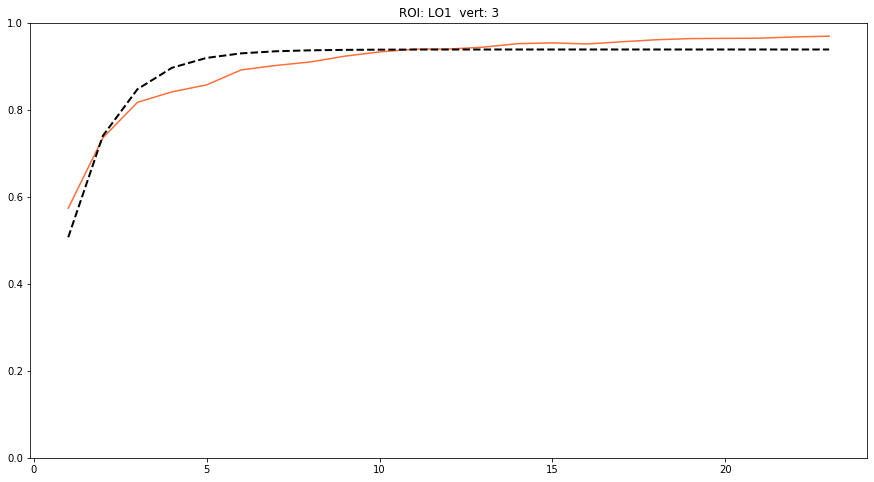

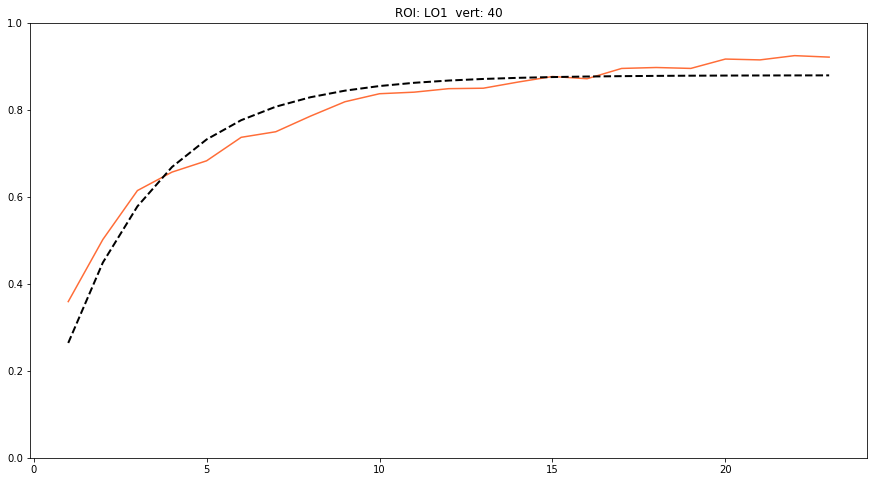

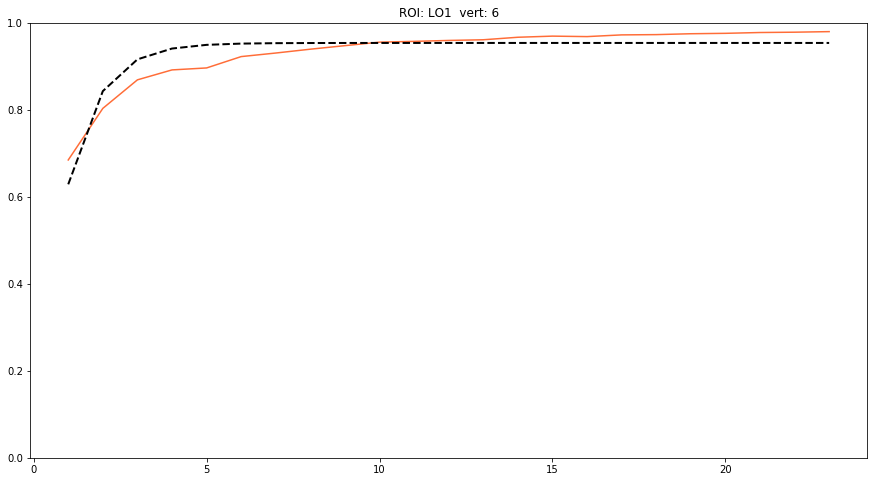

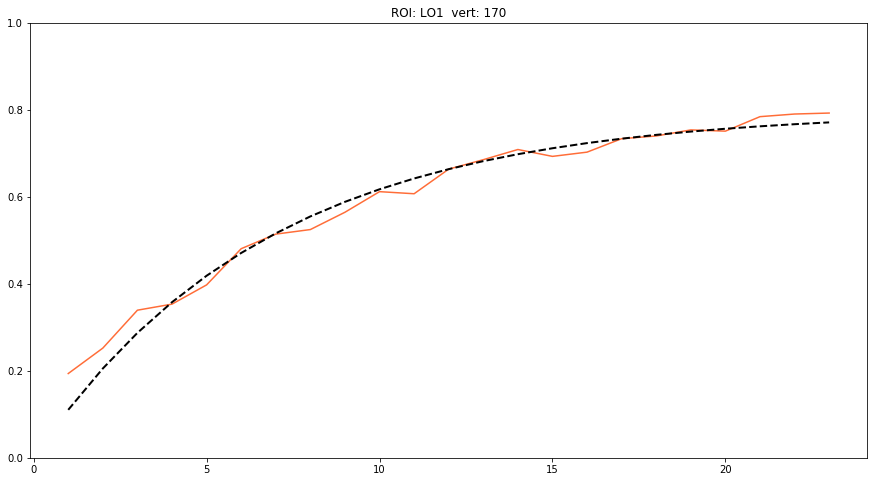

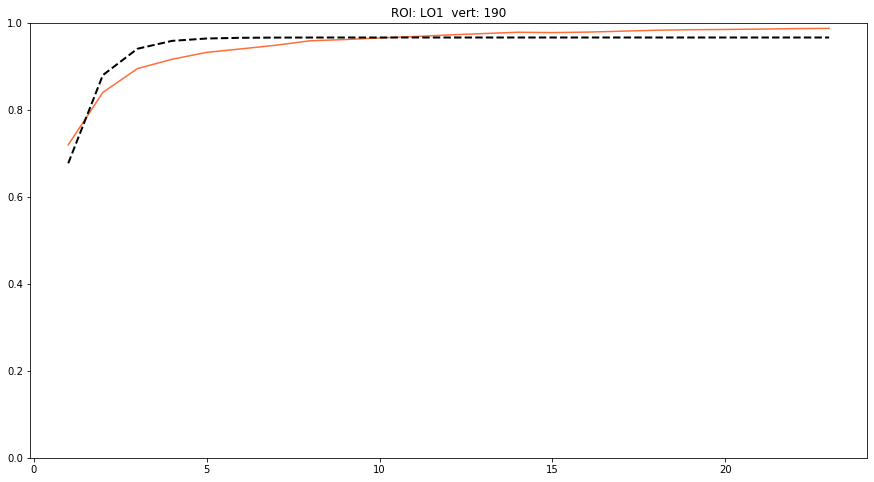

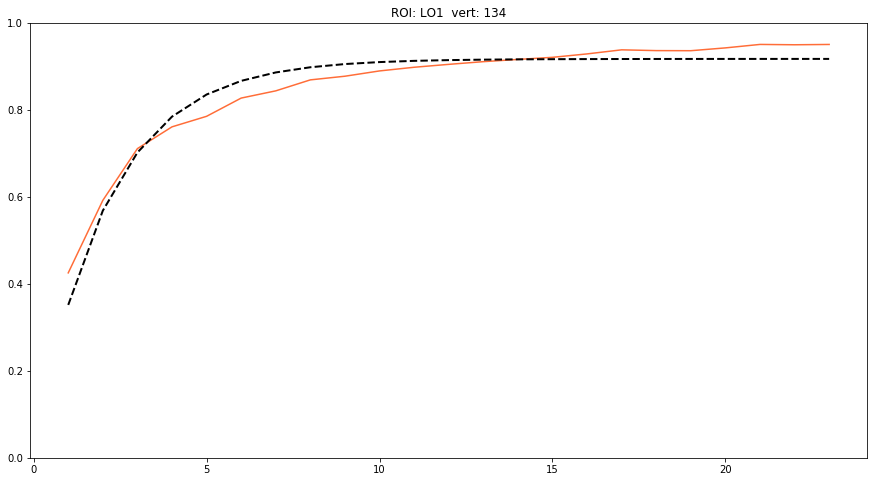

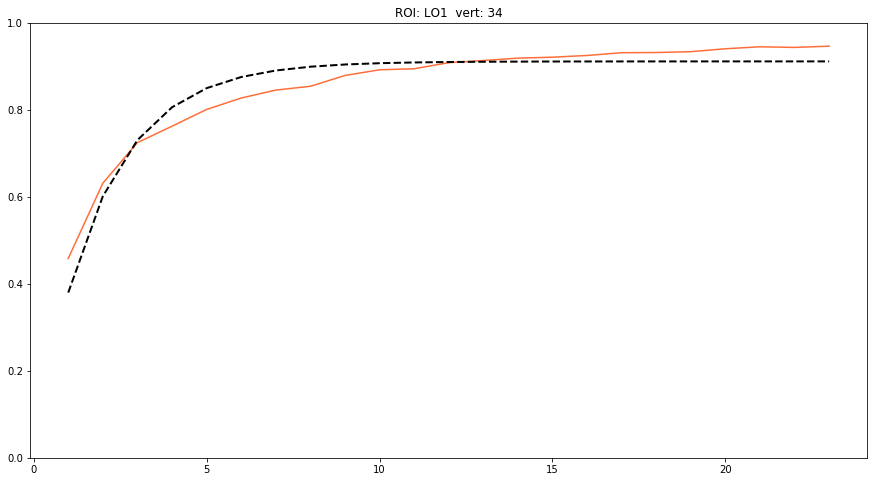

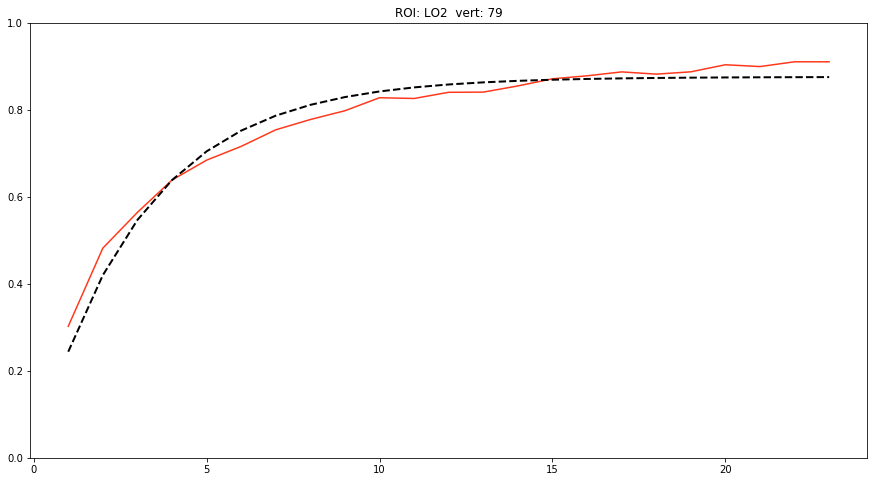

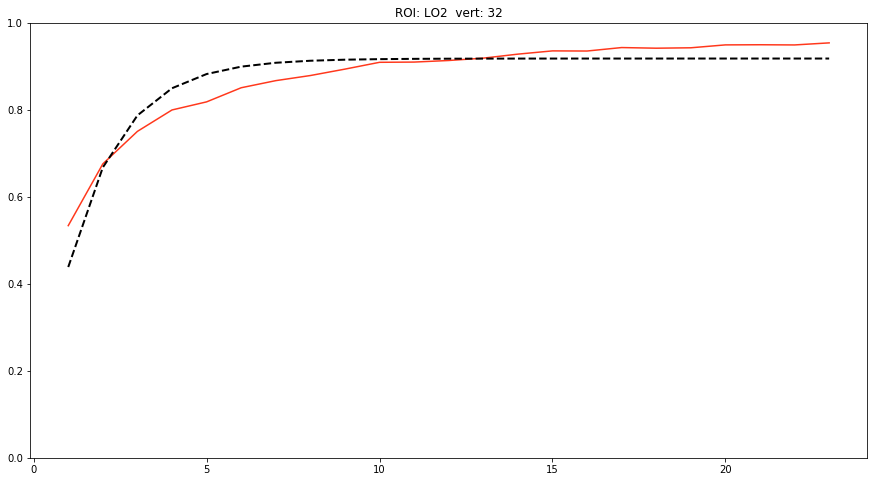

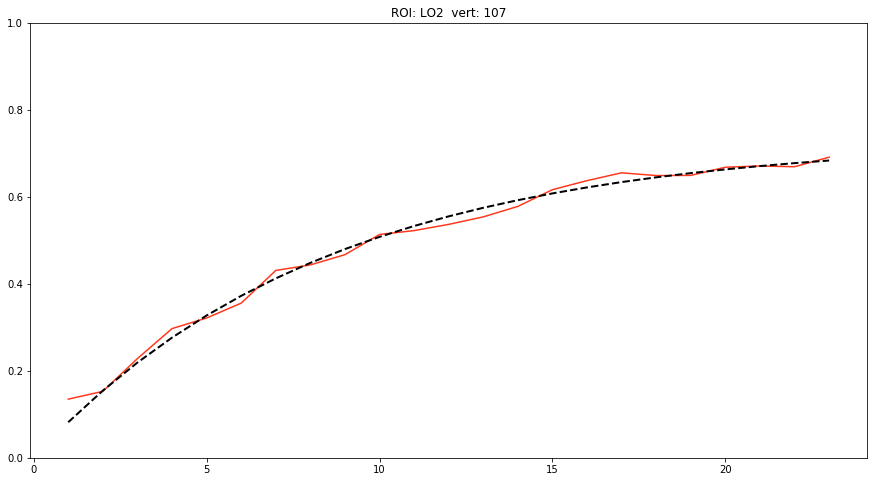

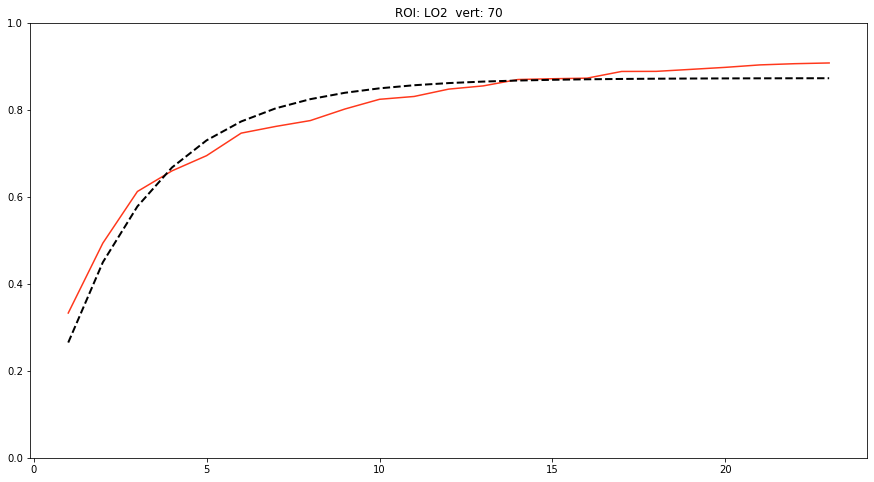

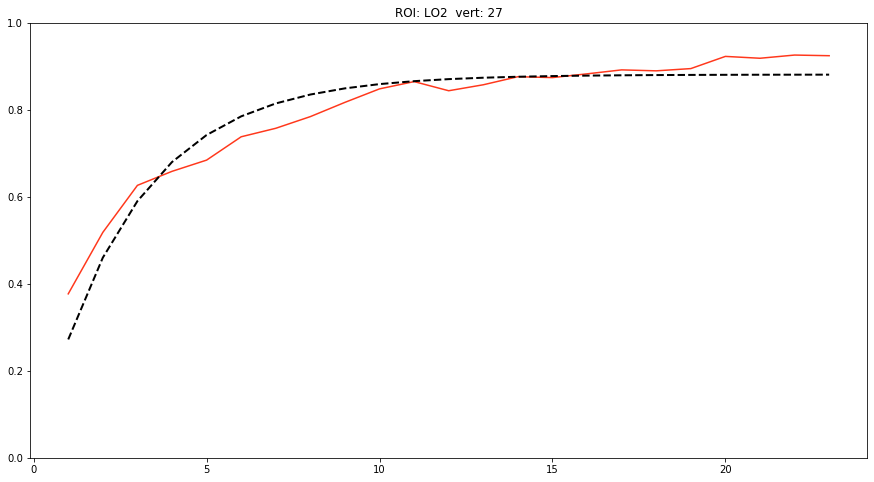

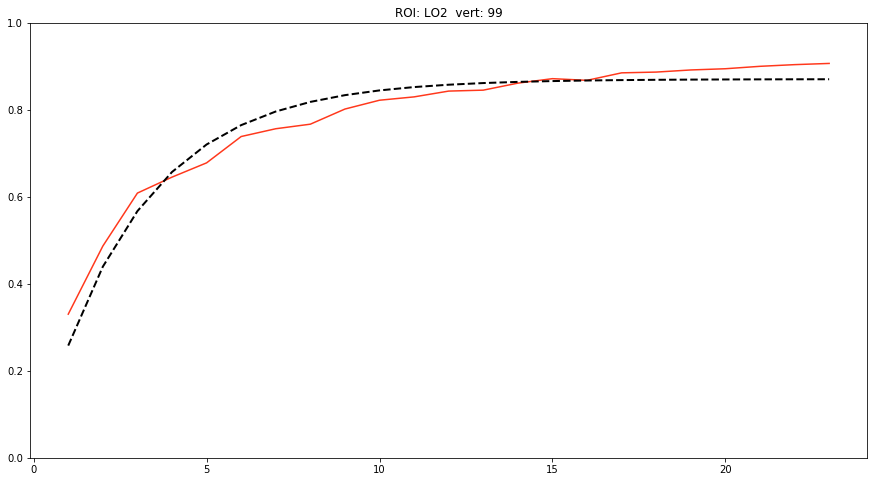

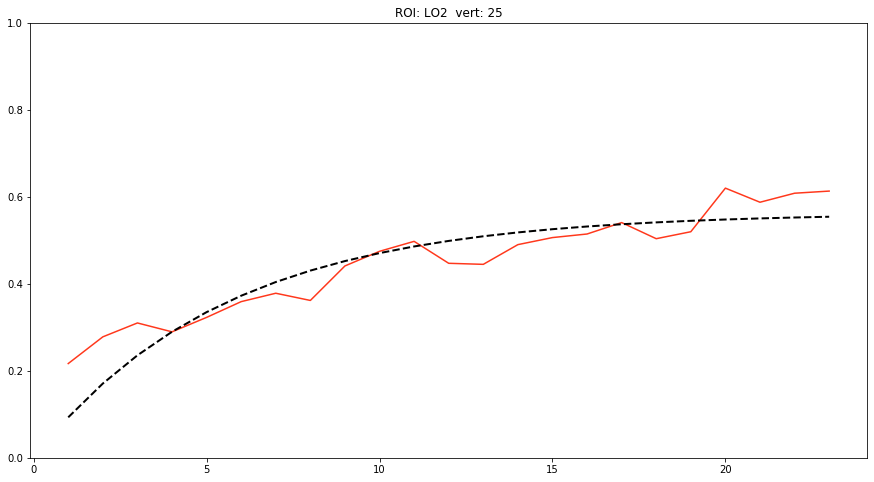

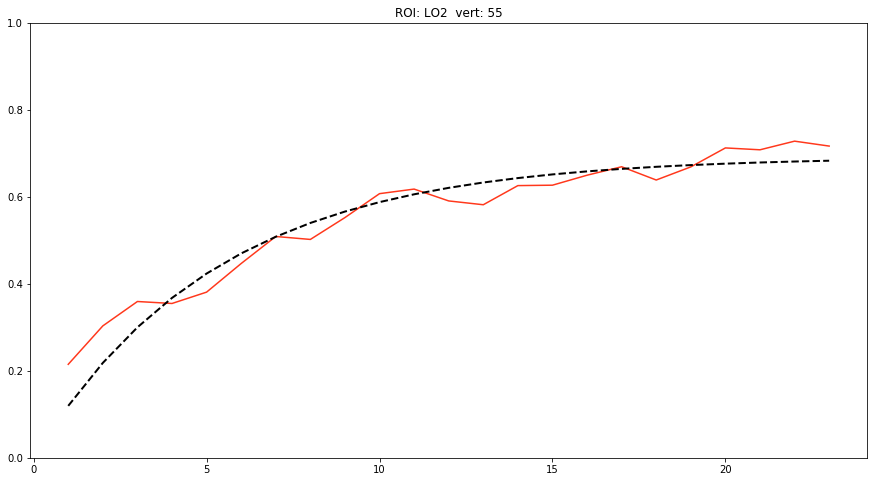

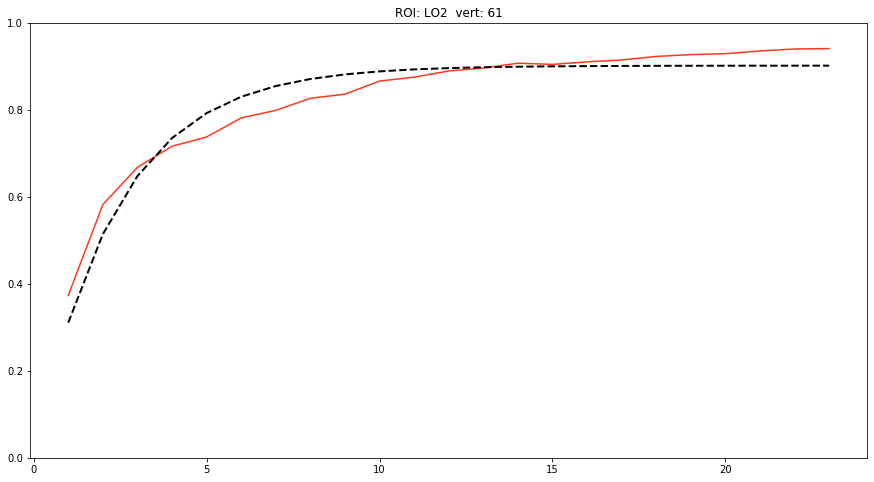

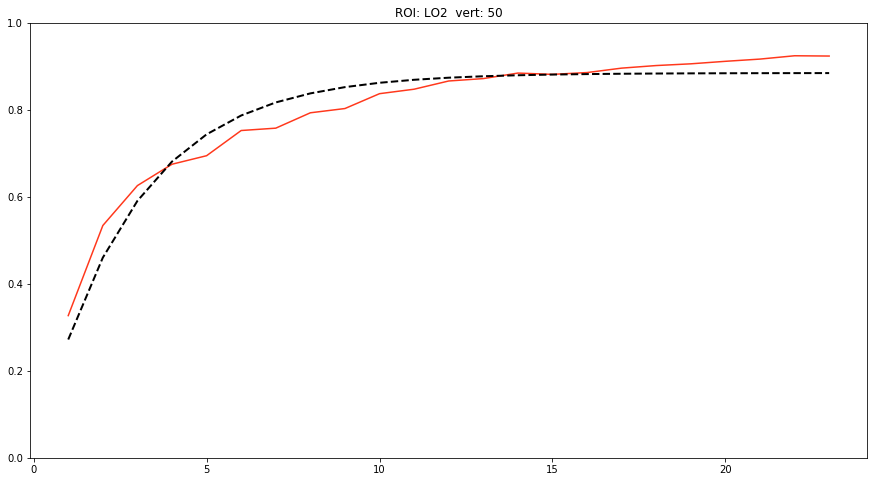

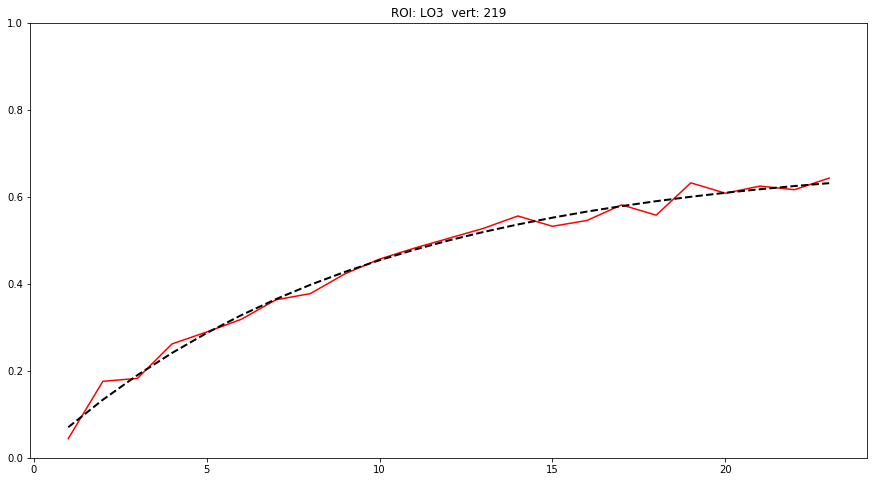

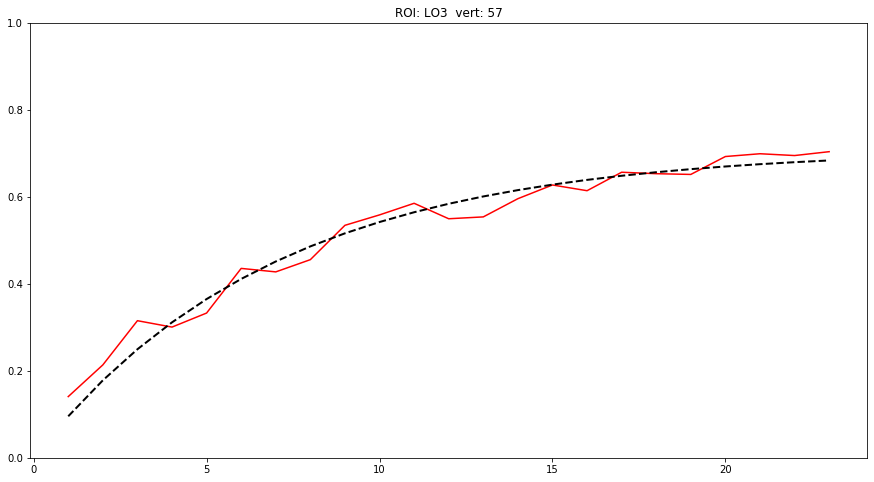

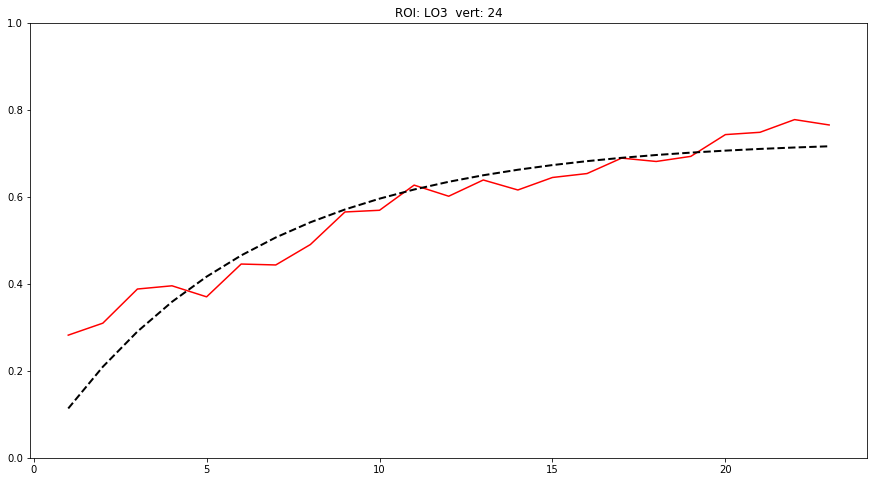

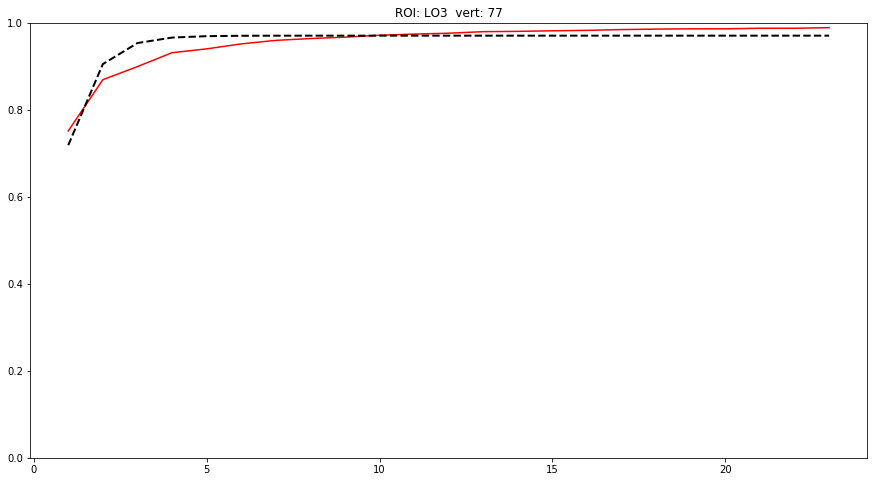

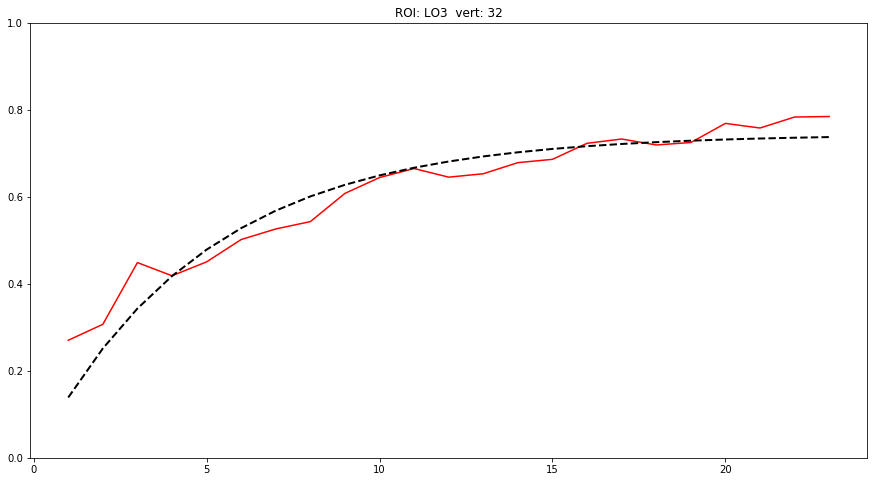

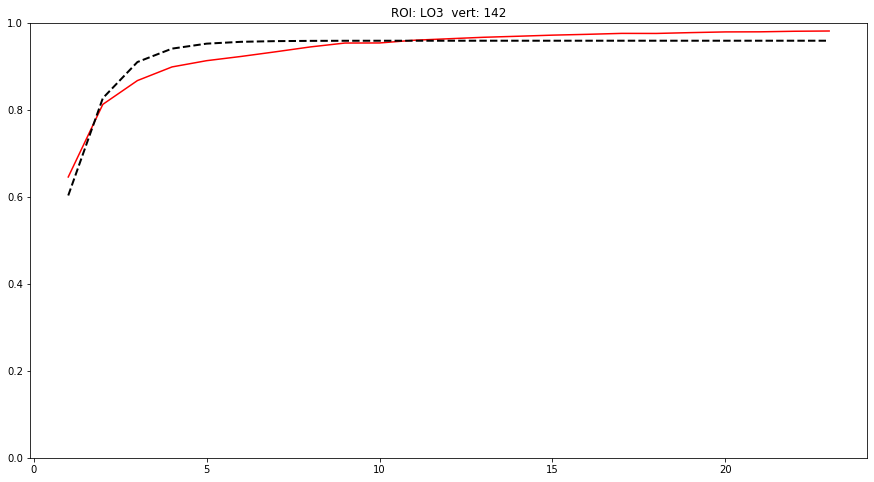

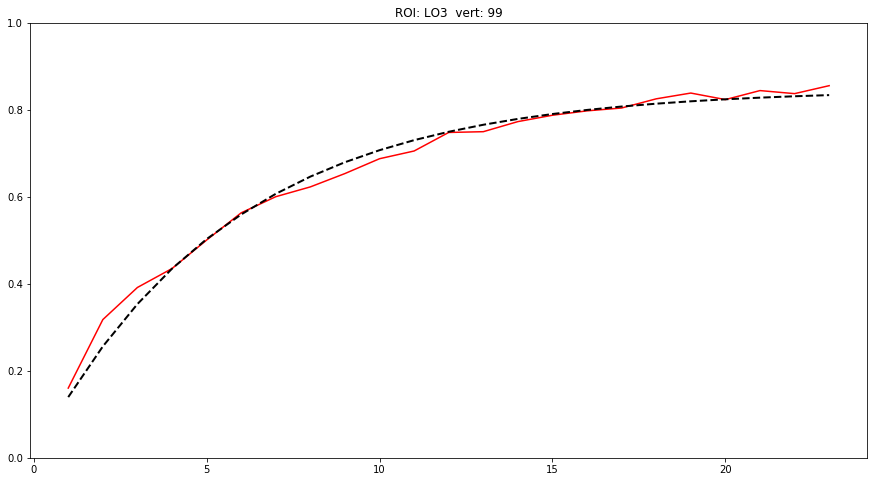

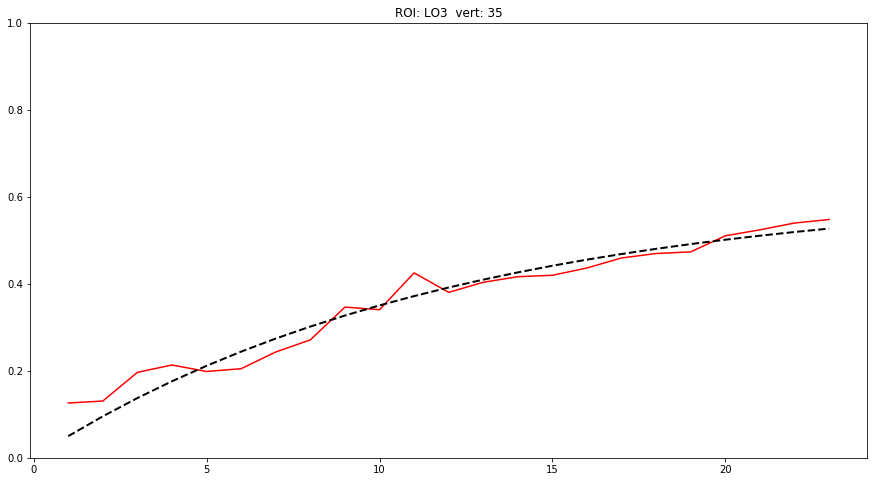

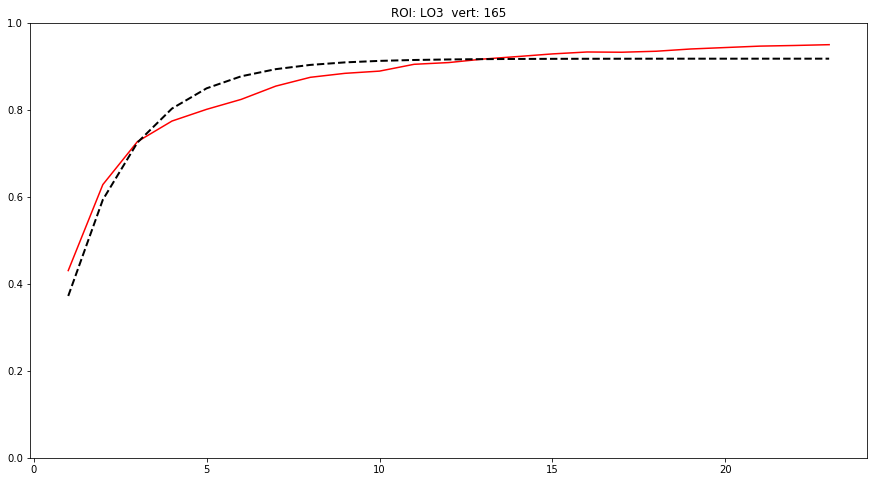

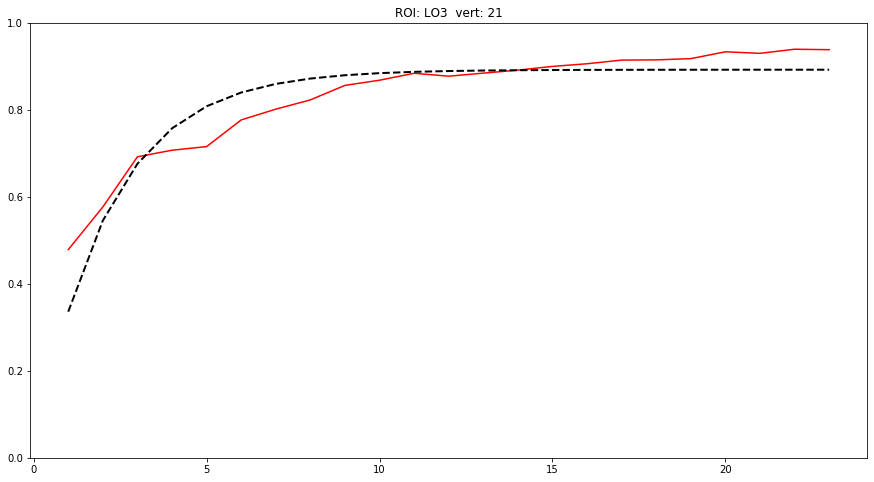

In [774]:
from matplotlib.pyplot import cm
import numpy as np

random.seed(20)

color = iter(cm.rainbow(np.linspace(0, 1, len(list(roi_index_dict.keys())[11:]))))


for keys in list(roi_index_dict.keys())[11:]:
    c = next(color)
    roi_mask = atlas_data_both_hemis == roi_index_dict[keys]
    
    for sample in random.sample(list(np.arange(len(get_cortex(corvals_s2)[roi_mask]))), 10):
        plt.figure(figsize=[15,8])
        plt.plot(tofit_x, get_cortex(corvals_s2)[roi_mask][sample,:], c=c)
        plt.plot(tofit_x, exponential(tofit_x, a_b_params[:,0][roi_mask][sample], a_b_params[:,1][roi_mask][sample]), linestyle='--', linewidth=2, color='black')
        plt.ylim(0, 1)
        plt.title(label = 'ROI: ' + str(keys) + '  vert: ' + str(sample))